## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1096, 715)
Hypercube shape: (1096, 715, 102)


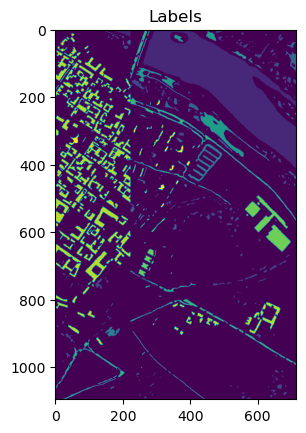

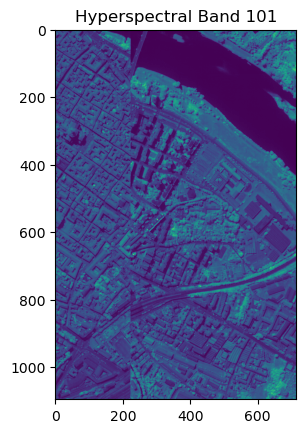

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Pavia_gt.mat'
data_files = 'Pavia.mat'
label_files = 'pavia_gt'
hypercube_files = 'pavia'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 148152
Extracted windows shape: (148152, 5, 5, 102)
Corresponding labels shape: (148152,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 65971 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 7598 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 3090 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 2685 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 6584 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 9248 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 7287 samples
Shuffled class indices for class '7'
Selected 5 training sam


 -- Test set created with: 
	148062 samples
	shape (148062, 5, 5, 102) --




All datasets saved to the 'indices' folder.
(45, 5, 5, 102)
(45, 5, 5, 102)
(148062, 5, 5, 102)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 45
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (118521, 5, 5, 102)
Validation data shape: (29631, 5, 5, 102)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

102


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/1852], Loss: 0.1606, PSNR: 4.9972


	 Training Batch [200/1852], Loss: 0.0872, PSNR: 7.2196


	 Training Batch [400/1852], Loss: 0.0467, PSNR: 9.5939


	 Training Batch [600/1852], Loss: 0.0251, PSNR: 13.0559


	 Training Batch [800/1852], Loss: 0.0183, PSNR: 14.9300


	 Training Batch [1000/1852], Loss: 0.0121, PSNR: 16.0681


	 Training Batch [1200/1852], Loss: 0.0104, PSNR: 17.2002


	 Training Batch [1400/1852], Loss: 0.0079, PSNR: 17.4119


	 Training Batch [1600/1852], Loss: 0.0074, PSNR: 16.7568


	 Training Batch [1800/1852], Loss: 0.0073, PSNR: 17.9441


Epoch [1/50] Training Loss: 0.0323, PSNR: 13.6613
	[Val]   Batch [1/463] Loss: 0.0053, PSNR: 17.9719
	[Val]   Batch [10/463] Loss: 0.0050, PSNR: 19.1136
	[Val]   Batch [20/463] Loss: 0.0050, PSNR: 18.1179
	[Val]   Batch [30/463] Loss: 0.0060, PSNR: 18.6732
	[Val]   Batch [40/463] Loss: 0.0048, PSNR: 17.7956
	[Val]   Batch [50/463] Loss: 0.0050, PSNR: 18.0078


	[Val]   Batch [60/463] Loss: 0.0048, PSNR: 18.0700
	[Val]   Batch [70/463] Loss: 0.0068, PSNR: 18.4101
	[Val]   Batch [80/463] Loss: 0.0060, PSNR: 20.3289
	[Val]   Batch [90/463] Loss: 0.0058, PSNR: 19.4211
	[Val]   Batch [100/463] Loss: 0.0059, PSNR: 19.1430
	[Val]   Batch [110/463] Loss: 0.0068, PSNR: 18.5419
	[Val]   Batch [120/463] Loss: 0.0046, PSNR: 18.0535


	[Val]   Batch [130/463] Loss: 0.0055, PSNR: 19.4479
	[Val]   Batch [140/463] Loss: 0.0064, PSNR: 18.9968
	[Val]   Batch [150/463] Loss: 0.0073, PSNR: 19.0213
	[Val]   Batch [160/463] Loss: 0.0059, PSNR: 19.2619
	[Val]   Batch [170/463] Loss: 0.0075, PSNR: 18.2423
	[Val]   Batch [180/463] Loss: 0.0055, PSNR: 19.0166
	[Val]   Batch [190/463] Loss: 0.0059, PSNR: 19.3419


	[Val]   Batch [200/463] Loss: 0.0059, PSNR: 18.7318
	[Val]   Batch [210/463] Loss: 0.0057, PSNR: 18.3302
	[Val]   Batch [220/463] Loss: 0.0057, PSNR: 19.5567
	[Val]   Batch [230/463] Loss: 0.0067, PSNR: 19.3916
	[Val]   Batch [240/463] Loss: 0.0051, PSNR: 18.1796
	[Val]   Batch [250/463] Loss: 0.0066, PSNR: 17.3568
	[Val]   Batch [260/463] Loss: 0.0057, PSNR: 18.3977


	[Val]   Batch [270/463] Loss: 0.0044, PSNR: 17.5418
	[Val]   Batch [280/463] Loss: 0.0053, PSNR: 20.2742
	[Val]   Batch [290/463] Loss: 0.0059, PSNR: 17.2734
	[Val]   Batch [300/463] Loss: 0.0059, PSNR: 19.5247
	[Val]   Batch [310/463] Loss: 0.0055, PSNR: 19.3968
	[Val]   Batch [320/463] Loss: 0.0055, PSNR: 19.2769


	[Val]   Batch [330/463] Loss: 0.0065, PSNR: 18.6764
	[Val]   Batch [340/463] Loss: 0.0053, PSNR: 19.6302
	[Val]   Batch [350/463] Loss: 0.0070, PSNR: 19.5433
	[Val]   Batch [360/463] Loss: 0.0047, PSNR: 20.4724
	[Val]   Batch [370/463] Loss: 0.0068, PSNR: 18.6177
	[Val]   Batch [380/463] Loss: 0.0067, PSNR: 18.7595
	[Val]   Batch [390/463] Loss: 0.0062, PSNR: 18.5856


	[Val]   Batch [400/463] Loss: 0.0054, PSNR: 17.6454
	[Val]   Batch [410/463] Loss: 0.0053, PSNR: 19.9616
	[Val]   Batch [420/463] Loss: 0.0055, PSNR: 18.7295
	[Val]   Batch [430/463] Loss: 0.0054, PSNR: 18.1579
	[Val]   Batch [440/463] Loss: 0.0053, PSNR: 19.1831
	[Val]   Batch [450/463] Loss: 0.0041, PSNR: 16.5053


	[Val]   Batch [460/463] Loss: 0.0058, PSNR: 17.8915
Epoch [1/50] Validation Loss: 0.0057, PSNR: 18.7138

LOG: Epoch [2/50]
	 Training Batch [1/1852], Loss: 0.0047, PSNR: 18.4199


	 Training Batch [200/1852], Loss: 0.0050, PSNR: 18.3676


	 Training Batch [400/1852], Loss: 0.0064, PSNR: 18.7865


	 Training Batch [600/1852], Loss: 0.0046, PSNR: 19.5297


	 Training Batch [800/1852], Loss: 0.0045, PSNR: 17.5074


	 Training Batch [1000/1852], Loss: 0.0048, PSNR: 20.2757


	 Training Batch [1200/1852], Loss: 0.0041, PSNR: 23.8304


	 Training Batch [1400/1852], Loss: 0.0045, PSNR: 20.4812


	 Training Batch [1600/1852], Loss: 0.0031, PSNR: 22.0729


	 Training Batch [1800/1852], Loss: 0.0026, PSNR: 22.8124


Epoch [2/50] Training Loss: 0.0043, PSNR: 20.1132
	[Val]   Batch [1/463] Loss: 0.0024, PSNR: 21.3436
	[Val]   Batch [10/463] Loss: 0.0023, PSNR: 22.5419
	[Val]   Batch [20/463] Loss: 0.0022, PSNR: 21.6144
	[Val]   Batch [30/463] Loss: 0.0029, PSNR: 21.9007
	[Val]   Batch [40/463] Loss: 0.0022, PSNR: 21.1334
	[Val]   Batch [50/463] Loss: 0.0023, PSNR: 21.3517


	[Val]   Batch [60/463] Loss: 0.0022, PSNR: 21.4045
	[Val]   Batch [70/463] Loss: 0.0033, PSNR: 21.5294
	[Val]   Batch [80/463] Loss: 0.0029, PSNR: 23.4792
	[Val]   Batch [90/463] Loss: 0.0027, PSNR: 22.7640
	[Val]   Batch [100/463] Loss: 0.0029, PSNR: 22.1824
	[Val]   Batch [110/463] Loss: 0.0033, PSNR: 21.6926
	[Val]   Batch [120/463] Loss: 0.0021, PSNR: 21.3864


	[Val]   Batch [130/463] Loss: 0.0025, PSNR: 22.8396
	[Val]   Batch [140/463] Loss: 0.0031, PSNR: 22.1359
	[Val]   Batch [150/463] Loss: 0.0034, PSNR: 22.3284
	[Val]   Batch [160/463] Loss: 0.0030, PSNR: 22.2295
	[Val]   Batch [170/463] Loss: 0.0037, PSNR: 21.2973
	[Val]   Batch [180/463] Loss: 0.0028, PSNR: 21.9815


	[Val]   Batch [190/463] Loss: 0.0027, PSNR: 22.6930
	[Val]   Batch [200/463] Loss: 0.0028, PSNR: 21.9631
	[Val]   Batch [210/463] Loss: 0.0029, PSNR: 21.2662
	[Val]   Batch [220/463] Loss: 0.0028, PSNR: 22.5987
	[Val]   Batch [230/463] Loss: 0.0031, PSNR: 22.7567
	[Val]   Batch [240/463] Loss: 0.0024, PSNR: 21.5052
	[Val]   Batch [250/463] Loss: 0.0032, PSNR: 20.4774


	[Val]   Batch [260/463] Loss: 0.0027, PSNR: 21.5578
	[Val]   Batch [270/463] Loss: 0.0020, PSNR: 21.0257
	[Val]   Batch [280/463] Loss: 0.0025, PSNR: 23.5088
	[Val]   Batch [290/463] Loss: 0.0028, PSNR: 20.5778
	[Val]   Batch [300/463] Loss: 0.0028, PSNR: 22.7482
	[Val]   Batch [310/463] Loss: 0.0028, PSNR: 22.3050
	[Val]   Batch [320/463] Loss: 0.0027, PSNR: 22.4497


	[Val]   Batch [330/463] Loss: 0.0030, PSNR: 22.0729
	[Val]   Batch [340/463] Loss: 0.0025, PSNR: 22.8317
	[Val]   Batch [350/463] Loss: 0.0036, PSNR: 22.4467
	[Val]   Batch [360/463] Loss: 0.0024, PSNR: 23.3705
	[Val]   Batch [370/463] Loss: 0.0032, PSNR: 21.9181
	[Val]   Batch [380/463] Loss: 0.0030, PSNR: 22.2888
	[Val]   Batch [390/463] Loss: 0.0028, PSNR: 21.9960
	[Val]   Batch [400/463] Loss: 0.0026, PSNR: 20.7618


	[Val]   Batch [410/463] Loss: 0.0024, PSNR: 23.3657
	[Val]   Batch [420/463] Loss: 0.0025, PSNR: 22.1368
	[Val]   Batch [430/463] Loss: 0.0027, PSNR: 21.2095
	[Val]   Batch [440/463] Loss: 0.0026, PSNR: 22.2456
	[Val]   Batch [450/463] Loss: 0.0020, PSNR: 19.6484
	[Val]   Batch [460/463] Loss: 0.0027, PSNR: 21.2567
Epoch [2/50] Validation Loss: 0.0027, PSNR: 21.9661

LOG: Epoch [3/50]
	 Training Batch [1/1852], Loss: 0.0020, PSNR: 20.2477


	 Training Batch [200/1852], Loss: 0.0037, PSNR: 20.9441


	 Training Batch [400/1852], Loss: 0.0023, PSNR: 21.9228


	 Training Batch [600/1852], Loss: 0.0026, PSNR: 22.0294


	 Training Batch [800/1852], Loss: 0.0022, PSNR: 22.0524


	 Training Batch [1000/1852], Loss: 0.0020, PSNR: 21.9866


	 Training Batch [1200/1852], Loss: 0.0025, PSNR: 23.1480


	 Training Batch [1400/1852], Loss: 0.0019, PSNR: 23.1016


	 Training Batch [1600/1852], Loss: 0.0023, PSNR: 24.3762


	 Training Batch [1800/1852], Loss: 0.0019, PSNR: 23.0634


Epoch [3/50] Training Loss: 0.0023, PSNR: 22.7098
	[Val]   Batch [1/463] Loss: 0.0015, PSNR: 23.5250
	[Val]   Batch [10/463] Loss: 0.0014, PSNR: 24.7752
	[Val]   Batch [20/463] Loss: 0.0013, PSNR: 23.9353
	[Val]   Batch [30/463] Loss: 0.0016, PSNR: 24.4340
	[Val]   Batch [40/463] Loss: 0.0014, PSNR: 23.0191
	[Val]   Batch [50/463] Loss: 0.0014, PSNR: 23.4188
	[Val]   Batch [60/463] Loss: 0.0014, PSNR: 23.4150


	[Val]   Batch [70/463] Loss: 0.0018, PSNR: 24.0692
	[Val]   Batch [80/463] Loss: 0.0016, PSNR: 26.0789
	[Val]   Batch [90/463] Loss: 0.0016, PSNR: 25.0747
	[Val]   Batch [100/463] Loss: 0.0017, PSNR: 24.5837
	[Val]   Batch [110/463] Loss: 0.0018, PSNR: 24.2895
	[Val]   Batch [120/463] Loss: 0.0014, PSNR: 23.3108


	[Val]   Batch [130/463] Loss: 0.0014, PSNR: 25.3803
	[Val]   Batch [140/463] Loss: 0.0018, PSNR: 24.5599
	[Val]   Batch [150/463] Loss: 0.0017, PSNR: 25.2234
	[Val]   Batch [160/463] Loss: 0.0019, PSNR: 24.2651
	[Val]   Batch [170/463] Loss: 0.0022, PSNR: 23.6281
	[Val]   Batch [180/463] Loss: 0.0017, PSNR: 24.1486
	[Val]   Batch [190/463] Loss: 0.0016, PSNR: 25.1360


	[Val]   Batch [200/463] Loss: 0.0015, PSNR: 24.5901
	[Val]   Batch [210/463] Loss: 0.0018, PSNR: 23.2655
	[Val]   Batch [220/463] Loss: 0.0017, PSNR: 24.6929
	[Val]   Batch [230/463] Loss: 0.0015, PSNR: 25.7823
	[Val]   Batch [240/463] Loss: 0.0014, PSNR: 23.7338
	[Val]   Batch [250/463] Loss: 0.0020, PSNR: 22.6154
	[Val]   Batch [260/463] Loss: 0.0017, PSNR: 23.6525


	[Val]   Batch [270/463] Loss: 0.0012, PSNR: 22.9985
	[Val]   Batch [280/463] Loss: 0.0015, PSNR: 25.6948
	[Val]   Batch [290/463] Loss: 0.0016, PSNR: 22.8547
	[Val]   Batch [300/463] Loss: 0.0017, PSNR: 24.8876
	[Val]   Batch [310/463] Loss: 0.0018, PSNR: 24.2596
	[Val]   Batch [320/463] Loss: 0.0016, PSNR: 24.7165
	[Val]   Batch [330/463] Loss: 0.0016, PSNR: 24.7111
	[Val]   Batch [340/463] Loss: 0.0015, PSNR: 25.0551


	[Val]   Batch [350/463] Loss: 0.0021, PSNR: 24.8292
	[Val]   Batch [360/463] Loss: 0.0017, PSNR: 24.8205
	[Val]   Batch [370/463] Loss: 0.0018, PSNR: 24.4573
	[Val]   Batch [380/463] Loss: 0.0015, PSNR: 25.1830
	[Val]   Batch [390/463] Loss: 0.0015, PSNR: 24.7204
	[Val]   Batch [400/463] Loss: 0.0017, PSNR: 22.7105


	[Val]   Batch [410/463] Loss: 0.0014, PSNR: 25.6582
	[Val]   Batch [420/463] Loss: 0.0015, PSNR: 24.4742
	[Val]   Batch [430/463] Loss: 0.0017, PSNR: 23.1258
	[Val]   Batch [440/463] Loss: 0.0016, PSNR: 24.2643
	[Val]   Batch [450/463] Loss: 0.0014, PSNR: 21.2979
	[Val]   Batch [460/463] Loss: 0.0016, PSNR: 23.4910
Epoch [3/50] Validation Loss: 0.0016, PSNR: 24.2730

LOG: Epoch [4/50]


	 Training Batch [1/1852], Loss: 0.0019, PSNR: 23.8399


	 Training Batch [200/1852], Loss: 0.0018, PSNR: 25.1485


	 Training Batch [400/1852], Loss: 0.0015, PSNR: 24.2624


	 Training Batch [600/1852], Loss: 0.0017, PSNR: 23.7312


	 Training Batch [800/1852], Loss: 0.0023, PSNR: 22.6735


	 Training Batch [1000/1852], Loss: 0.0014, PSNR: 24.9170


	 Training Batch [1200/1852], Loss: 0.0014, PSNR: 24.2246


	 Training Batch [1400/1852], Loss: 0.0020, PSNR: 24.7628


	 Training Batch [1600/1852], Loss: 0.0013, PSNR: 24.9232


	 Training Batch [1800/1852], Loss: 0.0013, PSNR: 25.7311


Epoch [4/50] Training Loss: 0.0016, PSNR: 24.2817
	[Val]   Batch [1/463] Loss: 0.0011, PSNR: 24.7056
	[Val]   Batch [10/463] Loss: 0.0010, PSNR: 25.9568
	[Val]   Batch [20/463] Loss: 0.0010, PSNR: 25.1116
	[Val]   Batch [30/463] Loss: 0.0012, PSNR: 25.6896
	[Val]   Batch [40/463] Loss: 0.0011, PSNR: 24.0924
	[Val]   Batch [50/463] Loss: 0.0011, PSNR: 24.5467


	[Val]   Batch [60/463] Loss: 0.0011, PSNR: 24.5260
	[Val]   Batch [70/463] Loss: 0.0014, PSNR: 25.3196
	[Val]   Batch [80/463] Loss: 0.0012, PSNR: 27.4781
	[Val]   Batch [90/463] Loss: 0.0012, PSNR: 26.3161
	[Val]   Batch [100/463] Loss: 0.0012, PSNR: 25.8784
	[Val]   Batch [110/463] Loss: 0.0013, PSNR: 25.6621
	[Val]   Batch [120/463] Loss: 0.0011, PSNR: 24.4678


	[Val]   Batch [130/463] Loss: 0.0010, PSNR: 26.6665
	[Val]   Batch [140/463] Loss: 0.0013, PSNR: 25.7990
	[Val]   Batch [150/463] Loss: 0.0013, PSNR: 26.5696
	[Val]   Batch [160/463] Loss: 0.0014, PSNR: 25.3679
	[Val]   Batch [170/463] Loss: 0.0017, PSNR: 24.7805
	[Val]   Batch [180/463] Loss: 0.0013, PSNR: 25.2961
	[Val]   Batch [190/463] Loss: 0.0012, PSNR: 26.3102


	[Val]   Batch [200/463] Loss: 0.0011, PSNR: 25.8909
	[Val]   Batch [210/463] Loss: 0.0014, PSNR: 24.3744
	[Val]   Batch [220/463] Loss: 0.0013, PSNR: 25.8583
	[Val]   Batch [230/463] Loss: 0.0011, PSNR: 27.2295
	[Val]   Batch [240/463] Loss: 0.0011, PSNR: 24.9350
	[Val]   Batch [250/463] Loss: 0.0015, PSNR: 23.7316
	[Val]   Batch [260/463] Loss: 0.0013, PSNR: 24.7184


	[Val]   Batch [270/463] Loss: 0.0010, PSNR: 24.1582
	[Val]   Batch [280/463] Loss: 0.0012, PSNR: 26.8786
	[Val]   Batch [290/463] Loss: 0.0012, PSNR: 24.1093
	[Val]   Batch [300/463] Loss: 0.0014, PSNR: 25.9185
	[Val]   Batch [310/463] Loss: 0.0014, PSNR: 25.3831
	[Val]   Batch [320/463] Loss: 0.0012, PSNR: 25.9713
	[Val]   Batch [330/463] Loss: 0.0012, PSNR: 26.0017


	[Val]   Batch [340/463] Loss: 0.0011, PSNR: 26.2646
	[Val]   Batch [350/463] Loss: 0.0015, PSNR: 26.0962
	[Val]   Batch [360/463] Loss: 0.0014, PSNR: 25.6918
	[Val]   Batch [370/463] Loss: 0.0013, PSNR: 25.7812
	[Val]   Batch [380/463] Loss: 0.0011, PSNR: 26.5598
	[Val]   Batch [390/463] Loss: 0.0011, PSNR: 26.0727
	[Val]   Batch [400/463] Loss: 0.0013, PSNR: 23.8234


	[Val]   Batch [410/463] Loss: 0.0011, PSNR: 26.8783
	[Val]   Batch [420/463] Loss: 0.0011, PSNR: 25.6301
	[Val]   Batch [430/463] Loss: 0.0014, PSNR: 24.1593
	[Val]   Batch [440/463] Loss: 0.0012, PSNR: 25.4551
	[Val]   Batch [450/463] Loss: 0.0011, PSNR: 22.4017
	[Val]   Batch [460/463] Loss: 0.0012, PSNR: 24.6136
Epoch [4/50] Validation Loss: 0.0012, PSNR: 25.4893

LOG: Epoch [5/50]
	 Training Batch [1/1852], Loss: 0.0020, PSNR: 24.1298


	 Training Batch [200/1852], Loss: 0.0013, PSNR: 24.9228


	 Training Batch [400/1852], Loss: 0.0011, PSNR: 25.9664


	 Training Batch [600/1852], Loss: 0.0016, PSNR: 24.8360


	 Training Batch [800/1852], Loss: 0.0016, PSNR: 25.4901


	 Training Batch [1000/1852], Loss: 0.0014, PSNR: 25.1434


	 Training Batch [1200/1852], Loss: 0.0015, PSNR: 24.1887


	 Training Batch [1400/1852], Loss: 0.0015, PSNR: 24.9571


	 Training Batch [1600/1852], Loss: 0.0013, PSNR: 26.9476


	 Training Batch [1800/1852], Loss: 0.0014, PSNR: 24.0502


Epoch [5/50] Training Loss: 0.0013, PSNR: 25.3305
	[Val]   Batch [1/463] Loss: 0.0009, PSNR: 25.7368
	[Val]   Batch [10/463] Loss: 0.0008, PSNR: 27.0565
	[Val]   Batch [20/463] Loss: 0.0008, PSNR: 26.2845
	[Val]   Batch [30/463] Loss: 0.0009, PSNR: 26.7107
	[Val]   Batch [40/463] Loss: 0.0009, PSNR: 25.1371
	[Val]   Batch [50/463] Loss: 0.0009, PSNR: 25.6637


	[Val]   Batch [60/463] Loss: 0.0008, PSNR: 25.5678
	[Val]   Batch [70/463] Loss: 0.0011, PSNR: 26.3239
	[Val]   Batch [80/463] Loss: 0.0009, PSNR: 28.7130
	[Val]   Batch [90/463] Loss: 0.0009, PSNR: 27.4036
	[Val]   Batch [100/463] Loss: 0.0010, PSNR: 26.9320
	[Val]   Batch [110/463] Loss: 0.0010, PSNR: 26.7354


	[Val]   Batch [120/463] Loss: 0.0008, PSNR: 25.5756
	[Val]   Batch [130/463] Loss: 0.0008, PSNR: 27.7269
	[Val]   Batch [140/463] Loss: 0.0010, PSNR: 26.8730
	[Val]   Batch [150/463] Loss: 0.0010, PSNR: 27.7118
	[Val]   Batch [160/463] Loss: 0.0011, PSNR: 26.3438
	[Val]   Batch [170/463] Loss: 0.0013, PSNR: 25.6976


	[Val]   Batch [180/463] Loss: 0.0010, PSNR: 26.3633
	[Val]   Batch [190/463] Loss: 0.0009, PSNR: 27.3681
	[Val]   Batch [200/463] Loss: 0.0009, PSNR: 27.1371
	[Val]   Batch [210/463] Loss: 0.0011, PSNR: 25.3458
	[Val]   Batch [220/463] Loss: 0.0011, PSNR: 26.8226
	[Val]   Batch [230/463] Loss: 0.0008, PSNR: 28.3943
	[Val]   Batch [240/463] Loss: 0.0008, PSNR: 26.0882
	[Val]   Batch [250/463] Loss: 0.0012, PSNR: 24.7245


	[Val]   Batch [260/463] Loss: 0.0011, PSNR: 25.6763
	[Val]   Batch [270/463] Loss: 0.0007, PSNR: 25.4006
	[Val]   Batch [280/463] Loss: 0.0009, PSNR: 27.9711
	[Val]   Batch [290/463] Loss: 0.0010, PSNR: 25.1894
	[Val]   Batch [300/463] Loss: 0.0011, PSNR: 26.9218
	[Val]   Batch [310/463] Loss: 0.0011, PSNR: 26.4452
	[Val]   Batch [320/463] Loss: 0.0009, PSNR: 27.1235


	[Val]   Batch [330/463] Loss: 0.0009, PSNR: 27.1103
	[Val]   Batch [340/463] Loss: 0.0009, PSNR: 27.3741
	[Val]   Batch [350/463] Loss: 0.0012, PSNR: 27.0518
	[Val]   Batch [360/463] Loss: 0.0012, PSNR: 26.5210
	[Val]   Batch [370/463] Loss: 0.0010, PSNR: 26.8505
	[Val]   Batch [380/463] Loss: 0.0008, PSNR: 27.7843
	[Val]   Batch [390/463] Loss: 0.0008, PSNR: 27.2300


	[Val]   Batch [400/463] Loss: 0.0010, PSNR: 24.8118
	[Val]   Batch [410/463] Loss: 0.0008, PSNR: 27.9885
	[Val]   Batch [420/463] Loss: 0.0009, PSNR: 26.7091
	[Val]   Batch [430/463] Loss: 0.0011, PSNR: 25.1301
	[Val]   Batch [440/463] Loss: 0.0010, PSNR: 26.4337
	[Val]   Batch [450/463] Loss: 0.0008, PSNR: 23.4920
	[Val]   Batch [460/463] Loss: 0.0010, PSNR: 25.6721
Epoch [5/50] Validation Loss: 0.0009, PSNR: 26.5809

LOG: Epoch [6/50]
	 Training Batch [1/1852], Loss: 0.0013, PSNR: 25.6913


	 Training Batch [200/1852], Loss: 0.0010, PSNR: 25.1280


	 Training Batch [400/1852], Loss: 0.0010, PSNR: 25.1725


	 Training Batch [600/1852], Loss: 0.0010, PSNR: 25.6800


	 Training Batch [800/1852], Loss: 0.0011, PSNR: 26.4132


	 Training Batch [1000/1852], Loss: 0.0009, PSNR: 24.4183


	 Training Batch [1200/1852], Loss: 0.0009, PSNR: 28.2560


	 Training Batch [1400/1852], Loss: 0.0009, PSNR: 24.8806


	 Training Batch [1600/1852], Loss: 0.0008, PSNR: 26.0060


	 Training Batch [1800/1852], Loss: 0.0009, PSNR: 27.5550


Epoch [6/50] Training Loss: 0.0011, PSNR: 26.1185
	[Val]   Batch [1/463] Loss: 0.0007, PSNR: 26.6113
	[Val]   Batch [10/463] Loss: 0.0007, PSNR: 27.9722
	[Val]   Batch [20/463] Loss: 0.0006, PSNR: 27.1810
	[Val]   Batch [30/463] Loss: 0.0008, PSNR: 27.5874
	[Val]   Batch [40/463] Loss: 0.0007, PSNR: 25.9680
	[Val]   Batch [50/463] Loss: 0.0007, PSNR: 26.5900


	[Val]   Batch [60/463] Loss: 0.0007, PSNR: 26.4313
	[Val]   Batch [70/463] Loss: 0.0009, PSNR: 27.2130
	[Val]   Batch [80/463] Loss: 0.0007, PSNR: 29.7873
	[Val]   Batch [90/463] Loss: 0.0007, PSNR: 28.3648
	[Val]   Batch [100/463] Loss: 0.0008, PSNR: 27.8431
	[Val]   Batch [110/463] Loss: 0.0008, PSNR: 27.7259


	[Val]   Batch [120/463] Loss: 0.0007, PSNR: 26.4984
	[Val]   Batch [130/463] Loss: 0.0007, PSNR: 28.6324
	[Val]   Batch [140/463] Loss: 0.0008, PSNR: 27.8310
	[Val]   Batch [150/463] Loss: 0.0008, PSNR: 28.6371
	[Val]   Batch [160/463] Loss: 0.0010, PSNR: 27.1553
	[Val]   Batch [170/463] Loss: 0.0011, PSNR: 26.5288


	[Val]   Batch [180/463] Loss: 0.0008, PSNR: 27.2397
	[Val]   Batch [190/463] Loss: 0.0008, PSNR: 28.2313
	[Val]   Batch [200/463] Loss: 0.0007, PSNR: 28.1287
	[Val]   Batch [210/463] Loss: 0.0009, PSNR: 26.2124
	[Val]   Batch [220/463] Loss: 0.0009, PSNR: 27.6480
	[Val]   Batch [230/463] Loss: 0.0007, PSNR: 29.3869
	[Val]   Batch [240/463] Loss: 0.0007, PSNR: 26.9982


	[Val]   Batch [250/463] Loss: 0.0010, PSNR: 25.5712
	[Val]   Batch [260/463] Loss: 0.0009, PSNR: 26.4554
	[Val]   Batch [270/463] Loss: 0.0006, PSNR: 26.4436
	[Val]   Batch [280/463] Loss: 0.0007, PSNR: 28.9048
	[Val]   Batch [290/463] Loss: 0.0008, PSNR: 26.1362
	[Val]   Batch [300/463] Loss: 0.0009, PSNR: 27.7284


	[Val]   Batch [310/463] Loss: 0.0009, PSNR: 27.3276
	[Val]   Batch [320/463] Loss: 0.0007, PSNR: 28.1272
	[Val]   Batch [330/463] Loss: 0.0007, PSNR: 28.0499
	[Val]   Batch [340/463] Loss: 0.0007, PSNR: 28.3195
	[Val]   Batch [350/463] Loss: 0.0010, PSNR: 27.9216
	[Val]   Batch [360/463] Loss: 0.0010, PSNR: 27.1444
	[Val]   Batch [370/463] Loss: 0.0008, PSNR: 27.8245
	[Val]   Batch [380/463] Loss: 0.0007, PSNR: 28.8208


	[Val]   Batch [390/463] Loss: 0.0007, PSNR: 28.2230
	[Val]   Batch [400/463] Loss: 0.0009, PSNR: 25.6567
	[Val]   Batch [410/463] Loss: 0.0007, PSNR: 28.9197
	[Val]   Batch [420/463] Loss: 0.0007, PSNR: 27.5983
	[Val]   Batch [430/463] Loss: 0.0009, PSNR: 25.9100
	[Val]   Batch [440/463] Loss: 0.0008, PSNR: 27.3184
	[Val]   Batch [450/463] Loss: 0.0007, PSNR: 24.4221


	[Val]   Batch [460/463] Loss: 0.0008, PSNR: 26.5304
Epoch [6/50] Validation Loss: 0.0008, PSNR: 27.4981

LOG: Epoch [7/50]
	 Training Batch [1/1852], Loss: 0.0012, PSNR: 27.1050


	 Training Batch [200/1852], Loss: 0.0008, PSNR: 27.8137


	 Training Batch [400/1852], Loss: 0.0011, PSNR: 25.4353


	 Training Batch [600/1852], Loss: 0.0008, PSNR: 26.0544


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 23.2550


	 Training Batch [1000/1852], Loss: 0.0010, PSNR: 26.8765


	 Training Batch [1200/1852], Loss: 0.0011, PSNR: 25.9679


	 Training Batch [1400/1852], Loss: 0.0009, PSNR: 26.8917


	 Training Batch [1600/1852], Loss: 0.0011, PSNR: 29.5229


	 Training Batch [1800/1852], Loss: 0.0007, PSNR: 29.3658


Epoch [7/50] Training Loss: 0.0009, PSNR: 26.7428
	[Val]   Batch [1/463] Loss: 0.0006, PSNR: 27.2509
	[Val]   Batch [10/463] Loss: 0.0006, PSNR: 28.6055
	[Val]   Batch [20/463] Loss: 0.0005, PSNR: 27.8201
	[Val]   Batch [30/463] Loss: 0.0007, PSNR: 28.1960
	[Val]   Batch [40/463] Loss: 0.0006, PSNR: 26.5653
	[Val]   Batch [50/463] Loss: 0.0006, PSNR: 27.2604
	[Val]   Batch [60/463] Loss: 0.0006, PSNR: 26.9935


	[Val]   Batch [70/463] Loss: 0.0008, PSNR: 27.8162
	[Val]   Batch [80/463] Loss: 0.0006, PSNR: 30.5253
	[Val]   Batch [90/463] Loss: 0.0006, PSNR: 28.9307
	[Val]   Batch [100/463] Loss: 0.0007, PSNR: 28.5357
	[Val]   Batch [110/463] Loss: 0.0007, PSNR: 28.3797
	[Val]   Batch [120/463] Loss: 0.0006, PSNR: 27.1358
	[Val]   Batch [130/463] Loss: 0.0006, PSNR: 29.2755


	[Val]   Batch [140/463] Loss: 0.0007, PSNR: 28.4526
	[Val]   Batch [150/463] Loss: 0.0007, PSNR: 29.2880
	[Val]   Batch [160/463] Loss: 0.0008, PSNR: 27.7722
	[Val]   Batch [170/463] Loss: 0.0010, PSNR: 27.1372
	[Val]   Batch [180/463] Loss: 0.0007, PSNR: 27.9361
	[Val]   Batch [190/463] Loss: 0.0007, PSNR: 28.8627
	[Val]   Batch [200/463] Loss: 0.0006, PSNR: 28.8362


	[Val]   Batch [210/463] Loss: 0.0008, PSNR: 26.8274
	[Val]   Batch [220/463] Loss: 0.0008, PSNR: 28.2846
	[Val]   Batch [230/463] Loss: 0.0006, PSNR: 30.0340
	[Val]   Batch [240/463] Loss: 0.0006, PSNR: 27.6487
	[Val]   Batch [250/463] Loss: 0.0009, PSNR: 26.1589
	[Val]   Batch [260/463] Loss: 0.0008, PSNR: 27.0281
	[Val]   Batch [270/463] Loss: 0.0005, PSNR: 27.2057


	[Val]   Batch [280/463] Loss: 0.0006, PSNR: 29.5880
	[Val]   Batch [290/463] Loss: 0.0007, PSNR: 26.7573
	[Val]   Batch [300/463] Loss: 0.0008, PSNR: 28.2441
	[Val]   Batch [310/463] Loss: 0.0008, PSNR: 28.0074
	[Val]   Batch [320/463] Loss: 0.0006, PSNR: 28.8779
	[Val]   Batch [330/463] Loss: 0.0007, PSNR: 28.6586
	[Val]   Batch [340/463] Loss: 0.0006, PSNR: 28.9700


	[Val]   Batch [350/463] Loss: 0.0009, PSNR: 28.4856
	[Val]   Batch [360/463] Loss: 0.0009, PSNR: 27.6169
	[Val]   Batch [370/463] Loss: 0.0007, PSNR: 28.4859
	[Val]   Batch [380/463] Loss: 0.0006, PSNR: 29.5060
	[Val]   Batch [390/463] Loss: 0.0006, PSNR: 28.9094
	[Val]   Batch [400/463] Loss: 0.0007, PSNR: 26.2624
	[Val]   Batch [410/463] Loss: 0.0006, PSNR: 29.5016
	[Val]   Batch [420/463] Loss: 0.0006, PSNR: 28.2052


	[Val]   Batch [430/463] Loss: 0.0008, PSNR: 26.5014
	[Val]   Batch [440/463] Loss: 0.0007, PSNR: 27.9918
	[Val]   Batch [450/463] Loss: 0.0006, PSNR: 25.1377
	[Val]   Batch [460/463] Loss: 0.0007, PSNR: 27.0854
Epoch [7/50] Validation Loss: 0.0007, PSNR: 28.1374

LOG: Epoch [8/50]
	 Training Batch [1/1852], Loss: 0.0010, PSNR: 27.0477


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 28.9992


	 Training Batch [400/1852], Loss: 0.0008, PSNR: 28.7705


	 Training Batch [600/1852], Loss: 0.0010, PSNR: 26.0600


	 Training Batch [800/1852], Loss: 0.0008, PSNR: 29.1630


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 26.3172


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 28.1121


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 27.5734


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 28.5514


	 Training Batch [1800/1852], Loss: 0.0008, PSNR: 26.2142


Epoch [8/50] Training Loss: 0.0008, PSNR: 27.2769
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 27.8275
	[Val]   Batch [10/463] Loss: 0.0005, PSNR: 29.2120
	[Val]   Batch [20/463] Loss: 0.0005, PSNR: 28.4393
	[Val]   Batch [30/463] Loss: 0.0006, PSNR: 28.7688
	[Val]   Batch [40/463] Loss: 0.0006, PSNR: 27.1916
	[Val]   Batch [50/463] Loss: 0.0005, PSNR: 27.9324


	[Val]   Batch [60/463] Loss: 0.0005, PSNR: 27.5557
	[Val]   Batch [70/463] Loss: 0.0007, PSNR: 28.4292
	[Val]   Batch [80/463] Loss: 0.0005, PSNR: 31.2256
	[Val]   Batch [90/463] Loss: 0.0006, PSNR: 29.6189
	[Val]   Batch [100/463] Loss: 0.0006, PSNR: 29.1773
	[Val]   Batch [110/463] Loss: 0.0006, PSNR: 29.0635
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 27.7656


	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 29.9047
	[Val]   Batch [140/463] Loss: 0.0006, PSNR: 29.0630
	[Val]   Batch [150/463] Loss: 0.0006, PSNR: 29.9969
	[Val]   Batch [160/463] Loss: 0.0007, PSNR: 28.4236
	[Val]   Batch [170/463] Loss: 0.0008, PSNR: 27.7612
	[Val]   Batch [180/463] Loss: 0.0006, PSNR: 28.5577


	[Val]   Batch [190/463] Loss: 0.0006, PSNR: 29.4855
	[Val]   Batch [200/463] Loss: 0.0005, PSNR: 29.5200
	[Val]   Batch [210/463] Loss: 0.0007, PSNR: 27.5124
	[Val]   Batch [220/463] Loss: 0.0007, PSNR: 28.8922
	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 30.6663
	[Val]   Batch [240/463] Loss: 0.0005, PSNR: 28.3252
	[Val]   Batch [250/463] Loss: 0.0008, PSNR: 26.7651
	[Val]   Batch [260/463] Loss: 0.0007, PSNR: 27.6497


	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 27.9441
	[Val]   Batch [280/463] Loss: 0.0005, PSNR: 30.2457
	[Val]   Batch [290/463] Loss: 0.0006, PSNR: 27.4435
	[Val]   Batch [300/463] Loss: 0.0007, PSNR: 28.7555
	[Val]   Batch [310/463] Loss: 0.0007, PSNR: 28.6376
	[Val]   Batch [320/463] Loss: 0.0005, PSNR: 29.5839
	[Val]   Batch [330/463] Loss: 0.0006, PSNR: 29.3504


	[Val]   Batch [340/463] Loss: 0.0005, PSNR: 29.6185
	[Val]   Batch [350/463] Loss: 0.0008, PSNR: 29.1732
	[Val]   Batch [360/463] Loss: 0.0008, PSNR: 28.0373
	[Val]   Batch [370/463] Loss: 0.0006, PSNR: 29.0862
	[Val]   Batch [380/463] Loss: 0.0005, PSNR: 30.1809
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.5498
	[Val]   Batch [400/463] Loss: 0.0007, PSNR: 26.8040


	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 30.1072
	[Val]   Batch [420/463] Loss: 0.0005, PSNR: 28.8184
	[Val]   Batch [430/463] Loss: 0.0007, PSNR: 27.0892
	[Val]   Batch [440/463] Loss: 0.0006, PSNR: 28.5761
	[Val]   Batch [450/463] Loss: 0.0005, PSNR: 25.8076
	[Val]   Batch [460/463] Loss: 0.0006, PSNR: 27.7194
Epoch [8/50] Validation Loss: 0.0006, PSNR: 28.7821

LOG: Epoch [9/50]
	 Training Batch [1/1852], Loss: 0.0008, PSNR: 28.8996


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 28.5293


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 26.6377


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 24.7717


	 Training Batch [800/1852], Loss: 0.0012, PSNR: 27.0062


	 Training Batch [1000/1852], Loss: 0.0009, PSNR: 27.7677


	 Training Batch [1200/1852], Loss: 0.0008, PSNR: 26.5838


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 27.7108


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 29.7313


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 29.6522


Epoch [9/50] Training Loss: 0.0007, PSNR: 27.8163
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.2799
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 29.7979
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 29.0206
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.2668
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 27.7061
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 28.5916


	[Val]   Batch [60/463] Loss: 0.0005, PSNR: 28.1312
	[Val]   Batch [70/463] Loss: 0.0006, PSNR: 28.9497
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 31.7552
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 30.1123
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 29.7084
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 29.5293
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.2551


	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 30.4088
	[Val]   Batch [140/463] Loss: 0.0006, PSNR: 29.5329
	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 30.5797
	[Val]   Batch [160/463] Loss: 0.0006, PSNR: 28.9770
	[Val]   Batch [170/463] Loss: 0.0008, PSNR: 28.2246
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.0641
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 30.0040


	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.0173
	[Val]   Batch [210/463] Loss: 0.0006, PSNR: 28.0811
	[Val]   Batch [220/463] Loss: 0.0006, PSNR: 29.3696
	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 31.0614
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 28.8473
	[Val]   Batch [250/463] Loss: 0.0007, PSNR: 27.3568
	[Val]   Batch [260/463] Loss: 0.0006, PSNR: 28.2811


	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 28.5007
	[Val]   Batch [280/463] Loss: 0.0005, PSNR: 30.7210
	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 27.9715
	[Val]   Batch [300/463] Loss: 0.0006, PSNR: 29.2409
	[Val]   Batch [310/463] Loss: 0.0006, PSNR: 29.1619
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.1909
	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 29.8419


	[Val]   Batch [340/463] Loss: 0.0005, PSNR: 30.1868
	[Val]   Batch [350/463] Loss: 0.0007, PSNR: 29.6676
	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.4290
	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 29.5946
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 30.7086
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.0363
	[Val]   Batch [400/463] Loss: 0.0006, PSNR: 27.3301
	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 30.5958


	[Val]   Batch [420/463] Loss: 0.0005, PSNR: 29.4089
	[Val]   Batch [430/463] Loss: 0.0006, PSNR: 27.6777
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.0414
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.3811
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.2829
Epoch [9/50] Validation Loss: 0.0005, PSNR: 29.3191

LOG: Epoch [10/50]
	 Training Batch [1/1852], Loss: 0.0009, PSNR: 25.0882


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 26.9894


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 28.9231


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 28.8757


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 27.3270


	 Training Batch [1000/1852], Loss: 0.0007, PSNR: 27.2400


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 28.6306


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 27.9217


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 27.6341


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 27.7590


Epoch [10/50] Training Loss: 0.0006, PSNR: 28.3171
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 28.8954
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 30.5235
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 29.6558
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 29.9972
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.2918
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 29.2641


	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.7555
	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 29.7062
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 32.6016
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 30.8606
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.4066
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 30.3295


	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.9322
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 31.0374
	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 30.3103
	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.4541
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 29.6338
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 28.9233
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.6830


	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 30.6545
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.6612
	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 28.8221
	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 29.9741
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.8480
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.5232
	[Val]   Batch [250/463] Loss: 0.0006, PSNR: 28.0883


	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 29.0291
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.1703
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.3838
	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 28.7566
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 29.8894
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 29.8205
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.8554


	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 30.6046
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 30.8687
	[Val]   Batch [350/463] Loss: 0.0006, PSNR: 30.3711
	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.8074
	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 30.3846
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 31.6048


	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.8550
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 27.9077
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.2097
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.1393
	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.3208
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.6609
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 27.0322


	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.0492
Epoch [10/50] Validation Loss: 0.0004, PSNR: 30.0223

LOG: Epoch [11/50]
	 Training Batch [1/1852], Loss: 0.0007, PSNR: 28.1080


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 28.7556


	 Training Batch [400/1852], Loss: 0.0010, PSNR: 26.8754


	 Training Batch [600/1852], Loss: 0.0007, PSNR: 27.8809


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 28.9848


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 29.1724


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 29.4962


	 Training Batch [1400/1852], Loss: 0.0011, PSNR: 26.4501


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 29.8987


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 30.5059


Epoch [11/50] Training Loss: 0.0006, PSNR: 28.6520
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.3860
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.0332
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.1535
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.5560
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.7231
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 29.7885
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 29.2066


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.3150
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.0887
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 31.3945
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.9744
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 30.8903
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.3399
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.5313


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 30.7723
	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 32.1342
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 30.2394
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 29.5724
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.2281
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.0639


	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.1352
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 29.4491
	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 30.4457
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.4042
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.1113
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.5928


	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 29.6521
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.6193
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.8453
	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 29.3330
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.2260
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.3292


	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.3833
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 31.1464
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 31.3584
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 30.9980
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.0613
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 30.9425
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.1650


	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.3576
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 28.3703
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.6024
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.6070
	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.7854
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.1167
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.4597


	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.6015
Epoch [11/50] Validation Loss: 0.0004, PSNR: 30.5370

LOG: Epoch [12/50]
	 Training Batch [1/1852], Loss: 0.0007, PSNR: 28.3003


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 27.3620


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 29.7765


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 29.0063


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 28.0393


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 28.7505


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 28.0280


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 29.7222


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 28.8905


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 30.4755


Epoch [12/50] Training Loss: 0.0006, PSNR: 29.0070
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.7870
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.4457
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.5617
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.8893
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.1922
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.3396


	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.6172
	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.7214
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.5448
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 31.8081
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 31.3716
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 31.3073
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.7010


	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.9961
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.1152
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.6575
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.8054
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 30.0200
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.6374


	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.4428
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.5757
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 29.8982
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.7787
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.7621
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.5021


	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.1159
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 30.2193
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.0837
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.2565
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 29.7488
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 30.7331
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.7863


	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.8317
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.5628
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.8201
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.4454
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.3219
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.3446
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.6288


	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.7574
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.7725
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.0225
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.0293
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.2310
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.5332
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.9040
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.1138


Epoch [12/50] Validation Loss: 0.0003, PSNR: 30.9745

LOG: Epoch [13/50]
	 Training Batch [1/1852], Loss: 0.0007, PSNR: 28.5532


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 30.1140


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 29.1940


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 29.1098


	 Training Batch [800/1852], Loss: 0.0004, PSNR: 28.3491


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 28.3206


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 30.0088


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 31.5722


	 Training Batch [1600/1852], Loss: 0.0008, PSNR: 28.1535


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 28.8428


Epoch [13/50] Training Loss: 0.0005, PSNR: 29.3237
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.1312
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.9337
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 31.0127
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.4337
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.5635
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.7750


	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.0886
	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.2767
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 34.0672
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.2849
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.8331
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.8515
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.0379


	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.3879
	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 31.6622
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.2411
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 31.3369
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.4905
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.0076


	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.8484
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 32.0017
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 30.4336
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.1709
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.3412
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.9498


	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.6282
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 30.8046
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.4787
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.6852
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.3263
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.2069
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 31.2231


	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.2636
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.0188
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.2583
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.9226
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.5428
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.8528
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.2304


	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.2169
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.1412
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.3527
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.4958
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.6635
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.9338
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.3379


	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.5932
Epoch [13/50] Validation Loss: 0.0003, PSNR: 31.4436

LOG: Epoch [14/50]
	 Training Batch [1/1852], Loss: 0.0004, PSNR: 28.0215


	 Training Batch [200/1852], Loss: 0.0004, PSNR: 28.5489


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 28.3538


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 29.9164


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 29.4526


	 Training Batch [1000/1852], Loss: 0.0007, PSNR: 28.4216


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 30.6280


	 Training Batch [1400/1852], Loss: 0.0004, PSNR: 28.5587


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 30.5439


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 31.3300


Epoch [14/50] Training Loss: 0.0005, PSNR: 29.5605
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.2992
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 32.0797
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 31.1242
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.5480
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.7531
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.9979
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.3191


	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.4364
	[Val]   Batch [80/463] Loss: 0.0002, PSNR: 34.1940
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.3981
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 32.0358
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.9707
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.2965
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.5041
	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 31.7265


	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.3280
	[Val]   Batch [160/463] Loss: 0.0003, PSNR: 31.5992
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.6167
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.2178
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.9814
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 32.1426
	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 30.6747


	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.2763
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.3484
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 31.1808
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.7704
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 31.0846
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.7538
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.8347
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.3707


	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.3843
	[Val]   Batch [310/463] Loss: 0.0003, PSNR: 31.4291
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.4707
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.1008
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.4932
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 32.0901
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.7087


	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.9013
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.2845
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.3063
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.3189
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.5120
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.5987
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.8892


	[Val]   Batch [440/463] Loss: 0.0003, PSNR: 31.0981
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.6016
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.7065
Epoch [14/50] Validation Loss: 0.0003, PSNR: 31.5986
Early stopping triggered at epoch 14. No improvement for 3 epochs.


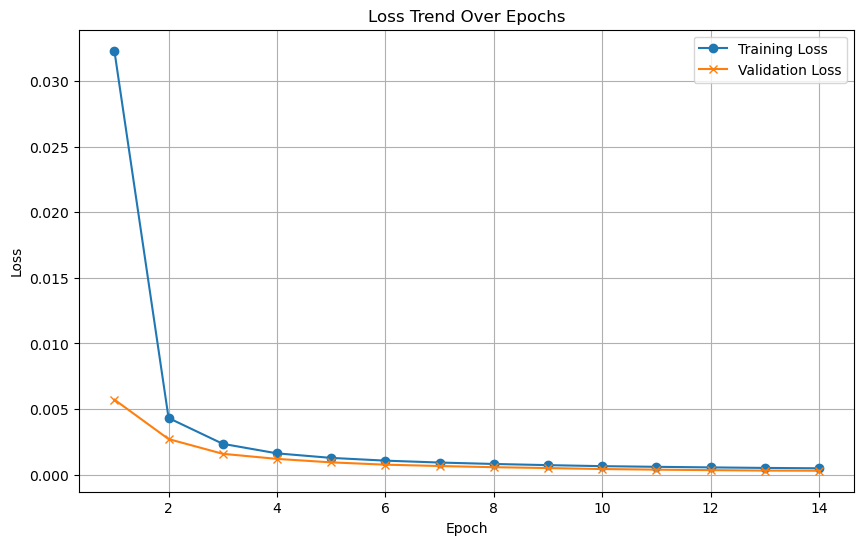

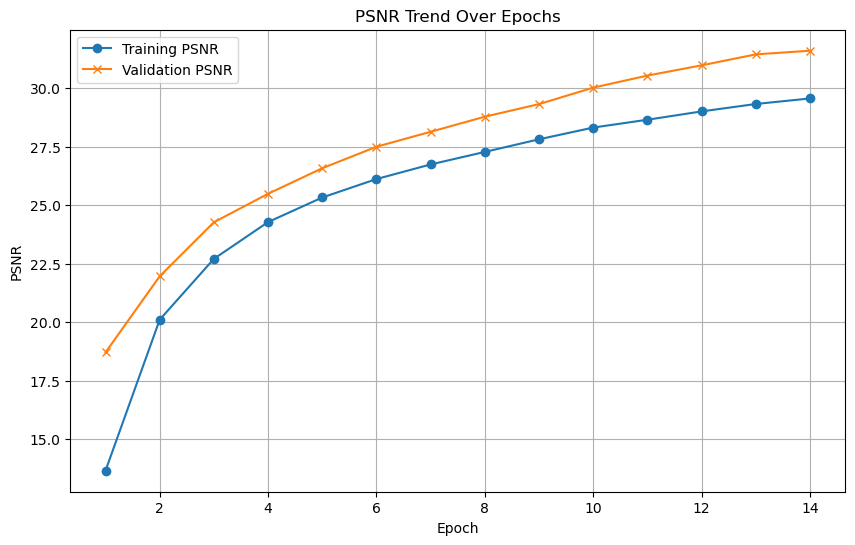

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/579 for test dataset.


    Processed batch 101/579 for test dataset.


    Processed batch 201/579 for test dataset.


    Processed batch 301/579 for test dataset.


    Processed batch 401/579 for test dataset.


    Processed batch 501/579 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2150
    Validation Batch [1/1], Loss: 2.2009
Validation Loss: 2.2009, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2009. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1505
    Validation Batch [1/1], Loss: 2.2008
Validation Loss: 2.2008, Validation Accuracy: 11.11%
Validation loss improved from 2.2009 to 2.2008. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.0734
    Validation Batch [1/1], Loss: 2.2008
Validation Loss: 2.2008, Validation Accuracy: 11.11%
Validation loss improved from 2.2008 to 2.2008. Saving model...

LOG: Epoch [4/1000] - Training


Epoch [4/1000] completed, Average Training Loss: 2.0434
    Validation Batch [1/1], Loss: 2.2007
Validation Loss: 2.2007, Validation Accuracy: 11.11%
Validation loss improved from 2.2008 to 2.2007. Saving model...

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Training Loss: 2.0212
    Validation Batch [1/1], Loss: 2.2007
Validation Loss: 2.2007, Validation Accuracy: 11.11%
Validation loss improved from 2.2007 to 2.2007. Saving model...

LOG: Epoch [6/1000] - Training
Epoch [6/1000] completed, Average Training Loss: 1.9874
    Validation Batch [1/1], Loss: 2.2006
Validation Loss: 2.2006, Validation Accuracy: 11.11%
Validation loss improved from 2.2007 to 2.2006. Saving model...

LOG: Epoch [7/1000] - Training
Epoch [7/1000] completed, Average Training Loss: 1.9790
    Validation Batch [1/1], Loss: 2.2006
Validation Loss: 2.2006, Validation Accuracy: 11.11%
Validation loss improved from 2.2006 to 2.2006. Saving model...

LOG: Epoch [8/1000] - Training
Epoch [8/1000] c

    Validation Batch [1/1], Loss: 2.1160
Validation Loss: 2.1160, Validation Accuracy: 28.89%
Validation loss improved from 2.1273 to 2.1160. Saving model...

LOG: Epoch [33/1000] - Training
Epoch [33/1000] completed, Average Training Loss: 1.6649
    Validation Batch [1/1], Loss: 2.1033
Validation Loss: 2.1033, Validation Accuracy: 33.33%
Validation loss improved from 2.1160 to 2.1033. Saving model...

LOG: Epoch [34/1000] - Training
Epoch [34/1000] completed, Average Training Loss: 1.6881
    Validation Batch [1/1], Loss: 2.0894
Validation Loss: 2.0894, Validation Accuracy: 42.22%
Validation loss improved from 2.1033 to 2.0894. Saving model...

LOG: Epoch [35/1000] - Training
Epoch [35/1000] completed, Average Training Loss: 1.6344
    Validation Batch [1/1], Loss: 2.0736
Validation Loss: 2.0736, Validation Accuracy: 42.22%
Validation loss improved from 2.0894 to 2.0736. Saving model...

LOG: Epoch [36/1000] - Training
Epoch [36/1000] completed, Average Training Loss: 1.6634
    Vali

    Validation Batch [1/1], Loss: 1.5969
Validation Loss: 1.5969, Validation Accuracy: 71.11%
Validation loss improved from 1.6093 to 1.5969. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 1.4217
    Validation Batch [1/1], Loss: 1.5852
Validation Loss: 1.5852, Validation Accuracy: 71.11%
Validation loss improved from 1.5969 to 1.5852. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 1.3998
    Validation Batch [1/1], Loss: 1.5730
Validation Loss: 1.5730, Validation Accuracy: 71.11%
Validation loss improved from 1.5852 to 1.5730. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [65/1000] completed, Average Training Loss: 1.4435
    Validation Batch [1/1], Loss: 1.5613
Validation Loss: 1.5613, Validation Accuracy: 73.33%
Validation loss improved from 1.5730 to 1.5613. Saving model...

LOG: Epoch [66/1000] - Training
Epoch [66/1000] completed, Average Training Loss: 1.4131
    Vali

Epoch [92/1000] completed, Average Training Loss: 1.1555
    Validation Batch [1/1], Loss: 1.3187
Validation Loss: 1.3187, Validation Accuracy: 82.22%
Validation loss improved from 1.3265 to 1.3187. Saving model...

LOG: Epoch [93/1000] - Training
Epoch [93/1000] completed, Average Training Loss: 1.2279
    Validation Batch [1/1], Loss: 1.3112
Validation Loss: 1.3112, Validation Accuracy: 82.22%
Validation loss improved from 1.3187 to 1.3112. Saving model...

LOG: Epoch [94/1000] - Training
Epoch [94/1000] completed, Average Training Loss: 1.1695
    Validation Batch [1/1], Loss: 1.3024
Validation Loss: 1.3024, Validation Accuracy: 80.00%
Validation loss improved from 1.3112 to 1.3024. Saving model...

LOG: Epoch [95/1000] - Training
Epoch [95/1000] completed, Average Training Loss: 1.1043
    Validation Batch [1/1], Loss: 1.2948
Validation Loss: 1.2948, Validation Accuracy: 82.22%
Validation loss improved from 1.3024 to 1.2948. Saving model...

LOG: Epoch [96/1000] - Training
Epoch [9

Epoch [122/1000] completed, Average Training Loss: 0.9913
    Validation Batch [1/1], Loss: 1.1115
Validation Loss: 1.1115, Validation Accuracy: 84.44%
Validation loss improved from 1.1181 to 1.1115. Saving model...

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 0.9491
    Validation Batch [1/1], Loss: 1.1071
Validation Loss: 1.1071, Validation Accuracy: 84.44%
Validation loss improved from 1.1115 to 1.1071. Saving model...

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 0.9133
    Validation Batch [1/1], Loss: 1.1045
Validation Loss: 1.1045, Validation Accuracy: 84.44%
Validation loss improved from 1.1071 to 1.1045. Saving model...

LOG: Epoch [125/1000] - Training
Epoch [125/1000] completed, Average Training Loss: 0.9603
    Validation Batch [1/1], Loss: 1.0954
Validation Loss: 1.0954, Validation Accuracy: 84.44%
Validation loss improved from 1.1045 to 1.0954. Saving model...

LOG: Epoch [126/1000] - Training


    Validation Batch [1/1], Loss: 0.9034
Validation Loss: 0.9034, Validation Accuracy: 84.44%
Validation loss improved from 0.9099 to 0.9034. Saving model...

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 0.7764
    Validation Batch [1/1], Loss: 0.8961
Validation Loss: 0.8961, Validation Accuracy: 86.67%
Validation loss improved from 0.9034 to 0.8961. Saving model...

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Average Training Loss: 0.7457
    Validation Batch [1/1], Loss: 0.8877
Validation Loss: 0.8877, Validation Accuracy: 84.44%
Validation loss improved from 0.8961 to 0.8877. Saving model...

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Average Training Loss: 0.7476
    Validation Batch [1/1], Loss: 0.8830
Validation Loss: 0.8830, Validation Accuracy: 86.67%
Validation loss improved from 0.8877 to 0.8830. Saving model...

LOG: Epoch [158/1000] - Training
Epoch [158/1000] completed, Average Training Loss: 0.7494


Epoch [186/1000] completed, Average Training Loss: 0.5939
    Validation Batch [1/1], Loss: 0.7609
Validation Loss: 0.7609, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 0.6092
    Validation Batch [1/1], Loss: 0.7401
Validation Loss: 0.7401, Validation Accuracy: 88.89%
Validation loss improved from 0.7475 to 0.7401. Saving model...

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 0.5967
    Validation Batch [1/1], Loss: 0.7196
Validation Loss: 0.7196, Validation Accuracy: 88.89%
Validation loss improved from 0.7401 to 0.7196. Saving model...

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 0.5753
    Validation Batch [1/1], Loss: 0.7177
Validation Loss: 0.7177, Validation Accuracy: 88.89%
Validation loss improved from 0.7196 to 0.7177. Saving model...

LOG: Epoch [190/1000] - Training
Epoch [190/1000

    Validation Batch [1/1], Loss: 0.6239
Validation Loss: 0.6239, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [217/1000] - Training
Epoch [217/1000] completed, Average Training Loss: 0.4436
    Validation Batch [1/1], Loss: 0.6124
Validation Loss: 0.6124, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [218/1000] - Training
Epoch [218/1000] completed, Average Training Loss: 0.4411
    Validation Batch [1/1], Loss: 0.6029
Validation Loss: 0.6029, Validation Accuracy: 88.89%
Validation loss improved from 0.6114 to 0.6029. Saving model...

LOG: Epoch [219/1000] - Training
Epoch [219/1000] completed, Average Training Loss: 0.4357
    Validation Batch [1/1], Loss: 0.5971
Validation Loss: 0.5971, Validation Accuracy: 88.89%
Validation loss improved from 0.6029 to 0.5971. Saving model...

LOG: Epoch [220/1000] - Training
Epoch [220/1000] completed, Average Training Loss: 0.4372
    Validation Batch [1/1], Lo

Epoch [246/1000] completed, Average Training Loss: 0.3474
    Validation Batch [1/1], Loss: 0.5251
Validation Loss: 0.5251, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [247/1000] - Training
Epoch [247/1000] completed, Average Training Loss: 0.3326
    Validation Batch [1/1], Loss: 0.5273
Validation Loss: 0.5273, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [248/1000] - Training
Epoch [248/1000] completed, Average Training Loss: 0.3380
    Validation Batch [1/1], Loss: 0.5248
Validation Loss: 0.5248, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [249/1000] - Training
Epoch [249/1000] completed, Average Training Loss: 0.3132
    Validation Batch [1/1], Loss: 0.5216
Validation Loss: 0.5216, Validation Accuracy: 88.89%
Validation loss improved from 0.5233 to 0.5216. Saving model...

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.4645
Validation Loss: 0.4645, Validation Accuracy: 88.89%
Validation loss improved from 0.4660 to 0.4645. Saving model...

LOG: Epoch [277/1000] - Training
Epoch [277/1000] completed, Average Training Loss: 0.2678
    Validation Batch [1/1], Loss: 0.4625
Validation Loss: 0.4625, Validation Accuracy: 91.11%
Validation loss improved from 0.4645 to 0.4625. Saving model...

LOG: Epoch [278/1000] - Training
Epoch [278/1000] completed, Average Training Loss: 0.2563
    Validation Batch [1/1], Loss: 0.4651
Validation Loss: 0.4651, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.2572
    Validation Batch [1/1], Loss: 0.4743
Validation Loss: 0.4743, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.2436
    Validation Batch [1/1], Lo

Epoch [307/1000] completed, Average Training Loss: 0.2032
    Validation Batch [1/1], Loss: 0.4392
Validation Loss: 0.4392, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.1739
    Validation Batch [1/1], Loss: 0.4435
Validation Loss: 0.4435, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.2042
    Validation Batch [1/1], Loss: 0.4369
Validation Loss: 0.4369, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training Loss: 0.2039
    Validation Batch [1/1], Loss: 0.4260
Validation Loss: 0.4260, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [311/1000] - Training
Epoch [311/1000] completed, Average Training Loss: 0.2275
 

Epoch [338/1000] completed, Average Training Loss: 0.1608
    Validation Batch [1/1], Loss: 0.4480
Validation Loss: 0.4480, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.1377
    Validation Batch [1/1], Loss: 0.3971
Validation Loss: 0.3971, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training Loss: 0.1602
    Validation Batch [1/1], Loss: 0.3787
Validation Loss: 0.3787, Validation Accuracy: 91.11%
Validation loss improved from 0.3961 to 0.3787. Saving model...

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training Loss: 0.1492
    Validation Batch [1/1], Loss: 0.3934
Validation Loss: 0.3934, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Trainin

Epoch [368/1000] completed, Average Training Loss: 0.1328
    Validation Batch [1/1], Loss: 0.4279
Validation Loss: 0.4279, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [369/1000] - Training
Epoch [369/1000] completed, Average Training Loss: 0.1350
    Validation Batch [1/1], Loss: 0.4002
Validation Loss: 0.4002, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [370/1000] - Training
Epoch [370/1000] completed, Average Training Loss: 0.1514
    Validation Batch [1/1], Loss: 0.3827
Validation Loss: 0.3827, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [371/1000] - Training
Epoch [371/1000] completed, Average Training Loss: 0.1323
    Validation Batch [1/1], Loss: 0.3761
Validation Loss: 0.3761, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [372/1000] - Training
Epoch [372/1000] completed, Average Training Loss: 0.156

Epoch [401/1000] completed, Average Training Loss: 0.1157
    Validation Batch [1/1], Loss: 0.3926
Validation Loss: 0.3926, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.1385
    Validation Batch [1/1], Loss: 0.3859
Validation Loss: 0.3859, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [403/1000] - Training
Epoch [403/1000] completed, Average Training Loss: 0.1251
    Validation Batch [1/1], Loss: 0.3759
Validation Loss: 0.3759, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [404/1000] - Training
Epoch [404/1000] completed, Average Training Loss: 0.1267
    Validation Batch [1/1], Loss: 0.3684
Validation Loss: 0.3684, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [405/1000] - Training
Epoch [405/1000] completed, Average Training Loss: 0.147

Epoch [433/1000] completed, Average Training Loss: 0.0780
    Validation Batch [1/1], Loss: 0.3479
Validation Loss: 0.3479, Validation Accuracy: 91.11%
Validation loss improved from 0.3608 to 0.3479. Saving model...

LOG: Epoch [434/1000] - Training
Epoch [434/1000] completed, Average Training Loss: 0.0729
    Validation Batch [1/1], Loss: 0.3396
Validation Loss: 0.3396, Validation Accuracy: 91.11%
Validation loss improved from 0.3479 to 0.3396. Saving model...

LOG: Epoch [435/1000] - Training
Epoch [435/1000] completed, Average Training Loss: 0.1193
    Validation Batch [1/1], Loss: 0.3372
Validation Loss: 0.3372, Validation Accuracy: 91.11%
Validation loss improved from 0.3396 to 0.3372. Saving model...

LOG: Epoch [436/1000] - Training
Epoch [436/1000] completed, Average Training Loss: 0.1182
    Validation Batch [1/1], Loss: 0.3543
Validation Loss: 0.3543, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [437/1000] - Training
Epoch [437/1000

Epoch [465/1000] completed, Average Training Loss: 0.0645
    Validation Batch [1/1], Loss: 0.4118
Validation Loss: 0.4118, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [466/1000] - Training
Epoch [466/1000] completed, Average Training Loss: 0.0752
    Validation Batch [1/1], Loss: 0.4079
Validation Loss: 0.4079, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [467/1000] - Training
Epoch [467/1000] completed, Average Training Loss: 0.0842
    Validation Batch [1/1], Loss: 0.4079
Validation Loss: 0.4079, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training Loss: 0.0772
    Validation Batch [1/1], Loss: 0.4067
Validation Loss: 0.4067, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [469/1000] - Training
Epoch [469/1000] completed, Average Training Loss: 0.059

Epoch [497/1000] completed, Average Training Loss: 0.0660
    Validation Batch [1/1], Loss: 0.3827
Validation Loss: 0.3827, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [498/1000] - Training
Epoch [498/1000] completed, Average Training Loss: 0.0479
    Validation Batch [1/1], Loss: 0.3892
Validation Loss: 0.3892, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [499/1000] - Training
Epoch [499/1000] completed, Average Training Loss: 0.0590
    Validation Batch [1/1], Loss: 0.3945
Validation Loss: 0.3945, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [500/1000] - Training
Epoch [500/1000] completed, Average Training Loss: 0.0647
    Validation Batch [1/1], Loss: 0.3968
Validation Loss: 0.3968, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training Loss: 0.073

Epoch [530/1000] completed, Average Training Loss: 0.0541
    Validation Batch [1/1], Loss: 0.3874
Validation Loss: 0.3874, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 95/100

LOG: Epoch [531/1000] - Training
Epoch [531/1000] completed, Average Training Loss: 0.0546
    Validation Batch [1/1], Loss: 0.3917
Validation Loss: 0.3917, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 96/100

LOG: Epoch [532/1000] - Training
Epoch [532/1000] completed, Average Training Loss: 0.0693
    Validation Batch [1/1], Loss: 0.4050
Validation Loss: 0.4050, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 97/100

LOG: Epoch [533/1000] - Training
Epoch [533/1000] completed, Average Training Loss: 0.0350
    Validation Batch [1/1], Loss: 0.4208
Validation Loss: 0.4208, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 98/100

LOG: Epoch [534/1000] - Training
Epoch [534/1000] completed, Average Training Loss: 0.059

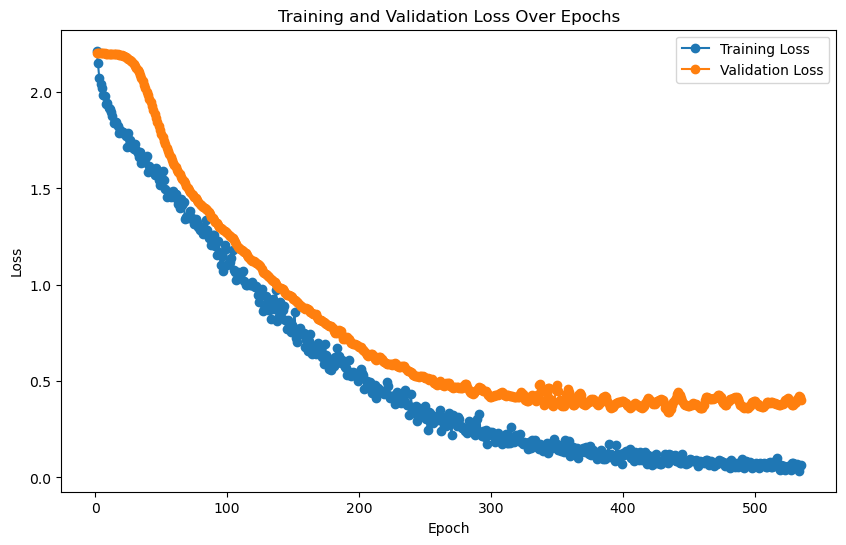

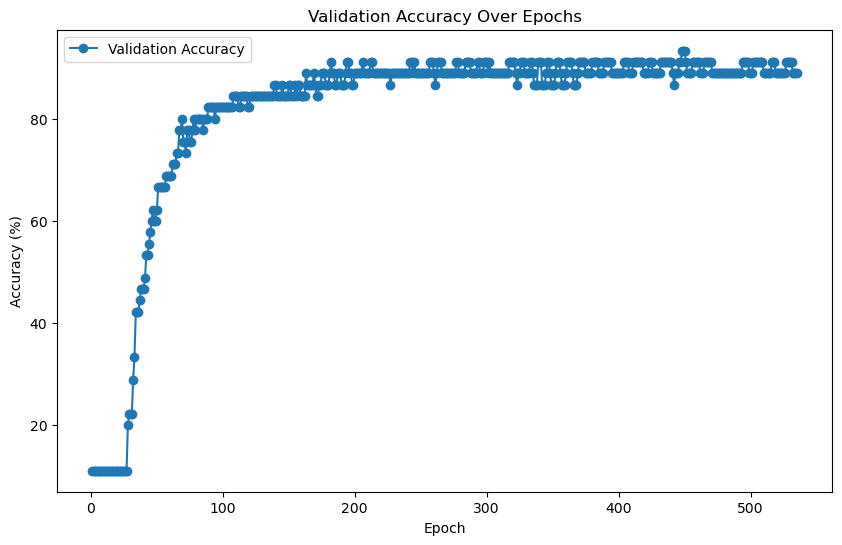


Evaluating on the test set...
    Test Batch [1/579], Loss: 0.1152



Final Test Loss: 0.2158, Test Accuracy: 93.56%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/579 for test dataset.
  Processed batch 20/579 for test dataset.
  Processed batch 30/579 for test dataset.


  Processed batch 40/579 for test dataset.
  Processed batch 50/579 for test dataset.
  Processed batch 60/579 for test dataset.
  Processed batch 70/579 for test dataset.


  Processed batch 80/579 for test dataset.
  Processed batch 90/579 for test dataset.
  Processed batch 100/579 for test dataset.
  Processed batch 110/579 for test dataset.
  Processed batch 120/579 for test dataset.


  Processed batch 130/579 for test dataset.
  Processed batch 140/579 for test dataset.
  Processed batch 150/579 for test dataset.
  Processed batch 160/579 for test dataset.
  Processed batch 170/579 for test dataset.


  Processed batch 180/579 for test dataset.
  Processed batch 190/579 for test dataset.
  Processed batch 200/579 for test dataset.
  Processed batch 210/579 for test dataset.
  Processed batch 220/579 for test dataset.


  Processed batch 230/579 for test dataset.
  Processed batch 240/579 for test dataset.
  Processed batch 250/579 for test dataset.
  Processed batch 260/579 for test dataset.


  Processed batch 270/579 for test dataset.
  Processed batch 280/579 for test dataset.
  Processed batch 290/579 for test dataset.
  Processed batch 300/579 for test dataset.
  Processed batch 310/579 for test dataset.


  Processed batch 320/579 for test dataset.
  Processed batch 330/579 for test dataset.
  Processed batch 340/579 for test dataset.
  Processed batch 350/579 for test dataset.


  Processed batch 360/579 for test dataset.
  Processed batch 370/579 for test dataset.
  Processed batch 380/579 for test dataset.
  Processed batch 390/579 for test dataset.
  Processed batch 400/579 for test dataset.


  Processed batch 410/579 for test dataset.
  Processed batch 420/579 for test dataset.
  Processed batch 430/579 for test dataset.
  Processed batch 440/579 for test dataset.


  Processed batch 450/579 for test dataset.
  Processed batch 460/579 for test dataset.
  Processed batch 470/579 for test dataset.
  Processed batch 480/579 for test dataset.
  Processed batch 490/579 for test dataset.


  Processed batch 500/579 for test dataset.
  Processed batch 510/579 for test dataset.
  Processed batch 520/579 for test dataset.
  Processed batch 530/579 for test dataset.
  Processed batch 540/579 for test dataset.


  Processed batch 550/579 for test dataset.
  Processed batch 560/579 for test dataset.
  Processed batch 570/579 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148062 samples with 64 features each
LOG: Labels shape: (148062,)

LOG: Training features shape: (45, 64), Training labels shape: (45,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (148062, 64), Test labels shape: (148062,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 80.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.71      1.00      0.83         5
           2       1.00      0.60      0.75         5
           3       0.50      0.80      0.62         5
           4       0.50      0.40      0.44         5
           5       0.83      1.00      0.91         5
           6       1.00      1.00      1.00         5
           7       1.00      0.60      0.75         5
           8       1.00      

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 148062 samples with 64 features each
LOG: Labels shape: (148062,)
Train reps shape: (45, 64)
Train labels shape: (45,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (148062, 64)
Test labels shape: (148062,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 3.0704  |  Val Loss: 2.7195
Validation loss improved from inf to 2.7195.
[Epoch 2/1000] Train Loss: 2.7444  |  Val Loss: 2.4966
Validation loss improved from 2.7195 to 2.4966.
[Epoch 3/1000] Train Loss: 2.5018  |  Val Loss: 2.3328
Validation loss improved from 2.4966 to 2.3328.
[Epoch 4/1000] Train Loss: 2.3177  |  Val Loss: 2.2031
Validation loss improved from 2.3328 to 2.2031.
[Epoch 5/1000] Train Loss: 2.1744  |  Val Loss: 2.1002
Validation loss improved from 2.2031 to 2.1002.
[Epoch 6/1000] Train Loss: 2.0610  |  Val Loss: 2.0156
Validation loss improved from 2.1002 to 2.0156.
[Epoch 7/1000] Train Loss: 1.9751  |  Val Loss: 1.9449
Validation loss improved from 2.0156 to 1.9449.
[Epoch 8/1000] Train Loss: 1.9046  |  Val Loss: 1.8916
Validation loss improved from 1.9449 to 1.8916.
[Epoch 9/1000] Train Loss: 1.8475  |  Val Loss: 1.8454
Validation loss improved from 1.8916 to 1.8454.
[Epoch 10/1000] Train Loss: 1.7982  |  Val Loss: 1.8070
Validation loss impr

[Epoch 76/1000] Train Loss: 0.2345  |  Val Loss: 0.5204
Validation loss improved from 0.5259 to 0.5204.
[Epoch 77/1000] Train Loss: 0.2255  |  Val Loss: 0.5145
Validation loss improved from 0.5204 to 0.5145.
[Epoch 78/1000] Train Loss: 0.2168  |  Val Loss: 0.5090
Validation loss improved from 0.5145 to 0.5090.
[Epoch 79/1000] Train Loss: 0.2084  |  Val Loss: 0.5046
Validation loss improved from 0.5090 to 0.5046.
[Epoch 80/1000] Train Loss: 0.2002  |  Val Loss: 0.5007
Validation loss improved from 0.5046 to 0.5007.
[Epoch 81/1000] Train Loss: 0.1924  |  Val Loss: 0.4978
Validation loss improved from 0.5007 to 0.4978.
[Epoch 82/1000] Train Loss: 0.1849  |  Val Loss: 0.4943
Validation loss improved from 0.4978 to 0.4943.
[Epoch 83/1000] Train Loss: 0.1779  |  Val Loss: 0.4915
Validation loss improved from 0.4943 to 0.4915.
[Epoch 84/1000] Train Loss: 0.1714  |  Val Loss: 0.4901
Validation loss improved from 0.4915 to 0.4901.
[Epoch 85/1000] Train Loss: 0.1653  |  Val Loss: 0.4896
Validati

[Epoch 153/1000] Train Loss: 0.0283  |  Val Loss: 0.5758
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 154/1000] Train Loss: 0.0277  |  Val Loss: 0.5782
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 155/1000] Train Loss: 0.0272  |  Val Loss: 0.5801
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 156/1000] Train Loss: 0.0267  |  Val Loss: 0.5806
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 157/1000] Train Loss: 0.0262  |  Val Loss: 0.5821
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 158/1000] Train Loss: 0.0256  |  Val Loss: 0.5850
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 159/1000] Train Loss: 0.0252  |  Val Loss: 0.5871
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 160/1000] Train Loss: 0.0247  |  Val Loss: 0.5879
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 161/1000] Train Loss: 0.0242  |  Val Loss: 0.5873
!! Validation loss did NOT improve !! Patience:

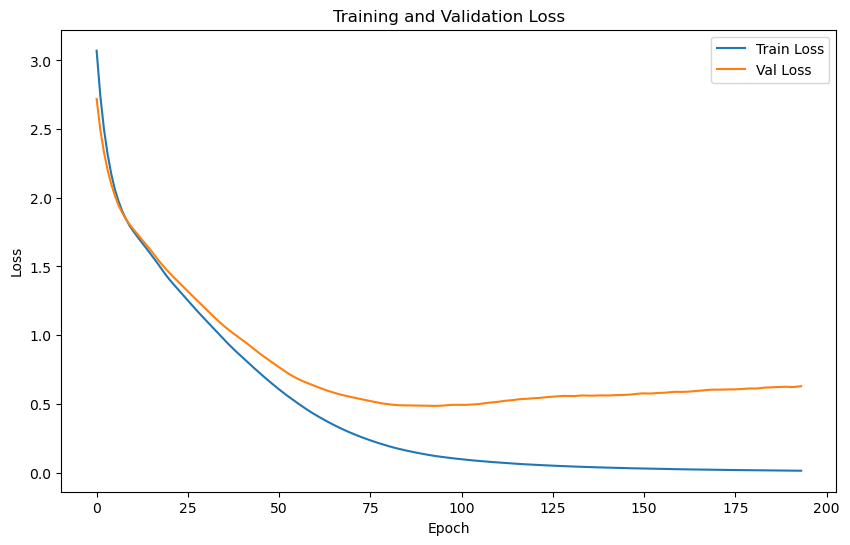

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.4221 | Test Accuracy: 87.27%


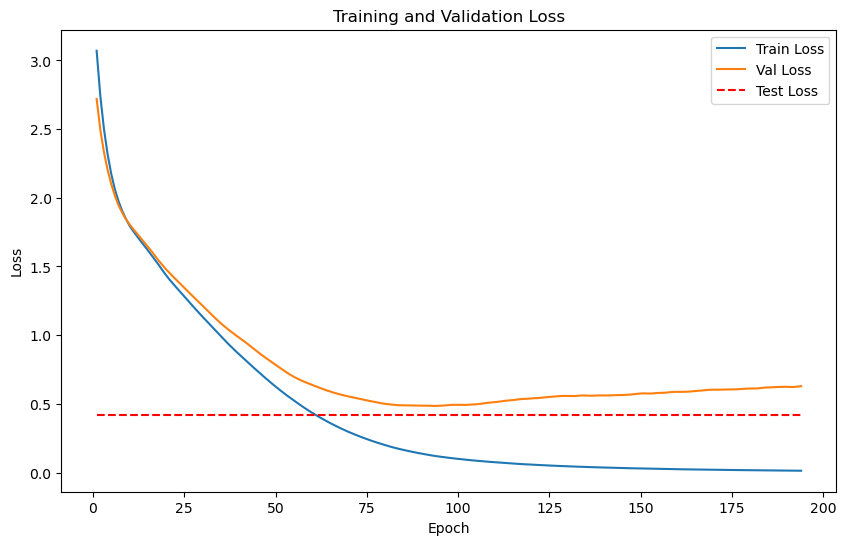

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148062 samples with 64 features each
LOG: Labels shape: (148062,)


Train embeddings shape: (45, 64), 
Train labels shape: (45,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (148062, 64), 
Test labels shape: (148062,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Training batch size: 45


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.1952
Epoch [1/2000], Avg Train Loss: 8.1952
Epoch [1/2000], Avg Val Loss: 3.7597
Validation loss improved from inf to 3.7597. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.1545
Epoch [2/2000], Avg Train Loss: 8.1545
Epoch [2/2000], Avg Val Loss: 3.7264
Validation loss improved from 3.7597 to 3.7264. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.2784
Epoch [3/2000], Avg Train Loss: 8.2784
Epoch [3/2000], Avg Val Loss: 3.6940
Validation loss improved from 3.7264 to 3.6940. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.9676
Epoch [4/2000], Avg Train Loss: 7.9676
Epoch [4/2000], Avg Val Loss: 3.6625
Validation loss improved from 3.6940 to 3.6625. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.1028
Epoch [5/2000], Avg Train Loss: 8.1028
Epoch [5/2000], Avg Val Loss: 3.6322
Validation loss improved from 3.6625 to 3.6322. Saving mode

    Batch [1/1], Train Loss: 7.4031
Epoch [12/2000], Avg Train Loss: 7.4031
Epoch [12/2000], Avg Val Loss: 3.4394
Validation loss improved from 3.4651 to 3.4394. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 7.3672
Epoch [13/2000], Avg Train Loss: 7.3672
Epoch [13/2000], Avg Val Loss: 3.4144
Validation loss improved from 3.4394 to 3.4144. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 7.6467
Epoch [14/2000], Avg Train Loss: 7.6467
Epoch [14/2000], Avg Val Loss: 3.3902
Validation loss improved from 3.4144 to 3.3902. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 7.5839
Epoch [15/2000], Avg Train Loss: 7.5839
Epoch [15/2000], Avg Val Loss: 3.3666
Validation loss improved from 3.3902 to 3.3666. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 7.4044
Epoch [16/2000], Avg Train Loss: 7.4044
Epoch [16/2000], Avg Val Loss: 3.3438
Validation loss improved from 3.3666 to 3.

    Batch [1/1], Train Loss: 5.7064
Epoch [49/2000], Avg Train Loss: 5.7064
Epoch [49/2000], Avg Val Loss: 2.8759
Validation loss improved from 2.8839 to 2.8759. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 5.5778
Epoch [50/2000], Avg Train Loss: 5.5778
Epoch [50/2000], Avg Val Loss: 2.8683
Validation loss improved from 2.8759 to 2.8683. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 5.6763
Epoch [51/2000], Avg Train Loss: 5.6763
Epoch [51/2000], Avg Val Loss: 2.8608
Validation loss improved from 2.8683 to 2.8608. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 5.6202
Epoch [52/2000], Avg Train Loss: 5.6202
Epoch [52/2000], Avg Val Loss: 2.8536
Validation loss improved from 2.8608 to 2.8536. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 5.4865
Epoch [53/2000], Avg Train Loss: 5.4865
Epoch [53/2000], Avg Val Loss: 2.8467
Validation loss improved from 2.8536 to 2.

Epoch [61/2000], Avg Val Loss: 2.7992
Validation loss improved from 2.8045 to 2.7992. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 4.9217
Epoch [62/2000], Avg Train Loss: 4.9217
Epoch [62/2000], Avg Val Loss: 2.7941
Validation loss improved from 2.7992 to 2.7941. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 5.4264
Epoch [63/2000], Avg Train Loss: 5.4264
Epoch [63/2000], Avg Val Loss: 2.7890
Validation loss improved from 2.7941 to 2.7890. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 4.9599
Epoch [64/2000], Avg Train Loss: 4.9599
Epoch [64/2000], Avg Val Loss: 2.7842
Validation loss improved from 2.7890 to 2.7842. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 4.8795
Epoch [65/2000], Avg Train Loss: 4.8795
Epoch [65/2000], Avg Val Loss: 2.7795
Validation loss improved from 2.7842 to 2.7795. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.4416
Epoch [93/2000], Avg Train Loss: 4.4416
Epoch [93/2000], Avg Val Loss: 2.6965
Validation loss improved from 2.6985 to 2.6965. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 4.4734
Epoch [94/2000], Avg Train Loss: 4.4734
Epoch [94/2000], Avg Val Loss: 2.6947
Validation loss improved from 2.6965 to 2.6947. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 3.9706
Epoch [95/2000], Avg Train Loss: 3.9706
Epoch [95/2000], Avg Val Loss: 2.6929
Validation loss improved from 2.6947 to 2.6929. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 4.3944
Epoch [96/2000], Avg Train Loss: 4.3944
Epoch [96/2000], Avg Val Loss: 2.6911
Validation loss improved from 2.6929 to 2.6911. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 4.2739
Epoch [97/2000], Avg Train Loss: 4.2739
Epoch [97/2000], Avg Val Loss: 2.6894
Validation loss improved from 2.6911 to 2.

    Batch [1/1], Train Loss: 4.2125
Epoch [106/2000], Avg Train Loss: 4.2125
Epoch [106/2000], Avg Val Loss: 2.6761
Validation loss improved from 2.6774 to 2.6761. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 3.9331
Epoch [107/2000], Avg Train Loss: 3.9331
Epoch [107/2000], Avg Val Loss: 2.6747
Validation loss improved from 2.6761 to 2.6747. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 3.9983
Epoch [108/2000], Avg Train Loss: 3.9983
Epoch [108/2000], Avg Val Loss: 2.6734
Validation loss improved from 2.6747 to 2.6734. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 4.1159
Epoch [109/2000], Avg Train Loss: 4.1159
Epoch [109/2000], Avg Val Loss: 2.6721
Validation loss improved from 2.6734 to 2.6721. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 3.8586
Epoch [110/2000], Avg Train Loss: 3.8586
Epoch [110/2000], Avg Val Loss: 2.6708
Validation loss improved fro

Epoch [135/2000], Avg Val Loss: 2.6485
Validation loss improved from 2.6492 to 2.6485. Saving model...

LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 3.6545
Epoch [136/2000], Avg Train Loss: 3.6545
Epoch [136/2000], Avg Val Loss: 2.6478
Validation loss improved from 2.6485 to 2.6478. Saving model...

LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 3.7540
Epoch [137/2000], Avg Train Loss: 3.7540
Epoch [137/2000], Avg Val Loss: 2.6471
Validation loss improved from 2.6478 to 2.6471. Saving model...

LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 3.6632
Epoch [138/2000], Avg Train Loss: 3.6632
Epoch [138/2000], Avg Val Loss: 2.6464
Validation loss improved from 2.6471 to 2.6464. Saving model...

LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 3.6863
Epoch [139/2000], Avg Train Loss: 3.6863
Epoch [139/2000], Avg Val Loss: 2.6458
Validation loss improved from 2.6464 to 2.6458. Saving model...

LOG: Epoch [140/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.6238
Epoch [149/2000], Avg Train Loss: 3.6238
Epoch [149/2000], Avg Val Loss: 2.6402
Validation loss improved from 2.6407 to 2.6402. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 3.5836
Epoch [150/2000], Avg Train Loss: 3.5836
Epoch [150/2000], Avg Val Loss: 2.6397
Validation loss improved from 2.6402 to 2.6397. Saving model...

LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 3.7157
Epoch [151/2000], Avg Train Loss: 3.7157
Epoch [151/2000], Avg Val Loss: 2.6392
Validation loss improved from 2.6397 to 2.6392. Saving model...

LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 3.8678
Epoch [152/2000], Avg Train Loss: 3.8678
Epoch [152/2000], Avg Val Loss: 2.6387
Validation loss improved from 2.6392 to 2.6387. Saving model...

LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 3.4906
Epoch [153/2000], Avg Train Loss: 3.4906
Epoch [153/2000], Avg Val Loss: 2.6382
Validation loss improved fro

Epoch [174/2000], Avg Val Loss: 2.6281
Validation loss improved from 2.6285 to 2.6281. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 3.4843
Epoch [175/2000], Avg Train Loss: 3.4843
Epoch [175/2000], Avg Val Loss: 2.6276
Validation loss improved from 2.6281 to 2.6276. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 3.3941
Epoch [176/2000], Avg Train Loss: 3.3941
Epoch [176/2000], Avg Val Loss: 2.6271
Validation loss improved from 2.6276 to 2.6271. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 3.3514
Epoch [177/2000], Avg Train Loss: 3.3514
Epoch [177/2000], Avg Val Loss: 2.6266
Validation loss improved from 2.6271 to 2.6266. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 3.5119
Epoch [178/2000], Avg Train Loss: 3.5119
Epoch [178/2000], Avg Val Loss: 2.6260
Validation loss improved from 2.6266 to 2.6260. Saving model...

LOG: Epoch [179/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.1769
Epoch [193/2000], Avg Train Loss: 3.1769
Epoch [193/2000], Avg Val Loss: 2.6186
Validation loss improved from 2.6191 to 2.6186. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 3.2785
Epoch [194/2000], Avg Train Loss: 3.2785
Epoch [194/2000], Avg Val Loss: 2.6181
Validation loss improved from 2.6186 to 2.6181. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 3.3134
Epoch [195/2000], Avg Train Loss: 3.3134
Epoch [195/2000], Avg Val Loss: 2.6176
Validation loss improved from 2.6181 to 2.6176. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 3.4050
Epoch [196/2000], Avg Train Loss: 3.4050
Epoch [196/2000], Avg Val Loss: 2.6172
Validation loss improved from 2.6176 to 2.6172. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 3.2485
Epoch [197/2000], Avg Train Loss: 3.2485
Epoch [197/2000], Avg Val Loss: 2.6167
Validation loss improved fro

Epoch [217/2000], Avg Val Loss: 2.6078
Validation loss improved from 2.6082 to 2.6078. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 3.2364
Epoch [218/2000], Avg Train Loss: 3.2364
Epoch [218/2000], Avg Val Loss: 2.6074
Validation loss improved from 2.6078 to 2.6074. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 3.1942
Epoch [219/2000], Avg Train Loss: 3.1942
Epoch [219/2000], Avg Val Loss: 2.6070
Validation loss improved from 2.6074 to 2.6070. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 3.2895
Epoch [220/2000], Avg Train Loss: 3.2895
Epoch [220/2000], Avg Val Loss: 2.6065
Validation loss improved from 2.6070 to 2.6065. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 3.3250
Epoch [221/2000], Avg Train Loss: 3.3250
Epoch [221/2000], Avg Val Loss: 2.6061
Validation loss improved from 2.6065 to 2.6061. Saving model...

LOG: Epoch [222/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.0435
Epoch [237/2000], Avg Train Loss: 3.0435
Epoch [237/2000], Avg Val Loss: 2.5985
Validation loss improved from 2.5991 to 2.5985. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 3.2245
Epoch [238/2000], Avg Train Loss: 3.2245
Epoch [238/2000], Avg Val Loss: 2.5980
Validation loss improved from 2.5985 to 2.5980. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 3.1504
Epoch [239/2000], Avg Train Loss: 3.1504
Epoch [239/2000], Avg Val Loss: 2.5975
Validation loss improved from 2.5980 to 2.5975. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 3.2130
Epoch [240/2000], Avg Train Loss: 3.2130
Epoch [240/2000], Avg Val Loss: 2.5969
Validation loss improved from 2.5975 to 2.5969. Saving model...

LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 3.1105
Epoch [241/2000], Avg Train Loss: 3.1105
Epoch [241/2000], Avg Val Loss: 2.5964
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1000
Epoch [260/2000], Avg Train Loss: 3.1000
Epoch [260/2000], Avg Val Loss: 2.5853
Validation loss improved from 2.5860 to 2.5853. Saving model...

LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 3.1115
Epoch [261/2000], Avg Train Loss: 3.1115
Epoch [261/2000], Avg Val Loss: 2.5847
Validation loss improved from 2.5853 to 2.5847. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 3.0929
Epoch [262/2000], Avg Train Loss: 3.0929
Epoch [262/2000], Avg Val Loss: 2.5841
Validation loss improved from 2.5847 to 2.5841. Saving model...

LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 3.0867
Epoch [263/2000], Avg Train Loss: 3.0867
Epoch [263/2000], Avg Val Loss: 2.5835
Validation loss improved from 2.5841 to 2.5835. Saving model...

LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 3.1507
Epoch [264/2000], Avg Train Loss: 3.1507
Epoch [264/2000], Avg Val Loss: 2.5829
Validation loss improved fro

Epoch [281/2000], Avg Val Loss: 2.5736
Validation loss improved from 2.5742 to 2.5736. Saving model...

LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 3.1211
Epoch [282/2000], Avg Train Loss: 3.1211
Epoch [282/2000], Avg Val Loss: 2.5731
Validation loss improved from 2.5736 to 2.5731. Saving model...

LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 3.0789
Epoch [283/2000], Avg Train Loss: 3.0789
Epoch [283/2000], Avg Val Loss: 2.5726
Validation loss improved from 2.5731 to 2.5726. Saving model...

LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 3.0521
Epoch [284/2000], Avg Train Loss: 3.0521
Epoch [284/2000], Avg Val Loss: 2.5720
Validation loss improved from 2.5726 to 2.5720. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 3.1152
Epoch [285/2000], Avg Train Loss: 3.1152
Epoch [285/2000], Avg Val Loss: 2.5714
Validation loss improved from 2.5720 to 2.5714. Saving model...

LOG: Epoch [286/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.0865
Epoch [304/2000], Avg Train Loss: 3.0865
Epoch [304/2000], Avg Val Loss: 2.5606
Validation loss improved from 2.5612 to 2.5606. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 3.0013
Epoch [305/2000], Avg Train Loss: 3.0013
Epoch [305/2000], Avg Val Loss: 2.5600
Validation loss improved from 2.5606 to 2.5600. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 2.9440
Epoch [306/2000], Avg Train Loss: 2.9440
Epoch [306/2000], Avg Val Loss: 2.5594
Validation loss improved from 2.5600 to 2.5594. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 2.9894
Epoch [307/2000], Avg Train Loss: 2.9894
Epoch [307/2000], Avg Val Loss: 2.5587
Validation loss improved from 2.5594 to 2.5587. Saving model...

LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 3.0604
Epoch [308/2000], Avg Train Loss: 3.0604
Epoch [308/2000], Avg Val Loss: 2.5581
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9241
Epoch [326/2000], Avg Train Loss: 2.9241
Epoch [326/2000], Avg Val Loss: 2.5475
Validation loss improved from 2.5481 to 2.5475. Saving model...

LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 3.0328
Epoch [327/2000], Avg Train Loss: 3.0328
Epoch [327/2000], Avg Val Loss: 2.5469
Validation loss improved from 2.5475 to 2.5469. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 3.0059
Epoch [328/2000], Avg Train Loss: 3.0059
Epoch [328/2000], Avg Val Loss: 2.5464
Validation loss improved from 2.5469 to 2.5464. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 2.9257
Epoch [329/2000], Avg Train Loss: 2.9257
Epoch [329/2000], Avg Val Loss: 2.5458
Validation loss improved from 2.5464 to 2.5458. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 2.9240
Epoch [330/2000], Avg Train Loss: 2.9240
Epoch [330/2000], Avg Val Loss: 2.5452
Validation loss improved fro

Epoch [351/2000], Avg Val Loss: 2.5330
Validation loss improved from 2.5336 to 2.5330. Saving model...

LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 2.8740
Epoch [352/2000], Avg Train Loss: 2.8740
Epoch [352/2000], Avg Val Loss: 2.5325
Validation loss improved from 2.5330 to 2.5325. Saving model...

LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 2.8209
Epoch [353/2000], Avg Train Loss: 2.8209
Epoch [353/2000], Avg Val Loss: 2.5320
Validation loss improved from 2.5325 to 2.5320. Saving model...

LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 2.9591
Epoch [354/2000], Avg Train Loss: 2.9591
Epoch [354/2000], Avg Val Loss: 2.5314
Validation loss improved from 2.5320 to 2.5314. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 2.8590
Epoch [355/2000], Avg Train Loss: 2.8590
Epoch [355/2000], Avg Val Loss: 2.5309
Validation loss improved from 2.5314 to 2.5309. Saving model...

LOG: Epoch [356/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.8141
Epoch [378/2000], Avg Train Loss: 2.8141
Epoch [378/2000], Avg Val Loss: 2.5176
Validation loss improved from 2.5182 to 2.5176. Saving model...

LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 2.9150
Epoch [379/2000], Avg Train Loss: 2.9150
Epoch [379/2000], Avg Val Loss: 2.5170
Validation loss improved from 2.5176 to 2.5170. Saving model...

LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 2.8482
Epoch [380/2000], Avg Train Loss: 2.8482
Epoch [380/2000], Avg Val Loss: 2.5164
Validation loss improved from 2.5170 to 2.5164. Saving model...

LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 2.8230
Epoch [381/2000], Avg Train Loss: 2.8230
Epoch [381/2000], Avg Val Loss: 2.5158
Validation loss improved from 2.5164 to 2.5158. Saving model...

LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 2.9047
Epoch [382/2000], Avg Train Loss: 2.9047
Epoch [382/2000], Avg Val Loss: 2.5153
Validation loss improved fro

    Batch [1/1], Train Loss: 2.8770
Epoch [396/2000], Avg Train Loss: 2.8770
Epoch [396/2000], Avg Val Loss: 2.5074
Validation loss improved from 2.5080 to 2.5074. Saving model...

LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 2.7951
Epoch [397/2000], Avg Train Loss: 2.7951
Epoch [397/2000], Avg Val Loss: 2.5069
Validation loss improved from 2.5074 to 2.5069. Saving model...

LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 2.8255
Epoch [398/2000], Avg Train Loss: 2.8255
Epoch [398/2000], Avg Val Loss: 2.5063
Validation loss improved from 2.5069 to 2.5063. Saving model...

LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 2.7981
Epoch [399/2000], Avg Train Loss: 2.7981
Epoch [399/2000], Avg Val Loss: 2.5058
Validation loss improved from 2.5063 to 2.5058. Saving model...

LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 2.7626
Epoch [400/2000], Avg Train Loss: 2.7626
Epoch [400/2000], Avg Val Loss: 2.5052
Validation loss improved fro

    Batch [1/1], Train Loss: 2.8251
Epoch [422/2000], Avg Train Loss: 2.8251
Epoch [422/2000], Avg Val Loss: 2.4936
Validation loss improved from 2.4942 to 2.4936. Saving model...

LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 2.8031
Epoch [423/2000], Avg Train Loss: 2.8031
Epoch [423/2000], Avg Val Loss: 2.4931
Validation loss improved from 2.4936 to 2.4931. Saving model...

LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 2.7213
Epoch [424/2000], Avg Train Loss: 2.7213
Epoch [424/2000], Avg Val Loss: 2.4926
Validation loss improved from 2.4931 to 2.4926. Saving model...

LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 2.7655
Epoch [425/2000], Avg Train Loss: 2.7655
Epoch [425/2000], Avg Val Loss: 2.4921
Validation loss improved from 2.4926 to 2.4921. Saving model...

LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 2.7469
Epoch [426/2000], Avg Train Loss: 2.7469
Epoch [426/2000], Avg Val Loss: 2.4915
Validation loss improved fro

    Batch [1/1], Train Loss: 2.8073
Epoch [445/2000], Avg Train Loss: 2.8073
Epoch [445/2000], Avg Val Loss: 2.4817
Validation loss improved from 2.4823 to 2.4817. Saving model...

LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 2.7135
Epoch [446/2000], Avg Train Loss: 2.7135
Epoch [446/2000], Avg Val Loss: 2.4812
Validation loss improved from 2.4817 to 2.4812. Saving model...

LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 2.8044
Epoch [447/2000], Avg Train Loss: 2.8044
Epoch [447/2000], Avg Val Loss: 2.4807
Validation loss improved from 2.4812 to 2.4807. Saving model...

LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 2.7884
Epoch [448/2000], Avg Train Loss: 2.7884
Epoch [448/2000], Avg Val Loss: 2.4801
Validation loss improved from 2.4807 to 2.4801. Saving model...

LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 2.8030
Epoch [449/2000], Avg Train Loss: 2.8030
Epoch [449/2000], Avg Val Loss: 2.4796
Validation loss improved fro

Epoch [466/2000], Avg Val Loss: 2.4706
Validation loss improved from 2.4711 to 2.4706. Saving model...

LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 2.7098
Epoch [467/2000], Avg Train Loss: 2.7098
Epoch [467/2000], Avg Val Loss: 2.4701
Validation loss improved from 2.4706 to 2.4701. Saving model...

LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 2.6594
Epoch [468/2000], Avg Train Loss: 2.6594
Epoch [468/2000], Avg Val Loss: 2.4696
Validation loss improved from 2.4701 to 2.4696. Saving model...

LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 2.7156
Epoch [469/2000], Avg Train Loss: 2.7156
Epoch [469/2000], Avg Val Loss: 2.4691
Validation loss improved from 2.4696 to 2.4691. Saving model...

LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 2.6658
Epoch [470/2000], Avg Train Loss: 2.6658
Epoch [470/2000], Avg Val Loss: 2.4685
Validation loss improved from 2.4691 to 2.4685. Saving model...

LOG: Epoch [471/2000] - Training
    Bat

Epoch [489/2000], Avg Val Loss: 2.4591
Validation loss improved from 2.4596 to 2.4591. Saving model...

LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 2.6630
Epoch [490/2000], Avg Train Loss: 2.6630
Epoch [490/2000], Avg Val Loss: 2.4586
Validation loss improved from 2.4591 to 2.4586. Saving model...

LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 2.7130
Epoch [491/2000], Avg Train Loss: 2.7130
Epoch [491/2000], Avg Val Loss: 2.4581
Validation loss improved from 2.4586 to 2.4581. Saving model...

LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 2.6551
Epoch [492/2000], Avg Train Loss: 2.6551
Epoch [492/2000], Avg Val Loss: 2.4576
Validation loss improved from 2.4581 to 2.4576. Saving model...

LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 2.7876
Epoch [493/2000], Avg Train Loss: 2.7876
Epoch [493/2000], Avg Val Loss: 2.4571
Validation loss improved from 2.4576 to 2.4571. Saving model...

LOG: Epoch [494/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.6821
Epoch [517/2000], Avg Train Loss: 2.6821
Epoch [517/2000], Avg Val Loss: 2.4454
Validation loss improved from 2.4459 to 2.4454. Saving model...

LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 2.6427
Epoch [518/2000], Avg Train Loss: 2.6427
Epoch [518/2000], Avg Val Loss: 2.4449
Validation loss improved from 2.4454 to 2.4449. Saving model...

LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 2.7753
Epoch [519/2000], Avg Train Loss: 2.7753
Epoch [519/2000], Avg Val Loss: 2.4445
Validation loss improved from 2.4449 to 2.4445. Saving model...

LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 2.7056
Epoch [520/2000], Avg Train Loss: 2.7056
Epoch [520/2000], Avg Val Loss: 2.4440
Validation loss improved from 2.4445 to 2.4440. Saving model...

LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 2.6846
Epoch [521/2000], Avg Train Loss: 2.6846
Epoch [521/2000], Avg Val Loss: 2.4436
Validation loss improved fro

Epoch [536/2000], Avg Val Loss: 2.4370
Validation loss improved from 2.4374 to 2.4370. Saving model...

LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 2.6709
Epoch [537/2000], Avg Train Loss: 2.6709
Epoch [537/2000], Avg Val Loss: 2.4366
Validation loss improved from 2.4370 to 2.4366. Saving model...

LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 2.6938
Epoch [538/2000], Avg Train Loss: 2.6938
Epoch [538/2000], Avg Val Loss: 2.4361
Validation loss improved from 2.4366 to 2.4361. Saving model...

LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 2.6429
Epoch [539/2000], Avg Train Loss: 2.6429
Epoch [539/2000], Avg Val Loss: 2.4357
Validation loss improved from 2.4361 to 2.4357. Saving model...

LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 2.6403
Epoch [540/2000], Avg Train Loss: 2.6403
Epoch [540/2000], Avg Val Loss: 2.4353
Validation loss improved from 2.4357 to 2.4353. Saving model...

LOG: Epoch [541/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.5534
Epoch [563/2000], Avg Train Loss: 2.5534
Epoch [563/2000], Avg Val Loss: 2.4252
Validation loss improved from 2.4256 to 2.4252. Saving model...

LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 2.6487
Epoch [564/2000], Avg Train Loss: 2.6487
Epoch [564/2000], Avg Val Loss: 2.4248
Validation loss improved from 2.4252 to 2.4248. Saving model...

LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 2.7136
Epoch [565/2000], Avg Train Loss: 2.7136
Epoch [565/2000], Avg Val Loss: 2.4243
Validation loss improved from 2.4248 to 2.4243. Saving model...

LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 2.5992
Epoch [566/2000], Avg Train Loss: 2.5992
Epoch [566/2000], Avg Val Loss: 2.4239
Validation loss improved from 2.4243 to 2.4239. Saving model...

LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 2.5956
Epoch [567/2000], Avg Train Loss: 2.5956
Epoch [567/2000], Avg Val Loss: 2.4234
Validation loss improved fro

    Batch [1/1], Train Loss: 2.6177
Epoch [582/2000], Avg Train Loss: 2.6177
Epoch [582/2000], Avg Val Loss: 2.4175
Validation loss improved from 2.4179 to 2.4175. Saving model...

LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 2.5786
Epoch [583/2000], Avg Train Loss: 2.5786
Epoch [583/2000], Avg Val Loss: 2.4171
Validation loss improved from 2.4175 to 2.4171. Saving model...

LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 2.6038
Epoch [584/2000], Avg Train Loss: 2.6038
Epoch [584/2000], Avg Val Loss: 2.4168
Validation loss improved from 2.4171 to 2.4168. Saving model...

LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 2.6219
Epoch [585/2000], Avg Train Loss: 2.6219
Epoch [585/2000], Avg Val Loss: 2.4164
Validation loss improved from 2.4168 to 2.4164. Saving model...

LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 2.6456
Epoch [586/2000], Avg Train Loss: 2.6456
Epoch [586/2000], Avg Val Loss: 2.4160
Validation loss improved fro

Epoch [608/2000], Avg Val Loss: 2.4069
Validation loss improved from 2.4074 to 2.4069. Saving model...

LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 2.5754
Epoch [609/2000], Avg Train Loss: 2.5754
Epoch [609/2000], Avg Val Loss: 2.4065
Validation loss improved from 2.4069 to 2.4065. Saving model...

LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 2.6736
Epoch [610/2000], Avg Train Loss: 2.6736
Epoch [610/2000], Avg Val Loss: 2.4061
Validation loss improved from 2.4065 to 2.4061. Saving model...

LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 2.6800
Epoch [611/2000], Avg Train Loss: 2.6800
Epoch [611/2000], Avg Val Loss: 2.4057
Validation loss improved from 2.4061 to 2.4057. Saving model...

LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 2.5550
Epoch [612/2000], Avg Train Loss: 2.5550
Epoch [612/2000], Avg Val Loss: 2.4053
Validation loss improved from 2.4057 to 2.4053. Saving model...

LOG: Epoch [613/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.5278
Epoch [630/2000], Avg Train Loss: 2.5278
Epoch [630/2000], Avg Val Loss: 2.3983
Validation loss improved from 2.3987 to 2.3983. Saving model...

LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 2.5115
Epoch [631/2000], Avg Train Loss: 2.5115
Epoch [631/2000], Avg Val Loss: 2.3979
Validation loss improved from 2.3983 to 2.3979. Saving model...

LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 2.5481
Epoch [632/2000], Avg Train Loss: 2.5481
Epoch [632/2000], Avg Val Loss: 2.3975
Validation loss improved from 2.3979 to 2.3975. Saving model...

LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 2.5905
Epoch [633/2000], Avg Train Loss: 2.5905
Epoch [633/2000], Avg Val Loss: 2.3972
Validation loss improved from 2.3975 to 2.3972. Saving model...

LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 2.4924
Epoch [634/2000], Avg Train Loss: 2.4924
Epoch [634/2000], Avg Val Loss: 2.3968
Validation loss improved fro

    Batch [1/1], Train Loss: 2.5271
Epoch [653/2000], Avg Train Loss: 2.5271
Epoch [653/2000], Avg Val Loss: 2.3895
Validation loss improved from 2.3900 to 2.3895. Saving model...

LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 2.5621
Epoch [654/2000], Avg Train Loss: 2.5621
Epoch [654/2000], Avg Val Loss: 2.3891
Validation loss improved from 2.3895 to 2.3891. Saving model...

LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 2.5504
Epoch [655/2000], Avg Train Loss: 2.5504
Epoch [655/2000], Avg Val Loss: 2.3887
Validation loss improved from 2.3891 to 2.3887. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 2.5520
Epoch [656/2000], Avg Train Loss: 2.5520
Epoch [656/2000], Avg Val Loss: 2.3883
Validation loss improved from 2.3887 to 2.3883. Saving model...

LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 2.5339
Epoch [657/2000], Avg Train Loss: 2.5339
Epoch [657/2000], Avg Val Loss: 2.3880
Validation loss improved fro

    Batch [1/1], Train Loss: 2.5326
Epoch [673/2000], Avg Train Loss: 2.5326
Epoch [673/2000], Avg Val Loss: 2.3821
Validation loss improved from 2.3825 to 2.3821. Saving model...

LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 2.5055
Epoch [674/2000], Avg Train Loss: 2.5055
Epoch [674/2000], Avg Val Loss: 2.3818
Validation loss improved from 2.3821 to 2.3818. Saving model...

LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 2.5190
Epoch [675/2000], Avg Train Loss: 2.5190
Epoch [675/2000], Avg Val Loss: 2.3814
Validation loss improved from 2.3818 to 2.3814. Saving model...

LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 2.4551
Epoch [676/2000], Avg Train Loss: 2.4551
Epoch [676/2000], Avg Val Loss: 2.3811
Validation loss improved from 2.3814 to 2.3811. Saving model...

LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 2.5288
Epoch [677/2000], Avg Train Loss: 2.5288
Epoch [677/2000], Avg Val Loss: 2.3808
Validation loss improved fro

    Batch [1/1], Train Loss: 2.5202
Epoch [699/2000], Avg Train Loss: 2.5202
Epoch [699/2000], Avg Val Loss: 2.3741
Validation loss improved from 2.3744 to 2.3741. Saving model...

LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 2.5023
Epoch [700/2000], Avg Train Loss: 2.5023
Epoch [700/2000], Avg Val Loss: 2.3738
Validation loss improved from 2.3741 to 2.3738. Saving model...

LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 2.5307
Epoch [701/2000], Avg Train Loss: 2.5307
Epoch [701/2000], Avg Val Loss: 2.3735
Validation loss improved from 2.3738 to 2.3735. Saving model...

LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 2.5721
Epoch [702/2000], Avg Train Loss: 2.5721
Epoch [702/2000], Avg Val Loss: 2.3733
Validation loss improved from 2.3735 to 2.3733. Saving model...

LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 2.5476
Epoch [703/2000], Avg Train Loss: 2.5476
Epoch [703/2000], Avg Val Loss: 2.3730
Validation loss improved fro

    Batch [1/1], Train Loss: 2.4419
Epoch [721/2000], Avg Train Loss: 2.4419
Epoch [721/2000], Avg Val Loss: 2.3676
Validation loss improved from 2.3679 to 2.3676. Saving model...

LOG: Epoch [722/2000] - Training
    Batch [1/1], Train Loss: 2.4723
Epoch [722/2000], Avg Train Loss: 2.4723
Epoch [722/2000], Avg Val Loss: 2.3673
Validation loss improved from 2.3676 to 2.3673. Saving model...

LOG: Epoch [723/2000] - Training
    Batch [1/1], Train Loss: 2.5012
Epoch [723/2000], Avg Train Loss: 2.5012
Epoch [723/2000], Avg Val Loss: 2.3670
Validation loss improved from 2.3673 to 2.3670. Saving model...

LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 2.4632
Epoch [724/2000], Avg Train Loss: 2.4632
Epoch [724/2000], Avg Val Loss: 2.3667
Validation loss improved from 2.3670 to 2.3667. Saving model...

LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 2.4981
Epoch [725/2000], Avg Train Loss: 2.4981
Epoch [725/2000], Avg Val Loss: 2.3664
Validation loss improved fro

    Batch [1/1], Train Loss: 2.5058
Epoch [742/2000], Avg Train Loss: 2.5058
Epoch [742/2000], Avg Val Loss: 2.3616
Validation loss improved from 2.3619 to 2.3616. Saving model...

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 2.4577
Epoch [743/2000], Avg Train Loss: 2.4577
Epoch [743/2000], Avg Val Loss: 2.3613
Validation loss improved from 2.3616 to 2.3613. Saving model...

LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 2.4836
Epoch [744/2000], Avg Train Loss: 2.4836
Epoch [744/2000], Avg Val Loss: 2.3610
Validation loss improved from 2.3613 to 2.3610. Saving model...

LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 2.4813
Epoch [745/2000], Avg Train Loss: 2.4813
Epoch [745/2000], Avg Val Loss: 2.3608
Validation loss improved from 2.3610 to 2.3608. Saving model...

LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 2.4325
Epoch [746/2000], Avg Train Loss: 2.4325
Epoch [746/2000], Avg Val Loss: 2.3606
Validation loss improved fro

    Batch [1/1], Train Loss: 2.4791
Epoch [762/2000], Avg Train Loss: 2.4791
Epoch [762/2000], Avg Val Loss: 2.3567
Validation loss improved from 2.3570 to 2.3567. Saving model...

LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 2.4546
Epoch [763/2000], Avg Train Loss: 2.4546
Epoch [763/2000], Avg Val Loss: 2.3564
Validation loss improved from 2.3567 to 2.3564. Saving model...

LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 2.4837
Epoch [764/2000], Avg Train Loss: 2.4837
Epoch [764/2000], Avg Val Loss: 2.3562
Validation loss improved from 2.3564 to 2.3562. Saving model...

LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 2.4165
Epoch [765/2000], Avg Train Loss: 2.4165
Epoch [765/2000], Avg Val Loss: 2.3559
Validation loss improved from 2.3562 to 2.3559. Saving model...

LOG: Epoch [766/2000] - Training
    Batch [1/1], Train Loss: 2.3861
Epoch [766/2000], Avg Train Loss: 2.3861
Epoch [766/2000], Avg Val Loss: 2.3556
Validation loss improved fro

    Batch [1/1], Train Loss: 2.4510
Epoch [786/2000], Avg Train Loss: 2.4510
Epoch [786/2000], Avg Val Loss: 2.3509
Validation loss improved from 2.3511 to 2.3509. Saving model...

LOG: Epoch [787/2000] - Training
    Batch [1/1], Train Loss: 2.4258
Epoch [787/2000], Avg Train Loss: 2.4258
Epoch [787/2000], Avg Val Loss: 2.3506
Validation loss improved from 2.3509 to 2.3506. Saving model...

LOG: Epoch [788/2000] - Training
    Batch [1/1], Train Loss: 2.3986
Epoch [788/2000], Avg Train Loss: 2.3986
Epoch [788/2000], Avg Val Loss: 2.3504
Validation loss improved from 2.3506 to 2.3504. Saving model...

LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 2.4481
Epoch [789/2000], Avg Train Loss: 2.4481
Epoch [789/2000], Avg Val Loss: 2.3501
Validation loss improved from 2.3504 to 2.3501. Saving model...

LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 2.4452
Epoch [790/2000], Avg Train Loss: 2.4452
Epoch [790/2000], Avg Val Loss: 2.3499
Validation loss improved fro

    Batch [1/1], Train Loss: 2.3902
Epoch [805/2000], Avg Train Loss: 2.3902
Epoch [805/2000], Avg Val Loss: 2.3465
Validation loss improved from 2.3467 to 2.3465. Saving model...

LOG: Epoch [806/2000] - Training
    Batch [1/1], Train Loss: 2.3789
Epoch [806/2000], Avg Train Loss: 2.3789
Epoch [806/2000], Avg Val Loss: 2.3462
Validation loss improved from 2.3465 to 2.3462. Saving model...

LOG: Epoch [807/2000] - Training
    Batch [1/1], Train Loss: 2.4443
Epoch [807/2000], Avg Train Loss: 2.4443
Epoch [807/2000], Avg Val Loss: 2.3460
Validation loss improved from 2.3462 to 2.3460. Saving model...

LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 2.4939
Epoch [808/2000], Avg Train Loss: 2.4939
Epoch [808/2000], Avg Val Loss: 2.3457
Validation loss improved from 2.3460 to 2.3457. Saving model...

LOG: Epoch [809/2000] - Training
    Batch [1/1], Train Loss: 2.4891
Epoch [809/2000], Avg Train Loss: 2.4891
Epoch [809/2000], Avg Val Loss: 2.3455
Validation loss improved fro

    Batch [1/1], Train Loss: 2.3929
Epoch [830/2000], Avg Train Loss: 2.3929
Epoch [830/2000], Avg Val Loss: 2.3408
Validation loss improved from 2.3410 to 2.3408. Saving model...

LOG: Epoch [831/2000] - Training
    Batch [1/1], Train Loss: 2.3492
Epoch [831/2000], Avg Train Loss: 2.3492
Epoch [831/2000], Avg Val Loss: 2.3406
Validation loss improved from 2.3408 to 2.3406. Saving model...

LOG: Epoch [832/2000] - Training
    Batch [1/1], Train Loss: 2.4591
Epoch [832/2000], Avg Train Loss: 2.4591
Epoch [832/2000], Avg Val Loss: 2.3404
Validation loss improved from 2.3406 to 2.3404. Saving model...

LOG: Epoch [833/2000] - Training
    Batch [1/1], Train Loss: 2.4522
Epoch [833/2000], Avg Train Loss: 2.4522
Epoch [833/2000], Avg Val Loss: 2.3402
Validation loss improved from 2.3404 to 2.3402. Saving model...

LOG: Epoch [834/2000] - Training
    Batch [1/1], Train Loss: 2.4108
Epoch [834/2000], Avg Train Loss: 2.4108
Epoch [834/2000], Avg Val Loss: 2.3401
Validation loss improved fro

    Batch [1/1], Train Loss: 2.4562
Epoch [849/2000], Avg Train Loss: 2.4562
Epoch [849/2000], Avg Val Loss: 2.3376
Validation loss improved from 2.3378 to 2.3376. Saving model...

LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 2.3630
Epoch [850/2000], Avg Train Loss: 2.3630
Epoch [850/2000], Avg Val Loss: 2.3374
Validation loss improved from 2.3376 to 2.3374. Saving model...

LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 2.4069
Epoch [851/2000], Avg Train Loss: 2.4069
Epoch [851/2000], Avg Val Loss: 2.3371
Validation loss improved from 2.3374 to 2.3371. Saving model...

LOG: Epoch [852/2000] - Training
    Batch [1/1], Train Loss: 2.3412
Epoch [852/2000], Avg Train Loss: 2.3412
Epoch [852/2000], Avg Val Loss: 2.3369
Validation loss improved from 2.3371 to 2.3369. Saving model...

LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 2.3344
Epoch [853/2000], Avg Train Loss: 2.3344
Epoch [853/2000], Avg Val Loss: 2.3366
Validation loss improved fro

Epoch [874/2000], Avg Val Loss: 2.3314
Validation loss improved from 2.3316 to 2.3314. Saving model...

LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 2.2735
Epoch [875/2000], Avg Train Loss: 2.2735
Epoch [875/2000], Avg Val Loss: 2.3312
Validation loss improved from 2.3314 to 2.3312. Saving model...

LOG: Epoch [876/2000] - Training
    Batch [1/1], Train Loss: 2.3538
Epoch [876/2000], Avg Train Loss: 2.3538
Epoch [876/2000], Avg Val Loss: 2.3310
Validation loss improved from 2.3312 to 2.3310. Saving model...

LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 2.3995
Epoch [877/2000], Avg Train Loss: 2.3995
Epoch [877/2000], Avg Val Loss: 2.3307
Validation loss improved from 2.3310 to 2.3307. Saving model...

LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 2.3728
Epoch [878/2000], Avg Train Loss: 2.3728
Epoch [878/2000], Avg Val Loss: 2.3305
Validation loss improved from 2.3307 to 2.3305. Saving model...

LOG: Epoch [879/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.4258
Epoch [891/2000], Avg Train Loss: 2.4258
Epoch [891/2000], Avg Val Loss: 2.3282
Validation loss improved from 2.3283 to 2.3282. Saving model...

LOG: Epoch [892/2000] - Training
    Batch [1/1], Train Loss: 2.3760
Epoch [892/2000], Avg Train Loss: 2.3760
Epoch [892/2000], Avg Val Loss: 2.3281
Validation loss improved from 2.3282 to 2.3281. Saving model...

LOG: Epoch [893/2000] - Training
    Batch [1/1], Train Loss: 2.3226
Epoch [893/2000], Avg Train Loss: 2.3226
Epoch [893/2000], Avg Val Loss: 2.3280
Validation loss improved from 2.3281 to 2.3280. Saving model...

LOG: Epoch [894/2000] - Training
    Batch [1/1], Train Loss: 2.3466
Epoch [894/2000], Avg Train Loss: 2.3466
Epoch [894/2000], Avg Val Loss: 2.3279
Validation loss improved from 2.3280 to 2.3279. Saving model...

LOG: Epoch [895/2000] - Training
    Batch [1/1], Train Loss: 2.3821
Epoch [895/2000], Avg Train Loss: 2.3821
Epoch [895/2000], Avg Val Loss: 2.3278
Validation loss improved fro

    Batch [1/1], Train Loss: 2.3707
Epoch [921/2000], Avg Train Loss: 2.3707
Epoch [921/2000], Avg Val Loss: 2.3242
Validation loss improved from 2.3242 to 2.3242. Saving model...

LOG: Epoch [922/2000] - Training
    Batch [1/1], Train Loss: 2.3196
Epoch [922/2000], Avg Train Loss: 2.3196
Epoch [922/2000], Avg Val Loss: 2.3241
Validation loss improved from 2.3242 to 2.3241. Saving model...

LOG: Epoch [923/2000] - Training
    Batch [1/1], Train Loss: 2.3300
Epoch [923/2000], Avg Train Loss: 2.3300
Epoch [923/2000], Avg Val Loss: 2.3240
Validation loss improved from 2.3241 to 2.3240. Saving model...

LOG: Epoch [924/2000] - Training
    Batch [1/1], Train Loss: 2.2913
Epoch [924/2000], Avg Train Loss: 2.2913
Epoch [924/2000], Avg Val Loss: 2.3238
Validation loss improved from 2.3240 to 2.3238. Saving model...

LOG: Epoch [925/2000] - Training
    Batch [1/1], Train Loss: 2.3537
Epoch [925/2000], Avg Train Loss: 2.3537
Epoch [925/2000], Avg Val Loss: 2.3237
Validation loss improved fro

    Batch [1/1], Train Loss: 2.3284
Epoch [940/2000], Avg Train Loss: 2.3284
Epoch [940/2000], Avg Val Loss: 2.3211
Validation loss improved from 2.3213 to 2.3211. Saving model...

LOG: Epoch [941/2000] - Training
    Batch [1/1], Train Loss: 2.3298
Epoch [941/2000], Avg Train Loss: 2.3298
Epoch [941/2000], Avg Val Loss: 2.3209
Validation loss improved from 2.3211 to 2.3209. Saving model...

LOG: Epoch [942/2000] - Training
    Batch [1/1], Train Loss: 2.3093
Epoch [942/2000], Avg Train Loss: 2.3093
Epoch [942/2000], Avg Val Loss: 2.3207
Validation loss improved from 2.3209 to 2.3207. Saving model...

LOG: Epoch [943/2000] - Training
    Batch [1/1], Train Loss: 2.2825
Epoch [943/2000], Avg Train Loss: 2.2825
Epoch [943/2000], Avg Val Loss: 2.3206
Validation loss improved from 2.3207 to 2.3206. Saving model...

LOG: Epoch [944/2000] - Training
    Batch [1/1], Train Loss: 2.3368
Epoch [944/2000], Avg Train Loss: 2.3368
Epoch [944/2000], Avg Val Loss: 2.3204
Validation loss improved fro

Epoch [967/2000], Avg Val Loss: 2.3174
Validation loss improved from 2.3175 to 2.3174. Saving model...

LOG: Epoch [968/2000] - Training
    Batch [1/1], Train Loss: 2.2682
Epoch [968/2000], Avg Train Loss: 2.2682
Epoch [968/2000], Avg Val Loss: 2.3172
Validation loss improved from 2.3174 to 2.3172. Saving model...

LOG: Epoch [969/2000] - Training
    Batch [1/1], Train Loss: 2.4029
Epoch [969/2000], Avg Train Loss: 2.4029
Epoch [969/2000], Avg Val Loss: 2.3170
Validation loss improved from 2.3172 to 2.3170. Saving model...

LOG: Epoch [970/2000] - Training
    Batch [1/1], Train Loss: 2.2715
Epoch [970/2000], Avg Train Loss: 2.2715
Epoch [970/2000], Avg Val Loss: 2.3169
Validation loss improved from 2.3170 to 2.3169. Saving model...

LOG: Epoch [971/2000] - Training
    Batch [1/1], Train Loss: 2.3817
Epoch [971/2000], Avg Train Loss: 2.3817
Epoch [971/2000], Avg Val Loss: 2.3167
Validation loss improved from 2.3169 to 2.3167. Saving model...

LOG: Epoch [972/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.3034
Epoch [983/2000], Avg Train Loss: 2.3034
Epoch [983/2000], Avg Val Loss: 2.3150
Validation loss improved from 2.3152 to 2.3150. Saving model...

LOG: Epoch [984/2000] - Training
    Batch [1/1], Train Loss: 2.4049
Epoch [984/2000], Avg Train Loss: 2.4049
Epoch [984/2000], Avg Val Loss: 2.3148
Validation loss improved from 2.3150 to 2.3148. Saving model...

LOG: Epoch [985/2000] - Training
    Batch [1/1], Train Loss: 2.2652
Epoch [985/2000], Avg Train Loss: 2.2652
Epoch [985/2000], Avg Val Loss: 2.3146
Validation loss improved from 2.3148 to 2.3146. Saving model...

LOG: Epoch [986/2000] - Training
    Batch [1/1], Train Loss: 2.2981
Epoch [986/2000], Avg Train Loss: 2.2981
Epoch [986/2000], Avg Val Loss: 2.3144
Validation loss improved from 2.3146 to 2.3144. Saving model...

LOG: Epoch [987/2000] - Training
    Batch [1/1], Train Loss: 2.2932
Epoch [987/2000], Avg Train Loss: 2.2932
Epoch [987/2000], Avg Val Loss: 2.3142
Validation loss improved fro

    Batch [1/1], Train Loss: 2.2594
Epoch [1017/2000], Avg Train Loss: 2.2594
Epoch [1017/2000], Avg Val Loss: 2.3106
Validation loss improved from 2.3107 to 2.3106. Saving model...

LOG: Epoch [1018/2000] - Training
    Batch [1/1], Train Loss: 2.2982
Epoch [1018/2000], Avg Train Loss: 2.2982
Epoch [1018/2000], Avg Val Loss: 2.3105
Validation loss improved from 2.3106 to 2.3105. Saving model...

LOG: Epoch [1019/2000] - Training
    Batch [1/1], Train Loss: 2.1990
Epoch [1019/2000], Avg Train Loss: 2.1990
Epoch [1019/2000], Avg Val Loss: 2.3104
Validation loss improved from 2.3105 to 2.3104. Saving model...

LOG: Epoch [1020/2000] - Training
    Batch [1/1], Train Loss: 2.3279
Epoch [1020/2000], Avg Train Loss: 2.3279
Epoch [1020/2000], Avg Val Loss: 2.3103
Validation loss improved from 2.3104 to 2.3103. Saving model...

LOG: Epoch [1021/2000] - Training
    Batch [1/1], Train Loss: 2.2530
Epoch [1021/2000], Avg Train Loss: 2.2530
Epoch [1021/2000], Avg Val Loss: 2.3101
Validation los

Epoch [1030/2000], Avg Val Loss: 2.3095
Validation loss improved from 2.3095 to 2.3095. Saving model...

LOG: Epoch [1031/2000] - Training
    Batch [1/1], Train Loss: 2.2890
Epoch [1031/2000], Avg Train Loss: 2.2890
Epoch [1031/2000], Avg Val Loss: 2.3095
Validation loss improved from 2.3095 to 2.3095. Saving model...

LOG: Epoch [1032/2000] - Training
    Batch [1/1], Train Loss: 2.2340
Epoch [1032/2000], Avg Train Loss: 2.2340
Epoch [1032/2000], Avg Val Loss: 2.3094
Validation loss improved from 2.3095 to 2.3094. Saving model...

LOG: Epoch [1033/2000] - Training
    Batch [1/1], Train Loss: 2.3050
Epoch [1033/2000], Avg Train Loss: 2.3050
Epoch [1033/2000], Avg Val Loss: 2.3093
Validation loss improved from 2.3094 to 2.3093. Saving model...

LOG: Epoch [1034/2000] - Training
    Batch [1/1], Train Loss: 2.2720
Epoch [1034/2000], Avg Train Loss: 2.2720
Epoch [1034/2000], Avg Val Loss: 2.3093
Validation loss improved from 2.3093 to 2.3093. Saving model...

LOG: Epoch [1035/2000] - Tr

    Batch [1/1], Train Loss: 2.2782
Epoch [1063/2000], Avg Train Loss: 2.2782
Epoch [1063/2000], Avg Val Loss: 2.3044
Validation loss improved from 2.3046 to 2.3044. Saving model...

LOG: Epoch [1064/2000] - Training
    Batch [1/1], Train Loss: 2.2286
Epoch [1064/2000], Avg Train Loss: 2.2286
Epoch [1064/2000], Avg Val Loss: 2.3043
Validation loss improved from 2.3044 to 2.3043. Saving model...

LOG: Epoch [1065/2000] - Training
    Batch [1/1], Train Loss: 2.2821
Epoch [1065/2000], Avg Train Loss: 2.2821
Epoch [1065/2000], Avg Val Loss: 2.3042
Validation loss improved from 2.3043 to 2.3042. Saving model...

LOG: Epoch [1066/2000] - Training
    Batch [1/1], Train Loss: 2.2305
Epoch [1066/2000], Avg Train Loss: 2.2305
Epoch [1066/2000], Avg Val Loss: 2.3040
Validation loss improved from 2.3042 to 2.3040. Saving model...

LOG: Epoch [1067/2000] - Training
    Batch [1/1], Train Loss: 2.2792
Epoch [1067/2000], Avg Train Loss: 2.2792
Epoch [1067/2000], Avg Val Loss: 2.3040
Validation los

Epoch [1077/2000], Avg Val Loss: 2.3035
Validation loss improved from 2.3036 to 2.3035. Saving model...

LOG: Epoch [1078/2000] - Training
    Batch [1/1], Train Loss: 2.3181
Epoch [1078/2000], Avg Train Loss: 2.3181
Epoch [1078/2000], Avg Val Loss: 2.3034
Validation loss improved from 2.3035 to 2.3034. Saving model...

LOG: Epoch [1079/2000] - Training
    Batch [1/1], Train Loss: 2.2707
Epoch [1079/2000], Avg Train Loss: 2.2707
Epoch [1079/2000], Avg Val Loss: 2.3034
Validation loss improved from 2.3034 to 2.3034. Saving model...

LOG: Epoch [1080/2000] - Training
    Batch [1/1], Train Loss: 2.2675
Epoch [1080/2000], Avg Train Loss: 2.2675
Epoch [1080/2000], Avg Val Loss: 2.3033
Validation loss improved from 2.3034 to 2.3033. Saving model...

LOG: Epoch [1081/2000] - Training
    Batch [1/1], Train Loss: 2.2911
Epoch [1081/2000], Avg Train Loss: 2.2911
Epoch [1081/2000], Avg Val Loss: 2.3033
Validation loss improved from 2.3033 to 2.3033. Saving model...

LOG: Epoch [1082/2000] - Tr

Epoch [1109/2000], Avg Val Loss: 2.3016
Validation loss improved from 2.3016 to 2.3016. Saving model...

LOG: Epoch [1110/2000] - Training
    Batch [1/1], Train Loss: 2.2289
Epoch [1110/2000], Avg Train Loss: 2.2289
Epoch [1110/2000], Avg Val Loss: 2.3015
Validation loss improved from 2.3016 to 2.3015. Saving model...

LOG: Epoch [1111/2000] - Training
    Batch [1/1], Train Loss: 2.2568
Epoch [1111/2000], Avg Train Loss: 2.2568
Epoch [1111/2000], Avg Val Loss: 2.3014
Validation loss improved from 2.3015 to 2.3014. Saving model...

LOG: Epoch [1112/2000] - Training
    Batch [1/1], Train Loss: 2.2261
Epoch [1112/2000], Avg Train Loss: 2.2261
Epoch [1112/2000], Avg Val Loss: 2.3013
Validation loss improved from 2.3014 to 2.3013. Saving model...

LOG: Epoch [1113/2000] - Training
    Batch [1/1], Train Loss: 2.2438
Epoch [1113/2000], Avg Train Loss: 2.2438
Epoch [1113/2000], Avg Val Loss: 2.3012
Validation loss improved from 2.3013 to 2.3012. Saving model...

LOG: Epoch [1114/2000] - Tr

Epoch [1120/2000], Avg Val Loss: 2.3006
Validation loss improved from 2.3007 to 2.3006. Saving model...

LOG: Epoch [1121/2000] - Training
    Batch [1/1], Train Loss: 2.1815
Epoch [1121/2000], Avg Train Loss: 2.1815
Epoch [1121/2000], Avg Val Loss: 2.3005
Validation loss improved from 2.3006 to 2.3005. Saving model...

LOG: Epoch [1122/2000] - Training
    Batch [1/1], Train Loss: 2.2166
Epoch [1122/2000], Avg Train Loss: 2.2166
Epoch [1122/2000], Avg Val Loss: 2.3004
Validation loss improved from 2.3005 to 2.3004. Saving model...

LOG: Epoch [1123/2000] - Training
    Batch [1/1], Train Loss: 2.2317
Epoch [1123/2000], Avg Train Loss: 2.2317
Epoch [1123/2000], Avg Val Loss: 2.3003
Validation loss improved from 2.3004 to 2.3003. Saving model...

LOG: Epoch [1124/2000] - Training
    Batch [1/1], Train Loss: 2.2481
Epoch [1124/2000], Avg Train Loss: 2.2481
Epoch [1124/2000], Avg Val Loss: 2.3002
Validation loss improved from 2.3003 to 2.3002. Saving model...

LOG: Epoch [1125/2000] - Tr

    Batch [1/1], Train Loss: 2.2127
Epoch [1158/2000], Avg Train Loss: 2.2127
Epoch [1158/2000], Avg Val Loss: 2.2974
Validation loss improved from 2.2974 to 2.2974. Saving model...

LOG: Epoch [1159/2000] - Training
    Batch [1/1], Train Loss: 2.2555
Epoch [1159/2000], Avg Train Loss: 2.2555
Epoch [1159/2000], Avg Val Loss: 2.2974
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1160/2000] - Training
    Batch [1/1], Train Loss: 2.1910
Epoch [1160/2000], Avg Train Loss: 2.1910
Epoch [1160/2000], Avg Val Loss: 2.2974
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1161/2000] - Training
    Batch [1/1], Train Loss: 2.2312
Epoch [1161/2000], Avg Train Loss: 2.2312
Epoch [1161/2000], Avg Val Loss: 2.2974
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1162/2000] - Training
    Batch [1/1], Train Loss: 2.2507
Epoch [1162/2000], Avg Train Loss: 2.2507
Epoch [1162/2000], Avg Val Loss: 2.2974
Validation loss did not improve. Patience: 4/100

LOG: Epoc

    Batch [1/1], Train Loss: 2.2352
Epoch [1169/2000], Avg Train Loss: 2.2352
Epoch [1169/2000], Avg Val Loss: 2.2969
Validation loss improved from 2.2970 to 2.2969. Saving model...

LOG: Epoch [1170/2000] - Training
    Batch [1/1], Train Loss: 2.2162
Epoch [1170/2000], Avg Train Loss: 2.2162
Epoch [1170/2000], Avg Val Loss: 2.2969
Validation loss improved from 2.2969 to 2.2969. Saving model...

LOG: Epoch [1171/2000] - Training
    Batch [1/1], Train Loss: 2.1862
Epoch [1171/2000], Avg Train Loss: 2.1862
Epoch [1171/2000], Avg Val Loss: 2.2968
Validation loss improved from 2.2969 to 2.2968. Saving model...

LOG: Epoch [1172/2000] - Training
    Batch [1/1], Train Loss: 2.1672
Epoch [1172/2000], Avg Train Loss: 2.1672
Epoch [1172/2000], Avg Val Loss: 2.2967
Validation loss improved from 2.2968 to 2.2967. Saving model...

LOG: Epoch [1173/2000] - Training
    Batch [1/1], Train Loss: 2.1119
Epoch [1173/2000], Avg Train Loss: 2.1119
Epoch [1173/2000], Avg Val Loss: 2.2966
Validation los

    Batch [1/1], Train Loss: 2.1655
Epoch [1202/2000], Avg Train Loss: 2.1655
Epoch [1202/2000], Avg Val Loss: 2.2934
Validation loss improved from 2.2936 to 2.2934. Saving model...

LOG: Epoch [1203/2000] - Training
    Batch [1/1], Train Loss: 2.1975
Epoch [1203/2000], Avg Train Loss: 2.1975
Epoch [1203/2000], Avg Val Loss: 2.2933
Validation loss improved from 2.2934 to 2.2933. Saving model...

LOG: Epoch [1204/2000] - Training
    Batch [1/1], Train Loss: 2.1859
Epoch [1204/2000], Avg Train Loss: 2.1859
Epoch [1204/2000], Avg Val Loss: 2.2931
Validation loss improved from 2.2933 to 2.2931. Saving model...

LOG: Epoch [1205/2000] - Training
    Batch [1/1], Train Loss: 2.2658
Epoch [1205/2000], Avg Train Loss: 2.2658
Epoch [1205/2000], Avg Val Loss: 2.2930
Validation loss improved from 2.2931 to 2.2930. Saving model...

LOG: Epoch [1206/2000] - Training
    Batch [1/1], Train Loss: 2.1746
Epoch [1206/2000], Avg Train Loss: 2.1746
Epoch [1206/2000], Avg Val Loss: 2.2928
Validation los

Epoch [1215/2000], Avg Val Loss: 2.2914
Validation loss improved from 2.2916 to 2.2914. Saving model...

LOG: Epoch [1216/2000] - Training
    Batch [1/1], Train Loss: 2.1894
Epoch [1216/2000], Avg Train Loss: 2.1894
Epoch [1216/2000], Avg Val Loss: 2.2911
Validation loss improved from 2.2914 to 2.2911. Saving model...

LOG: Epoch [1217/2000] - Training
    Batch [1/1], Train Loss: 2.1291
Epoch [1217/2000], Avg Train Loss: 2.1291
Epoch [1217/2000], Avg Val Loss: 2.2910
Validation loss improved from 2.2911 to 2.2910. Saving model...

LOG: Epoch [1218/2000] - Training
    Batch [1/1], Train Loss: 2.1517
Epoch [1218/2000], Avg Train Loss: 2.1517
Epoch [1218/2000], Avg Val Loss: 2.2908
Validation loss improved from 2.2910 to 2.2908. Saving model...

LOG: Epoch [1219/2000] - Training
    Batch [1/1], Train Loss: 2.1874
Epoch [1219/2000], Avg Train Loss: 2.1874
Epoch [1219/2000], Avg Val Loss: 2.2906
Validation loss improved from 2.2908 to 2.2906. Saving model...

LOG: Epoch [1220/2000] - Tr

    Batch [1/1], Train Loss: 2.1473
Epoch [1246/2000], Avg Train Loss: 2.1473
Epoch [1246/2000], Avg Val Loss: 2.2899
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1247/2000] - Training
    Batch [1/1], Train Loss: 2.2374
Epoch [1247/2000], Avg Train Loss: 2.2374
Epoch [1247/2000], Avg Val Loss: 2.2899
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1248/2000] - Training
    Batch [1/1], Train Loss: 2.2153
Epoch [1248/2000], Avg Train Loss: 2.2153
Epoch [1248/2000], Avg Val Loss: 2.2899
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1249/2000] - Training
    Batch [1/1], Train Loss: 2.1941
Epoch [1249/2000], Avg Train Loss: 2.1941
Epoch [1249/2000], Avg Val Loss: 2.2898
Validation loss improved from 2.2898 to 2.2898. Saving model...

LOG: Epoch [1250/2000] - Training
    Batch [1/1], Train Loss: 2.1447
Epoch [1250/2000], Avg Train Loss: 2.1447
Epoch [1250/2000], Avg Val Loss: 2.2898
Validation loss improved from 2.2898 to 2.2898. Saving mod

    Batch [1/1], Train Loss: 2.0754
Epoch [1258/2000], Avg Train Loss: 2.0754
Epoch [1258/2000], Avg Val Loss: 2.2897
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1259/2000] - Training
    Batch [1/1], Train Loss: 2.1597
Epoch [1259/2000], Avg Train Loss: 2.1597
Epoch [1259/2000], Avg Val Loss: 2.2896
Validation loss improved from 2.2897 to 2.2896. Saving model...

LOG: Epoch [1260/2000] - Training
    Batch [1/1], Train Loss: 2.2373
Epoch [1260/2000], Avg Train Loss: 2.2373
Epoch [1260/2000], Avg Val Loss: 2.2897
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1261/2000] - Training
    Batch [1/1], Train Loss: 2.1316
Epoch [1261/2000], Avg Train Loss: 2.1316
Epoch [1261/2000], Avg Val Loss: 2.2897
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1262/2000] - Training
    Batch [1/1], Train Loss: 2.0645
Epoch [1262/2000], Avg Train Loss: 2.0645
Epoch [1262/2000], Avg Val Loss: 2.2896
Validation loss improved from 2.2896 to 2.2896. Saving mode

Epoch [1294/2000], Avg Val Loss: 2.2895
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1295/2000] - Training
    Batch [1/1], Train Loss: 2.1450
Epoch [1295/2000], Avg Train Loss: 2.1450
Epoch [1295/2000], Avg Val Loss: 2.2894
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1296/2000] - Training
    Batch [1/1], Train Loss: 2.1583
Epoch [1296/2000], Avg Train Loss: 2.1583
Epoch [1296/2000], Avg Val Loss: 2.2894
Validation loss improved from 2.2894 to 2.2894. Saving model...

LOG: Epoch [1297/2000] - Training
    Batch [1/1], Train Loss: 2.1276
Epoch [1297/2000], Avg Train Loss: 2.1276
Epoch [1297/2000], Avg Val Loss: 2.2893
Validation loss improved from 2.2894 to 2.2893. Saving model...

LOG: Epoch [1298/2000] - Training
    Batch [1/1], Train Loss: 2.1074
Epoch [1298/2000], Avg Train Loss: 2.1074
Epoch [1298/2000], Avg Val Loss: 2.2893
Validation loss improved from 2.2893 to 2.2893. Saving model...

LOG: Epoch [1299/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 2.1499
Epoch [1304/2000], Avg Train Loss: 2.1499
Epoch [1304/2000], Avg Val Loss: 2.2888
Validation loss improved from 2.2889 to 2.2888. Saving model...

LOG: Epoch [1305/2000] - Training
    Batch [1/1], Train Loss: 2.1332
Epoch [1305/2000], Avg Train Loss: 2.1332
Epoch [1305/2000], Avg Val Loss: 2.2887
Validation loss improved from 2.2888 to 2.2887. Saving model...

LOG: Epoch [1306/2000] - Training
    Batch [1/1], Train Loss: 2.0946
Epoch [1306/2000], Avg Train Loss: 2.0946
Epoch [1306/2000], Avg Val Loss: 2.2886
Validation loss improved from 2.2887 to 2.2886. Saving model...

LOG: Epoch [1307/2000] - Training
    Batch [1/1], Train Loss: 2.1304
Epoch [1307/2000], Avg Train Loss: 2.1304
Epoch [1307/2000], Avg Val Loss: 2.2885
Validation loss improved from 2.2886 to 2.2885. Saving model...

LOG: Epoch [1308/2000] - Training
    Batch [1/1], Train Loss: 2.2163
Epoch [1308/2000], Avg Train Loss: 2.2163
Epoch [1308/2000], Avg Val Loss: 2.2885
Validation los

Epoch [1339/2000], Avg Val Loss: 2.2880
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1340/2000] - Training
    Batch [1/1], Train Loss: 2.0609
Epoch [1340/2000], Avg Train Loss: 2.0609
Epoch [1340/2000], Avg Val Loss: 2.2879
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1341/2000] - Training
    Batch [1/1], Train Loss: 2.0934
Epoch [1341/2000], Avg Train Loss: 2.0934
Epoch [1341/2000], Avg Val Loss: 2.2879
Validation loss improved from 2.2879 to 2.2879. Saving model...

LOG: Epoch [1342/2000] - Training
    Batch [1/1], Train Loss: 2.1149
Epoch [1342/2000], Avg Train Loss: 2.1149
Epoch [1342/2000], Avg Val Loss: 2.2878
Validation loss improved from 2.2879 to 2.2878. Saving model...

LOG: Epoch [1343/2000] - Training
    Batch [1/1], Train Loss: 2.1579
Epoch [1343/2000], Avg Train Loss: 2.1579
Epoch [1343/2000], Avg Val Loss: 2.2877
Validation loss improved from 2.2878 to 2.2877. Saving model...

LOG: Epoch [1344/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 2.1158
Epoch [1350/2000], Avg Train Loss: 2.1158
Epoch [1350/2000], Avg Val Loss: 2.2870
Validation loss improved from 2.2871 to 2.2870. Saving model...

LOG: Epoch [1351/2000] - Training
    Batch [1/1], Train Loss: 2.0624
Epoch [1351/2000], Avg Train Loss: 2.0624
Epoch [1351/2000], Avg Val Loss: 2.2869
Validation loss improved from 2.2870 to 2.2869. Saving model...

LOG: Epoch [1352/2000] - Training
    Batch [1/1], Train Loss: 2.1519
Epoch [1352/2000], Avg Train Loss: 2.1519
Epoch [1352/2000], Avg Val Loss: 2.2869
Validation loss improved from 2.2869 to 2.2869. Saving model...

LOG: Epoch [1353/2000] - Training
    Batch [1/1], Train Loss: 2.1747
Epoch [1353/2000], Avg Train Loss: 2.1747
Epoch [1353/2000], Avg Val Loss: 2.2869
Validation loss improved from 2.2869 to 2.2869. Saving model...

LOG: Epoch [1354/2000] - Training
    Batch [1/1], Train Loss: 2.1094
Epoch [1354/2000], Avg Train Loss: 2.1094
Epoch [1354/2000], Avg Val Loss: 2.2869
Validation los

    Batch [1/1], Train Loss: 2.1658
Epoch [1383/2000], Avg Train Loss: 2.1658
Epoch [1383/2000], Avg Val Loss: 2.2878
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1384/2000] - Training
    Batch [1/1], Train Loss: 2.0458
Epoch [1384/2000], Avg Train Loss: 2.0458
Epoch [1384/2000], Avg Val Loss: 2.2878
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1385/2000] - Training
    Batch [1/1], Train Loss: 2.1030
Epoch [1385/2000], Avg Train Loss: 2.1030
Epoch [1385/2000], Avg Val Loss: 2.2878
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1386/2000] - Training
    Batch [1/1], Train Loss: 2.1343
Epoch [1386/2000], Avg Train Loss: 2.1343
Epoch [1386/2000], Avg Val Loss: 2.2878
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1387/2000] - Training
    Batch [1/1], Train Loss: 2.1514
Epoch [1387/2000], Avg Train Loss: 2.1514
Epoch [1387/2000], Avg Val Loss: 2.2877
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1388/20

Epoch [1397/2000], Avg Val Loss: 2.2880
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1398/2000] - Training
    Batch [1/1], Train Loss: 2.0685
Epoch [1398/2000], Avg Train Loss: 2.0685
Epoch [1398/2000], Avg Val Loss: 2.2880
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1399/2000] - Training
    Batch [1/1], Train Loss: 2.0925
Epoch [1399/2000], Avg Train Loss: 2.0925
Epoch [1399/2000], Avg Val Loss: 2.2880
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1400/2000] - Training
    Batch [1/1], Train Loss: 2.0459
Epoch [1400/2000], Avg Train Loss: 2.0459
Epoch [1400/2000], Avg Val Loss: 2.2880
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1401/2000] - Training
    Batch [1/1], Train Loss: 2.0896
Epoch [1401/2000], Avg Train Loss: 2.0896
Epoch [1401/2000], Avg Val Loss: 2.2881
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1402/2000] - Training
    Batch [1/1], Train Loss: 2.0487
Epoch [1402/2000], Avg Trai

    Batch [1/1], Train Loss: 2.1494
Epoch [1430/2000], Avg Train Loss: 2.1494
Epoch [1430/2000], Avg Val Loss: 2.2882
Validation loss did not improve. Patience: 76/100

LOG: Epoch [1431/2000] - Training
    Batch [1/1], Train Loss: 2.0391
Epoch [1431/2000], Avg Train Loss: 2.0391
Epoch [1431/2000], Avg Val Loss: 2.2881
Validation loss did not improve. Patience: 77/100

LOG: Epoch [1432/2000] - Training
    Batch [1/1], Train Loss: 2.1101
Epoch [1432/2000], Avg Train Loss: 2.1101
Epoch [1432/2000], Avg Val Loss: 2.2879
Validation loss did not improve. Patience: 78/100

LOG: Epoch [1433/2000] - Training
    Batch [1/1], Train Loss: 2.0508
Epoch [1433/2000], Avg Train Loss: 2.0508
Epoch [1433/2000], Avg Val Loss: 2.2878
Validation loss did not improve. Patience: 79/100

LOG: Epoch [1434/2000] - Training
    Batch [1/1], Train Loss: 2.0829
Epoch [1434/2000], Avg Train Loss: 2.0829
Epoch [1434/2000], Avg Val Loss: 2.2877
Validation loss did not improve. Patience: 80/100

LOG: Epoch [1435/20

    Batch [1/1], Train Loss: 2.0748
Epoch [1440/2000], Avg Train Loss: 2.0748
Epoch [1440/2000], Avg Val Loss: 2.2877
Validation loss did not improve. Patience: 86/100

LOG: Epoch [1441/2000] - Training
    Batch [1/1], Train Loss: 2.0421
Epoch [1441/2000], Avg Train Loss: 2.0421
Epoch [1441/2000], Avg Val Loss: 2.2877
Validation loss did not improve. Patience: 87/100

LOG: Epoch [1442/2000] - Training
    Batch [1/1], Train Loss: 2.1174
Epoch [1442/2000], Avg Train Loss: 2.1174
Epoch [1442/2000], Avg Val Loss: 2.2877
Validation loss did not improve. Patience: 88/100

LOG: Epoch [1443/2000] - Training
    Batch [1/1], Train Loss: 2.1099
Epoch [1443/2000], Avg Train Loss: 2.1099
Epoch [1443/2000], Avg Val Loss: 2.2877
Validation loss did not improve. Patience: 89/100

LOG: Epoch [1444/2000] - Training
    Batch [1/1], Train Loss: 2.1550
Epoch [1444/2000], Avg Train Loss: 2.1550
Epoch [1444/2000], Avg Val Loss: 2.2877
Validation loss did not improve. Patience: 90/100

LOG: Epoch [1445/20

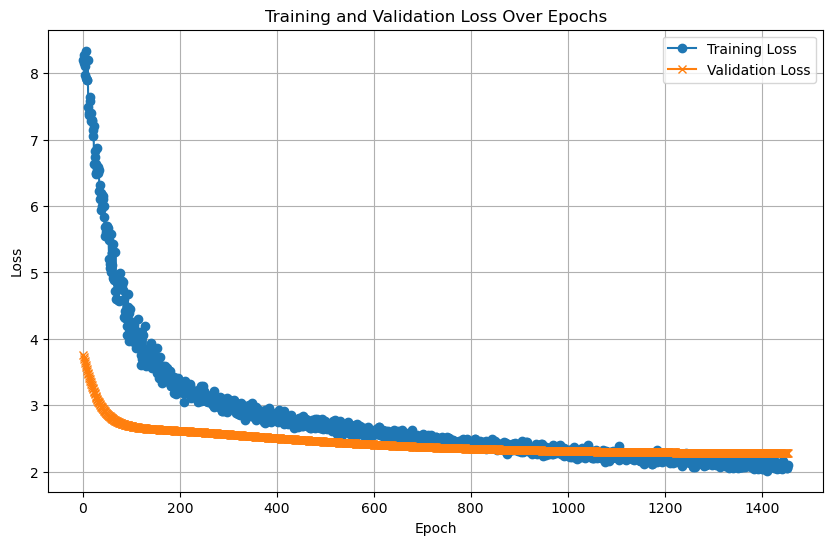

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/579], Loss: 4.8057
Test Batch [20/579], Loss: 4.6181
Test Batch [30/579], Loss: 4.6882
Test Batch [40/579], Loss: 4.6630
Test Batch [50/579], Loss: 4.5317
Test Batch [60/579], Loss: 4.5493
Test Batch [70/579], Loss: 4.6239
Test Batch [80/579], Loss: 4.7319
Test Batch [90/579], Loss: 4.4346
Test Batch [100/579], Loss: 4.6158
Test Batch [110/579], Loss: 4.5150
Test Batch [120/579], Loss: 4.4330
Test Batch [130/579], Loss: 4.4860
Test Batch [140/579], Loss: 4.4025


Test Batch [150/579], Loss: 4.5340
Test Batch [160/579], Loss: 4.6836
Test Batch [170/579], Loss: 4.9740
Test Batch [180/579], Loss: 4.6509
Test Batch [190/579], Loss: 4.5760
Test Batch [200/579], Loss: 4.6071
Test Batch [210/579], Loss: 4.7320
Test Batch [220/579], Loss: 4.6857
Test Batch [230/579], Loss: 4.6147
Test Batch [240/579], Loss: 4.6813
Test Batch [250/579], Loss: 4.5619
Test Batch [260/579], Loss: 4.5760
Test Batch [270/579], Loss: 4.4909
Test Batch [280/579], Loss: 4.7064


Test Batch [290/579], Loss: 4.6167
Test Batch [300/579], Loss: 4.5872
Test Batch [310/579], Loss: 4.7677
Test Batch [320/579], Loss: 4.8789
Test Batch [330/579], Loss: 4.7976
Test Batch [340/579], Loss: 4.7102
Test Batch [350/579], Loss: 5.0453
Test Batch [360/579], Loss: 4.9987
Test Batch [370/579], Loss: 4.8246
Test Batch [380/579], Loss: 4.3633
Test Batch [390/579], Loss: 5.2798
Test Batch [400/579], Loss: 5.4251
Test Batch [410/579], Loss: 5.2524


Test Batch [420/579], Loss: 5.2376
Test Batch [430/579], Loss: 5.1931
Test Batch [440/579], Loss: 5.1830
Test Batch [450/579], Loss: 5.0633
Test Batch [460/579], Loss: 5.0554
Test Batch [470/579], Loss: 5.1133
Test Batch [480/579], Loss: 4.5057
Test Batch [490/579], Loss: 5.1571


Test Batch [500/579], Loss: 4.8979
Test Batch [510/579], Loss: 4.8820
Test Batch [520/579], Loss: 5.1949
Test Batch [530/579], Loss: 5.7843
Test Batch [540/579], Loss: 4.8569
Test Batch [550/579], Loss: 4.6854
Test Batch [560/579], Loss: 4.4934
Test Batch [570/579], Loss: 4.6560

Test Loss: 4.7640


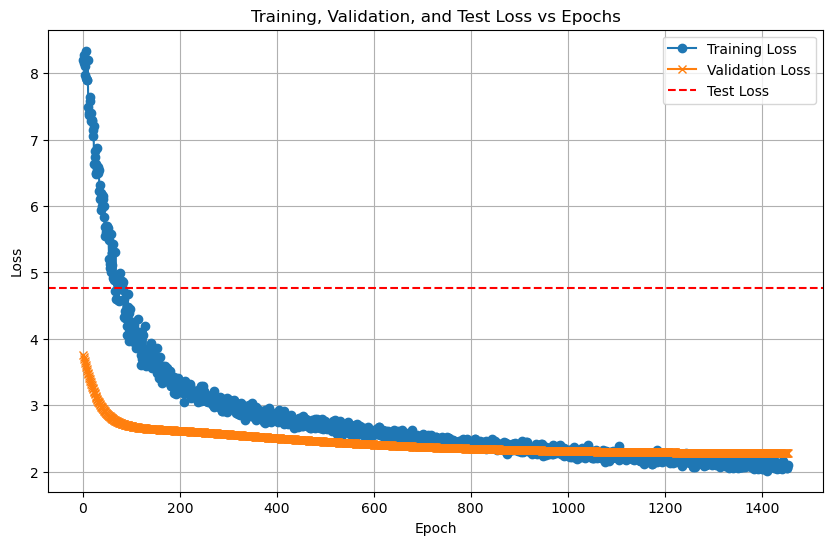

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/579 for test dataset.
  Processed batch 20/579 for test dataset.
  Processed batch 30/579 for test dataset.
  Processed batch 40/579 for test dataset.
  Processed batch 50/579 for test dataset.


  Processed batch 60/579 for test dataset.
  Processed batch 70/579 for test dataset.
  Processed batch 80/579 for test dataset.
  Processed batch 90/579 for test dataset.
  Processed batch 100/579 for test dataset.
  Processed batch 110/579 for test dataset.


  Processed batch 120/579 for test dataset.
  Processed batch 130/579 for test dataset.
  Processed batch 140/579 for test dataset.
  Processed batch 150/579 for test dataset.
  Processed batch 160/579 for test dataset.
  Processed batch 170/579 for test dataset.


  Processed batch 180/579 for test dataset.
  Processed batch 190/579 for test dataset.
  Processed batch 200/579 for test dataset.
  Processed batch 210/579 for test dataset.
  Processed batch 220/579 for test dataset.
  Processed batch 230/579 for test dataset.


  Processed batch 240/579 for test dataset.
  Processed batch 250/579 for test dataset.
  Processed batch 260/579 for test dataset.
  Processed batch 270/579 for test dataset.
  Processed batch 280/579 for test dataset.
  Processed batch 290/579 for test dataset.


  Processed batch 300/579 for test dataset.
  Processed batch 310/579 for test dataset.
  Processed batch 320/579 for test dataset.
  Processed batch 330/579 for test dataset.
  Processed batch 340/579 for test dataset.
  Processed batch 350/579 for test dataset.


  Processed batch 360/579 for test dataset.
  Processed batch 370/579 for test dataset.
  Processed batch 380/579 for test dataset.
  Processed batch 390/579 for test dataset.
  Processed batch 400/579 for test dataset.
  Processed batch 410/579 for test dataset.


  Processed batch 420/579 for test dataset.
  Processed batch 430/579 for test dataset.
  Processed batch 440/579 for test dataset.
  Processed batch 450/579 for test dataset.
  Processed batch 460/579 for test dataset.
  Processed batch 470/579 for test dataset.


  Processed batch 480/579 for test dataset.
  Processed batch 490/579 for test dataset.
  Processed batch 500/579 for test dataset.
  Processed batch 510/579 for test dataset.
  Processed batch 520/579 for test dataset.
  Processed batch 530/579 for test dataset.


  Processed batch 540/579 for test dataset.
  Processed batch 550/579 for test dataset.
  Processed batch 560/579 for test dataset.
  Processed batch 570/579 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148062, 128)
Test labels shape: (148062,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 86.67%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      0.80      0.89         5
           3       0.62      1.00      0.77         5
           4       0.50      0.40      0.44         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      0.60      0.75         5
           8       1.00      1.00      1.00         5

    accuracy                           0.87        45
   macro avg       0.88      0.87      0.86        45
weighted avg       0.88      0.87      0.86        45


LOG: Evaluating on the test set...
Test Accuracy: 86.56%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     65961
           1       0.90      0.88      0.89      7588
           2       0.58      0.71      0.64      3080
           3       0.43      0.92      0.59      2675
           4       0.29      0.70      0.41      6574
           5       0.86      0.95      0.90      9238
           6       0.89      0.84      0.86      7277
           7       0.98      0.69      0.81     42816
           8       0.93      0.95      0.94      2853

    accuracy                           0.87    148062
   macro avg       0.76      0.85      0.78    148062
weighted avg       0.92      0.87      0.88    148062

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148062, 128)
Test labels shape: (148062,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3873  |  Val Loss: 2.3615
Validation loss improved from inf to 2.3615.
[Epoch 2/1000] Train Loss: 2.3695  |  Val Loss: 2.3468
Validation loss improved from 2.3615 to 2.3468.
[Epoch 3/1000] Train Loss: 2.3525  |  Val Loss: 2.3325
Validation loss improved from 2.3468 to 2.3325.
[Epoch 4/1000] Train Loss: 2.3359  |  Val Loss: 2.3185
Validation loss improved from 2.3325 to 2.3185.
[Epoch 5/1000] Train Loss: 2.3200  |  Val Loss: 2.3046
Validation loss improved from 2.3185 to 2.3046.
[Epoch 6/1000] Train Loss: 2.3045  |  Val Loss: 2.2909
Validation loss improved from 2.3046 to 2.2909.
[Epoch 7/1000] Train Loss: 2.2890  |  Val Loss: 2.2776
Validation loss improved from 2.2909 to 2.2776.
[Epoch 8/1000] Train Loss: 2.2736  |  Val Loss: 2.2646
Validation loss improved from 2.2776 to 2.2646.
[Epoch 9/1000] Train Loss: 2.2584  |  Val Loss: 2.2517
Validation loss improved from 2.2646 to 2.2517.
[Epoch 10/1000] Train Loss: 2.2434  |  Val Loss: 2.2393
Validation loss impr

[Epoch 54/1000] Train Loss: 1.8283  |  Val Loss: 1.8954
Validation loss improved from 1.9011 to 1.8954.
[Epoch 55/1000] Train Loss: 1.8213  |  Val Loss: 1.8895
Validation loss improved from 1.8954 to 1.8895.
[Epoch 56/1000] Train Loss: 1.8144  |  Val Loss: 1.8837
Validation loss improved from 1.8895 to 1.8837.
[Epoch 57/1000] Train Loss: 1.8075  |  Val Loss: 1.8778
Validation loss improved from 1.8837 to 1.8778.
[Epoch 58/1000] Train Loss: 1.8004  |  Val Loss: 1.8718
Validation loss improved from 1.8778 to 1.8718.
[Epoch 59/1000] Train Loss: 1.7933  |  Val Loss: 1.8658
Validation loss improved from 1.8718 to 1.8658.
[Epoch 60/1000] Train Loss: 1.7861  |  Val Loss: 1.8598
Validation loss improved from 1.8658 to 1.8598.
[Epoch 61/1000] Train Loss: 1.7788  |  Val Loss: 1.8538
Validation loss improved from 1.8598 to 1.8538.
[Epoch 62/1000] Train Loss: 1.7714  |  Val Loss: 1.8478
Validation loss improved from 1.8538 to 1.8478.
[Epoch 63/1000] Train Loss: 1.7640  |  Val Loss: 1.8417
Validati

[Epoch 130/1000] Train Loss: 1.2733  |  Val Loss: 1.4480
Validation loss improved from 1.4534 to 1.4480.
[Epoch 131/1000] Train Loss: 1.2666  |  Val Loss: 1.4427
Validation loss improved from 1.4480 to 1.4427.
[Epoch 132/1000] Train Loss: 1.2600  |  Val Loss: 1.4373
Validation loss improved from 1.4427 to 1.4373.
[Epoch 133/1000] Train Loss: 1.2535  |  Val Loss: 1.4321
Validation loss improved from 1.4373 to 1.4321.
[Epoch 134/1000] Train Loss: 1.2470  |  Val Loss: 1.4268
Validation loss improved from 1.4321 to 1.4268.
[Epoch 135/1000] Train Loss: 1.2404  |  Val Loss: 1.4216
Validation loss improved from 1.4268 to 1.4216.
[Epoch 136/1000] Train Loss: 1.2338  |  Val Loss: 1.4164
Validation loss improved from 1.4216 to 1.4164.
[Epoch 137/1000] Train Loss: 1.2272  |  Val Loss: 1.4112
Validation loss improved from 1.4164 to 1.4112.
[Epoch 138/1000] Train Loss: 1.2206  |  Val Loss: 1.4060
Validation loss improved from 1.4112 to 1.4060.
[Epoch 139/1000] Train Loss: 1.2139  |  Val Loss: 1.400

[Epoch 198/1000] Train Loss: 0.8149  |  Val Loss: 1.0751
Validation loss improved from 1.0797 to 1.0751.
[Epoch 199/1000] Train Loss: 0.8093  |  Val Loss: 1.0706
Validation loss improved from 1.0751 to 1.0706.
[Epoch 200/1000] Train Loss: 0.8038  |  Val Loss: 1.0660
Validation loss improved from 1.0706 to 1.0660.
[Epoch 201/1000] Train Loss: 0.7982  |  Val Loss: 1.0615
Validation loss improved from 1.0660 to 1.0615.
[Epoch 202/1000] Train Loss: 0.7928  |  Val Loss: 1.0570
Validation loss improved from 1.0615 to 1.0570.
[Epoch 203/1000] Train Loss: 0.7873  |  Val Loss: 1.0525
Validation loss improved from 1.0570 to 1.0525.
[Epoch 204/1000] Train Loss: 0.7818  |  Val Loss: 1.0479
Validation loss improved from 1.0525 to 1.0479.
[Epoch 205/1000] Train Loss: 0.7764  |  Val Loss: 1.0433
Validation loss improved from 1.0479 to 1.0433.
[Epoch 206/1000] Train Loss: 0.7710  |  Val Loss: 1.0387
Validation loss improved from 1.0433 to 1.0387.
[Epoch 207/1000] Train Loss: 0.7656  |  Val Loss: 1.034

[Epoch 264/1000] Train Loss: 0.4904  |  Val Loss: 0.8285
Validation loss improved from 0.8308 to 0.8285.
[Epoch 265/1000] Train Loss: 0.4866  |  Val Loss: 0.8261
Validation loss improved from 0.8285 to 0.8261.
[Epoch 266/1000] Train Loss: 0.4829  |  Val Loss: 0.8238
Validation loss improved from 0.8261 to 0.8238.
[Epoch 267/1000] Train Loss: 0.4792  |  Val Loss: 0.8215
Validation loss improved from 0.8238 to 0.8215.
[Epoch 268/1000] Train Loss: 0.4755  |  Val Loss: 0.8192
Validation loss improved from 0.8215 to 0.8192.
[Epoch 269/1000] Train Loss: 0.4719  |  Val Loss: 0.8170
Validation loss improved from 0.8192 to 0.8170.
[Epoch 270/1000] Train Loss: 0.4682  |  Val Loss: 0.8148
Validation loss improved from 0.8170 to 0.8148.
[Epoch 271/1000] Train Loss: 0.4646  |  Val Loss: 0.8126
Validation loss improved from 0.8148 to 0.8126.
[Epoch 272/1000] Train Loss: 0.4611  |  Val Loss: 0.8105
Validation loss improved from 0.8126 to 0.8105.
[Epoch 273/1000] Train Loss: 0.4576  |  Val Loss: 0.808

[Epoch 336/1000] Train Loss: 0.2841  |  Val Loss: 0.7203
Validation loss improved from 0.7212 to 0.7203.
[Epoch 337/1000] Train Loss: 0.2820  |  Val Loss: 0.7194
Validation loss improved from 0.7203 to 0.7194.
[Epoch 338/1000] Train Loss: 0.2799  |  Val Loss: 0.7185
Validation loss improved from 0.7194 to 0.7185.
[Epoch 339/1000] Train Loss: 0.2778  |  Val Loss: 0.7177
Validation loss improved from 0.7185 to 0.7177.
[Epoch 340/1000] Train Loss: 0.2758  |  Val Loss: 0.7168
Validation loss improved from 0.7177 to 0.7168.
[Epoch 341/1000] Train Loss: 0.2737  |  Val Loss: 0.7160
Validation loss improved from 0.7168 to 0.7160.
[Epoch 342/1000] Train Loss: 0.2717  |  Val Loss: 0.7152
Validation loss improved from 0.7160 to 0.7152.
[Epoch 343/1000] Train Loss: 0.2697  |  Val Loss: 0.7144
Validation loss improved from 0.7152 to 0.7144.
[Epoch 344/1000] Train Loss: 0.2677  |  Val Loss: 0.7136
Validation loss improved from 0.7144 to 0.7136.
[Epoch 345/1000] Train Loss: 0.2657  |  Val Loss: 0.712

[Epoch 411/1000] Train Loss: 0.1664  |  Val Loss: 0.6942
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 412/1000] Train Loss: 0.1654  |  Val Loss: 0.6942
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 413/1000] Train Loss: 0.1643  |  Val Loss: 0.6942
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 414/1000] Train Loss: 0.1633  |  Val Loss: 0.6943
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 415/1000] Train Loss: 0.1622  |  Val Loss: 0.6944
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 416/1000] Train Loss: 0.1612  |  Val Loss: 0.6945
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 417/1000] Train Loss: 0.1602  |  Val Loss: 0.6946
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 418/1000] Train Loss: 0.1592  |  Val Loss: 0.6947
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 419/1000] Train Loss: 0.1582  |  Val Loss: 0.6948
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 479/1000] Train Loss: 0.1116  |  Val Loss: 0.7121
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 480/1000] Train Loss: 0.1109  |  Val Loss: 0.7124
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 481/1000] Train Loss: 0.1103  |  Val Loss: 0.7128
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 482/1000] Train Loss: 0.1096  |  Val Loss: 0.7133
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 483/1000] Train Loss: 0.1091  |  Val Loss: 0.7138
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 484/1000] Train Loss: 0.1085  |  Val Loss: 0.7142
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 485/1000] Train Loss: 0.1079  |  Val Loss: 0.7146
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 486/1000] Train Loss: 0.1074  |  Val Loss: 0.7150
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 487/1000] Train Loss: 0.1069  |  Val Loss: 0.7154
!! Validation loss did NOT improve !! Patience:

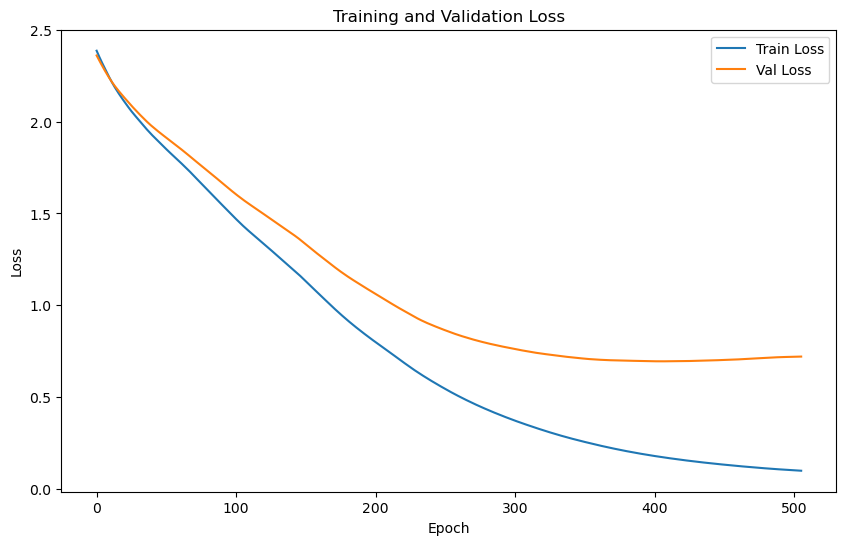

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.5530 | Test Accuracy: 83.24%


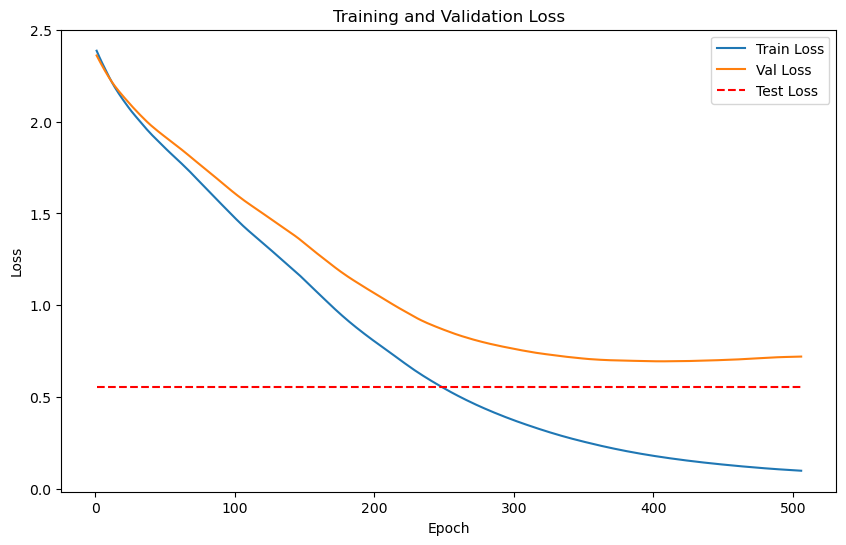

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148062 samples with 64 features each
LOG: Labels shape: (148062,)


Train embeddings shape: (45, 64), 
Train labels shape: (45,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (148062, 64), 
Test labels shape: (148062,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Training batch size: 45


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.4063
Epoch [1/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.4063

Validation loss improved from inf to 0.4063. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 0.4546
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.4047
Epoch [2/2000], Avg Train Loss: 0.4546, Avg Val Loss: 0.4047

Validation loss improved from 0.4063 to 0.4047. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4541
LOG: Epoch [3/2000] - Validation
    Batch [1/1], Val Loss: 0.4034
Epoch [3/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.4034

Validation loss improved from 0.4047 to 0.4034. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.4024
Epoch [4/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.4024

Validation loss improved from 0.4034 to 0.4024. Saving model...
LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [5/2000] - Validation


    Batch [1/1], Val Loss: 0.4014
Epoch [5/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.4014

Validation loss improved from 0.4024 to 0.4014. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 0.4388
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.4003
Epoch [6/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.4003

Validation loss improved from 0.4014 to 0.4003. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [7/2000] - Validation


    Batch [1/1], Val Loss: 0.3992
Epoch [7/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.3992

Validation loss improved from 0.4003 to 0.3992. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.4439
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.3982
Epoch [8/2000], Avg Train Loss: 0.4439, Avg Val Loss: 0.3982

Validation loss improved from 0.3992 to 0.3982. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.3975
Epoch [9/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.3975

Validation loss improved from 0.3982 to 0.3975. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4337
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.3970
Epoch [10/2000], Avg Train Loss: 0.4337, Avg Val Loss: 0.3970

Validation loss improved from 0.3975 to 0.3970. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.4334
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.3972
Epoch [11/2000], Avg Train Loss: 0.4334, Avg Val Loss: 0.3972

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.3972
Epoch [12/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.3972

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.4357
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.3971
Epoch [13/2000], Avg Train Loss: 0.4357, Avg Val Loss: 0.3971

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.3968
Epoch [14/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.3968

Validation loss improved from 0.3970 to 0.3968. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.4389
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.3965
Epoch [15/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.3965

Validation loss improved from 0.3968 to 0.3965. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4360
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.3961
Epoch [16/2000], Avg Train Loss: 0.4360, Avg Val Loss: 0.3961

Validation loss improved from 0.3965 to 0.3961. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.4321
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.3956
Epoch [17/2000], Avg Train Loss: 0.4321, Avg Val Loss: 0.3956

Validation loss improved from 0.3961 to 0.3956. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4307
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.3949
Epoch [18/2000], Avg Train Loss: 0.4307, Avg Val Loss: 0.3949

Validation loss improved from 0.3956 to 0.3949. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.4383
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.3942
Epoch [19/2000], Avg Train Loss: 0.4383, Avg Val Loss: 0.3942

Validation loss improved from 0.3949 to 0.3942. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [20/2000] - Validation


    Batch [1/1], Val Loss: 0.3934
Epoch [20/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.3934

Validation loss improved from 0.3942 to 0.3934. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.4315
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.3928
Epoch [21/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.3928

Validation loss improved from 0.3934 to 0.3928. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [22/2000] - Validation


    Batch [1/1], Val Loss: 0.3921
Epoch [22/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.3921

Validation loss improved from 0.3928 to 0.3921. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.4319
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.3914
Epoch [23/2000], Avg Train Loss: 0.4319, Avg Val Loss: 0.3914

Validation loss improved from 0.3921 to 0.3914. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.4152
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.3908
Epoch [24/2000], Avg Train Loss: 0.4152, Avg Val Loss: 0.3908

Validation loss improved from 0.3914 to 0.3908. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4305
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.3902
Epoch [25/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.3902

Validation loss improved from 0.3908 to 0.3902. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.4208
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.3896
Epoch [26/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.3896

Validation loss improved from 0.3902 to 0.3896. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4233
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.3889
Epoch [27/2000], Avg Train Loss: 0.4233, Avg Val Loss: 0.3889

Validation loss improved from 0.3896 to 0.3889. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.3883
Epoch [28/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.3883

Validation loss improved from 0.3889 to 0.3883. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4303
LOG: Epoch [29/2000] - Validation


    Batch [1/1], Val Loss: 0.3876
Epoch [29/2000], Avg Train Loss: 0.4303, Avg Val Loss: 0.3876

Validation loss improved from 0.3883 to 0.3876. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.4204
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.3869
Epoch [30/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.3869

Validation loss improved from 0.3876 to 0.3869. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.4114
LOG: Epoch [31/2000] - Validation


    Batch [1/1], Val Loss: 0.3863
Epoch [31/2000], Avg Train Loss: 0.4114, Avg Val Loss: 0.3863

Validation loss improved from 0.3869 to 0.3863. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.4205
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.3855
Epoch [32/2000], Avg Train Loss: 0.4205, Avg Val Loss: 0.3855

Validation loss improved from 0.3863 to 0.3855. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.3849
Epoch [33/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.3849

Validation loss improved from 0.3855 to 0.3849. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4109
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.3842
Epoch [34/2000], Avg Train Loss: 0.4109, Avg Val Loss: 0.3842

Validation loss improved from 0.3849 to 0.3842. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.4184
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.3835
Epoch [35/2000], Avg Train Loss: 0.4184, Avg Val Loss: 0.3835

Validation loss improved from 0.3842 to 0.3835. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.4148
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.3828
Epoch [36/2000], Avg Train Loss: 0.4148, Avg Val Loss: 0.3828

Validation loss improved from 0.3835 to 0.3828. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4105
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.3821
Epoch [37/2000], Avg Train Loss: 0.4105, Avg Val Loss: 0.3821

Validation loss improved from 0.3828 to 0.3821. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.3814
Epoch [38/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.3814

Validation loss improved from 0.3821 to 0.3814. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [39/2000] - Validation


    Batch [1/1], Val Loss: 0.3807
Epoch [39/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.3807

Validation loss improved from 0.3814 to 0.3807. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.3800
Epoch [40/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.3800

Validation loss improved from 0.3807 to 0.3800. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.4079
LOG: Epoch [41/2000] - Validation


    Batch [1/1], Val Loss: 0.3793
Epoch [41/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.3793

Validation loss improved from 0.3800 to 0.3793. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.4071
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.3786
Epoch [42/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.3786

Validation loss improved from 0.3793 to 0.3786. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.4113
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.3779
Epoch [43/2000], Avg Train Loss: 0.4113, Avg Val Loss: 0.3779

Validation loss improved from 0.3786 to 0.3779. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4097
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.3772
Epoch [44/2000], Avg Train Loss: 0.4097, Avg Val Loss: 0.3772

Validation loss improved from 0.3779 to 0.3772. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.3979
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.3765
Epoch [45/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.3765

Validation loss improved from 0.3772 to 0.3765. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [46/2000] - Validation


    Batch [1/1], Val Loss: 0.3759
Epoch [46/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.3759

Validation loss improved from 0.3765 to 0.3759. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.3752
Epoch [47/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.3752

Validation loss improved from 0.3759 to 0.3752. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.3746


Epoch [48/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.3746

Validation loss improved from 0.3752 to 0.3746. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.3740
Epoch [49/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.3740

Validation loss improved from 0.3746 to 0.3740. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3733
Epoch [50/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.3733

Validation loss improved from 0.3740 to 0.3733. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.3727
Epoch [51/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.3727

Validation loss improved from 0.3733 to 0.3727. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.3721
Epoch [52/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.3721

Validation loss improved from 0.3727 to 0.3721. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.3715
Epoch [53/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.3715

Validation loss improved from 0.3721 to 0.3715. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.3710
Epoch [54/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.3710

Validation loss improved from 0.3715 to 0.3710. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.3704
Epoch [55/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3704

Validation loss improved from 0.3710 to 0.3704. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [56/2000] - Validation
    Batch [1/1], Val Loss: 0.3698
Epoch [56/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.3698

Validation loss improved from 0.3704 to 0.3698. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.3693
Epoch [57/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.3693

Validation loss improved from 0.3698 to 0.3693. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.3687
Epoch [58/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.3687

Validation loss improved from 0.3693 to 0.3687. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.3681
Epoch [59/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3681

Validation loss improved from 0.3687 to 0.3681. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [60/2000] - Validation


    Batch [1/1], Val Loss: 0.3675
Epoch [60/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.3675

Validation loss improved from 0.3681 to 0.3675. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.3800
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.3670
Epoch [61/2000], Avg Train Loss: 0.3800, Avg Val Loss: 0.3670

Validation loss improved from 0.3675 to 0.3670. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.3814
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.3664
Epoch [62/2000], Avg Train Loss: 0.3814, Avg Val Loss: 0.3664

Validation loss improved from 0.3670 to 0.3664. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.3763
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.3658
Epoch [63/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.3658

Validation loss improved from 0.3664 to 0.3658. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.3804
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.3652
Epoch [64/2000], Avg Train Loss: 0.3804, Avg Val Loss: 0.3652

Validation loss improved from 0.3658 to 0.3652. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.3744
LOG: Epoch [65/2000] - Validation


    Batch [1/1], Val Loss: 0.3647
Epoch [65/2000], Avg Train Loss: 0.3744, Avg Val Loss: 0.3647

Validation loss improved from 0.3652 to 0.3647. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.3765
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.3641
Epoch [66/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.3641

Validation loss improved from 0.3647 to 0.3641. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.3834
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.3635
Epoch [67/2000], Avg Train Loss: 0.3834, Avg Val Loss: 0.3635

Validation loss improved from 0.3641 to 0.3635. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.3705
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.3629
Epoch [68/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.3629

Validation loss improved from 0.3635 to 0.3629. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.3624
Epoch [69/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.3624

Validation loss improved from 0.3629 to 0.3624. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [70/2000] - Validation


    Batch [1/1], Val Loss: 0.3619
Epoch [70/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.3619

Validation loss improved from 0.3624 to 0.3619. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.3776
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.3613
Epoch [71/2000], Avg Train Loss: 0.3776, Avg Val Loss: 0.3613

Validation loss improved from 0.3619 to 0.3613. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.3609
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.3608
Epoch [72/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.3608

Validation loss improved from 0.3613 to 0.3608. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.3593
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.3603
Epoch [73/2000], Avg Train Loss: 0.3593, Avg Val Loss: 0.3603

Validation loss improved from 0.3608 to 0.3603. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.3598
Epoch [74/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.3598

Validation loss improved from 0.3603 to 0.3598. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.3628
LOG: Epoch [75/2000] - Validation


    Batch [1/1], Val Loss: 0.3593
Epoch [75/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.3593

Validation loss improved from 0.3598 to 0.3593. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.3727
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.3588
Epoch [76/2000], Avg Train Loss: 0.3727, Avg Val Loss: 0.3588

Validation loss improved from 0.3593 to 0.3588. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.3615
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.3584
Epoch [77/2000], Avg Train Loss: 0.3615, Avg Val Loss: 0.3584

Validation loss improved from 0.3588 to 0.3584. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.3729
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.3579
Epoch [78/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.3579

Validation loss improved from 0.3584 to 0.3579. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.3603
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.3575
Epoch [79/2000], Avg Train Loss: 0.3603, Avg Val Loss: 0.3575

Validation loss improved from 0.3579 to 0.3575. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.3695
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.3571
Epoch [80/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.3571

Validation loss improved from 0.3575 to 0.3571. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.3491
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.3567
Epoch [81/2000], Avg Train Loss: 0.3491, Avg Val Loss: 0.3567

Validation loss improved from 0.3571 to 0.3567. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.3513
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.3563
Epoch [82/2000], Avg Train Loss: 0.3513, Avg Val Loss: 0.3563

Validation loss improved from 0.3567 to 0.3563. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.3586
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.3559
Epoch [83/2000], Avg Train Loss: 0.3586, Avg Val Loss: 0.3559

Validation loss improved from 0.3563 to 0.3559. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [84/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.3555

Validation loss improved from 0.3559 to 0.3555. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.3531
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.3551
Epoch [85/2000], Avg Train Loss: 0.3531, Avg Val Loss: 0.3551

Validation loss improved from 0.3555 to 0.3551. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.3611
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.3547
Epoch [86/2000], Avg Train Loss: 0.3611, Avg Val Loss: 0.3547

Validation loss improved from 0.3551 to 0.3547. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.3618
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.3543
Epoch [87/2000], Avg Train Loss: 0.3618, Avg Val Loss: 0.3543

Validation loss improved from 0.3547 to 0.3543. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.3787
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.3540
Epoch [88/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.3540

Validation loss improved from 0.3543 to 0.3540. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.3509
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.3536
Epoch [89/2000], Avg Train Loss: 0.3509, Avg Val Loss: 0.3536

Validation loss improved from 0.3540 to 0.3536. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.3573
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.3532
Epoch [90/2000], Avg Train Loss: 0.3573, Avg Val Loss: 0.3532

Validation loss improved from 0.3536 to 0.3532. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.3614
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.3527
Epoch [91/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.3527

Validation loss improved from 0.3532 to 0.3527. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.3523
Epoch [92/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.3523

Validation loss improved from 0.3527 to 0.3523. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.3552
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.3519
Epoch [93/2000], Avg Train Loss: 0.3552, Avg Val Loss: 0.3519

Validation loss improved from 0.3523 to 0.3519. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.3552
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.3516
Epoch [94/2000], Avg Train Loss: 0.3552, Avg Val Loss: 0.3516

Validation loss improved from 0.3519 to 0.3516. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.3568
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.3512
Epoch [95/2000], Avg Train Loss: 0.3568, Avg Val Loss: 0.3512

Validation loss improved from 0.3516 to 0.3512. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.3496
LOG: Epoch [96/2000] - Validation


    Batch [1/1], Val Loss: 0.3508
Epoch [96/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.3508

Validation loss improved from 0.3512 to 0.3508. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.3504
Epoch [97/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.3504

Validation loss improved from 0.3508 to 0.3504. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.3500
Epoch [98/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.3500

Validation loss improved from 0.3504 to 0.3500. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.3496
Epoch [99/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.3496

Validation loss improved from 0.3500 to 0.3496. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.3598
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.3493
Epoch [100/2000], Avg Train Loss: 0.3598, Avg Val Loss: 0.3493

Validation loss improved from 0.3496 to 0.3493. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.3374
LOG: Epoch [101/2000] - Validation


    Batch [1/1], Val Loss: 0.3489
Epoch [101/2000], Avg Train Loss: 0.3374, Avg Val Loss: 0.3489

Validation loss improved from 0.3493 to 0.3489. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.3388
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.3485
Epoch [102/2000], Avg Train Loss: 0.3388, Avg Val Loss: 0.3485

Validation loss improved from 0.3489 to 0.3485. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.3482
Epoch [103/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.3482

Validation loss improved from 0.3485 to 0.3482. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.3652
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.3478
Epoch [104/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.3478

Validation loss improved from 0.3482 to 0.3478. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.3474
Epoch [105/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.3474

Validation loss improved from 0.3478 to 0.3474. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [106/2000] - Validation


    Batch [1/1], Val Loss: 0.3470
Epoch [106/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.3470

Validation loss improved from 0.3474 to 0.3470. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.3346
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.3466
Epoch [107/2000], Avg Train Loss: 0.3346, Avg Val Loss: 0.3466

Validation loss improved from 0.3470 to 0.3466. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.3319
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.3463
Epoch [108/2000], Avg Train Loss: 0.3319, Avg Val Loss: 0.3463

Validation loss improved from 0.3466 to 0.3463. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.3459
Epoch [109/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.3459

Validation loss improved from 0.3463 to 0.3459. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.3455
Epoch [110/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.3455

Validation loss improved from 0.3459 to 0.3455. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.3373
LOG: Epoch [111/2000] - Validation


    Batch [1/1], Val Loss: 0.3452
Epoch [111/2000], Avg Train Loss: 0.3373, Avg Val Loss: 0.3452

Validation loss improved from 0.3455 to 0.3452. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.3404
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.3449
Epoch [112/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.3449

Validation loss improved from 0.3452 to 0.3449. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.3385
LOG: Epoch [113/2000] - Validation


    Batch [1/1], Val Loss: 0.3445
Epoch [113/2000], Avg Train Loss: 0.3385, Avg Val Loss: 0.3445

Validation loss improved from 0.3449 to 0.3445. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.3376
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.3442
Epoch [114/2000], Avg Train Loss: 0.3376, Avg Val Loss: 0.3442

Validation loss improved from 0.3445 to 0.3442. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.3358
LOG: Epoch [115/2000] - Validation


    Batch [1/1], Val Loss: 0.3438
Epoch [115/2000], Avg Train Loss: 0.3358, Avg Val Loss: 0.3438

Validation loss improved from 0.3442 to 0.3438. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.3337
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.3435
Epoch [116/2000], Avg Train Loss: 0.3337, Avg Val Loss: 0.3435

Validation loss improved from 0.3438 to 0.3435. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.3432
Epoch [117/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.3432

Validation loss improved from 0.3435 to 0.3432. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.3240
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.3428
Epoch [118/2000], Avg Train Loss: 0.3240, Avg Val Loss: 0.3428

Validation loss improved from 0.3432 to 0.3428. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.3276
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.3425
Epoch [119/2000], Avg Train Loss: 0.3276, Avg Val Loss: 0.3425

Validation loss improved from 0.3428 to 0.3425. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [120/2000] - Validation


    Batch [1/1], Val Loss: 0.3422
Epoch [120/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.3422

Validation loss improved from 0.3425 to 0.3422. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.3315
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.3419
Epoch [121/2000], Avg Train Loss: 0.3315, Avg Val Loss: 0.3419

Validation loss improved from 0.3422 to 0.3419. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.3415
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.3416
Epoch [122/2000], Avg Train Loss: 0.3415, Avg Val Loss: 0.3416

Validation loss improved from 0.3419 to 0.3416. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.3271
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.3413
Epoch [123/2000], Avg Train Loss: 0.3271, Avg Val Loss: 0.3413

Validation loss improved from 0.3416 to 0.3413. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.3409
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.3410
Epoch [124/2000], Avg Train Loss: 0.3409, Avg Val Loss: 0.3410

Validation loss improved from 0.3413 to 0.3410. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.3300
LOG: Epoch [125/2000] - Validation


    Batch [1/1], Val Loss: 0.3407
Epoch [125/2000], Avg Train Loss: 0.3300, Avg Val Loss: 0.3407

Validation loss improved from 0.3410 to 0.3407. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.3245
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.3405
Epoch [126/2000], Avg Train Loss: 0.3245, Avg Val Loss: 0.3405

Validation loss improved from 0.3407 to 0.3405. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.3252
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.3402
Epoch [127/2000], Avg Train Loss: 0.3252, Avg Val Loss: 0.3402

Validation loss improved from 0.3405 to 0.3402. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.3339
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.3399
Epoch [128/2000], Avg Train Loss: 0.3339, Avg Val Loss: 0.3399

Validation loss improved from 0.3402 to 0.3399. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.3214
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.3397
Epoch [129/2000], Avg Train Loss: 0.3214, Avg Val Loss: 0.3397

Validation loss improved from 0.3399 to 0.3397. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.3229
LOG: Epoch [130/2000] - Validation


    Batch [1/1], Val Loss: 0.3395
Epoch [130/2000], Avg Train Loss: 0.3229, Avg Val Loss: 0.3395

Validation loss improved from 0.3397 to 0.3395. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.3245
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.3392
Epoch [131/2000], Avg Train Loss: 0.3245, Avg Val Loss: 0.3392

Validation loss improved from 0.3395 to 0.3392. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.3296
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.3390
Epoch [132/2000], Avg Train Loss: 0.3296, Avg Val Loss: 0.3390

Validation loss improved from 0.3392 to 0.3390. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.3218
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.3388
Epoch [133/2000], Avg Train Loss: 0.3218, Avg Val Loss: 0.3388

Validation loss improved from 0.3390 to 0.3388. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.3182
LOG: Epoch [134/2000] - Validation
    Batch [1/1], Val Loss: 0.3385
Epoch [134/2000], Avg Train Loss: 0.3182, Avg Val Loss: 0.3385

Validation loss improved from 0.3388 to 0.3385. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.3218
LOG: Epoch [135/2000] - Validation


    Batch [1/1], Val Loss: 0.3383
Epoch [135/2000], Avg Train Loss: 0.3218, Avg Val Loss: 0.3383

Validation loss improved from 0.3385 to 0.3383. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.3152
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.3381
Epoch [136/2000], Avg Train Loss: 0.3152, Avg Val Loss: 0.3381

Validation loss improved from 0.3383 to 0.3381. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.3136
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.3380
Epoch [137/2000], Avg Train Loss: 0.3136, Avg Val Loss: 0.3380

Validation loss improved from 0.3381 to 0.3380. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.3191
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.3378
Epoch [138/2000], Avg Train Loss: 0.3191, Avg Val Loss: 0.3378

Validation loss improved from 0.3380 to 0.3378. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.3103
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.3376
Epoch [139/2000], Avg Train Loss: 0.3103, Avg Val Loss: 0.3376

Validation loss improved from 0.3378 to 0.3376. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.3089
LOG: Epoch [140/2000] - Validation


    Batch [1/1], Val Loss: 0.3374
Epoch [140/2000], Avg Train Loss: 0.3089, Avg Val Loss: 0.3374

Validation loss improved from 0.3376 to 0.3374. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.3122
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.3372
Epoch [141/2000], Avg Train Loss: 0.3122, Avg Val Loss: 0.3372

Validation loss improved from 0.3374 to 0.3372. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.3143
LOG: Epoch [142/2000] - Validation


    Batch [1/1], Val Loss: 0.3370
Epoch [142/2000], Avg Train Loss: 0.3143, Avg Val Loss: 0.3370

Validation loss improved from 0.3372 to 0.3370. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.3079
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.3367
Epoch [143/2000], Avg Train Loss: 0.3079, Avg Val Loss: 0.3367

Validation loss improved from 0.3370 to 0.3367. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.3136
LOG: Epoch [144/2000] - Validation


    Batch [1/1], Val Loss: 0.3365
Epoch [144/2000], Avg Train Loss: 0.3136, Avg Val Loss: 0.3365

Validation loss improved from 0.3367 to 0.3365. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.3140
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.3363
Epoch [145/2000], Avg Train Loss: 0.3140, Avg Val Loss: 0.3363

Validation loss improved from 0.3365 to 0.3363. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.3100
LOG: Epoch [146/2000] - Validation


    Batch [1/1], Val Loss: 0.3360
Epoch [146/2000], Avg Train Loss: 0.3100, Avg Val Loss: 0.3360

Validation loss improved from 0.3363 to 0.3360. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.3149
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.3358
Epoch [147/2000], Avg Train Loss: 0.3149, Avg Val Loss: 0.3358

Validation loss improved from 0.3360 to 0.3358. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3098
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.3356
Epoch [148/2000], Avg Train Loss: 0.3098, Avg Val Loss: 0.3356

Validation loss improved from 0.3358 to 0.3356. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.3169
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.3353
Epoch [149/2000], Avg Train Loss: 0.3169, Avg Val Loss: 0.3353

Validation loss improved from 0.3356 to 0.3353. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.3161
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.3351
Epoch [150/2000], Avg Train Loss: 0.3161, Avg Val Loss: 0.3351

Validation loss improved from 0.3353 to 0.3351. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.2979
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.3348
Epoch [151/2000], Avg Train Loss: 0.2979, Avg Val Loss: 0.3348

Validation loss improved from 0.3351 to 0.3348. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.3069
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.3346
Epoch [152/2000], Avg Train Loss: 0.3069, Avg Val Loss: 0.3346

Validation loss improved from 0.3348 to 0.3346. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.3333
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.3344
Epoch [153/2000], Avg Train Loss: 0.3333, Avg Val Loss: 0.3344

Validation loss improved from 0.3346 to 0.3344. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.3091
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.3341
Epoch [154/2000], Avg Train Loss: 0.3091, Avg Val Loss: 0.3341

Validation loss improved from 0.3344 to 0.3341. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.3062
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.3339
Epoch [155/2000], Avg Train Loss: 0.3062, Avg Val Loss: 0.3339

Validation loss improved from 0.3341 to 0.3339. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.3082
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.3337
Epoch [156/2000], Avg Train Loss: 0.3082, Avg Val Loss: 0.3337

Validation loss improved from 0.3339 to 0.3337. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.3107
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.3335
Epoch [157/2000], Avg Train Loss: 0.3107, Avg Val Loss: 0.3335

Validation loss improved from 0.3337 to 0.3335. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.3069
LOG: Epoch [158/2000] - Validation


    Batch [1/1], Val Loss: 0.3333
Epoch [158/2000], Avg Train Loss: 0.3069, Avg Val Loss: 0.3333

Validation loss improved from 0.3335 to 0.3333. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.3042
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.3331
Epoch [159/2000], Avg Train Loss: 0.3042, Avg Val Loss: 0.3331

Validation loss improved from 0.3333 to 0.3331. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.2883
LOG: Epoch [160/2000] - Validation


    Batch [1/1], Val Loss: 0.3330
Epoch [160/2000], Avg Train Loss: 0.2883, Avg Val Loss: 0.3330

Validation loss improved from 0.3331 to 0.3330. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.2840
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.3328
Epoch [161/2000], Avg Train Loss: 0.2840, Avg Val Loss: 0.3328

Validation loss improved from 0.3330 to 0.3328. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.2930
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.3327
Epoch [162/2000], Avg Train Loss: 0.2930, Avg Val Loss: 0.3327

Validation loss improved from 0.3328 to 0.3327. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.2966
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.3325
Epoch [163/2000], Avg Train Loss: 0.2966, Avg Val Loss: 0.3325

Validation loss improved from 0.3327 to 0.3325. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.3036
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.3324
Epoch [164/2000], Avg Train Loss: 0.3036, Avg Val Loss: 0.3324

Validation loss improved from 0.3325 to 0.3324. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3029
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.3322
Epoch [165/2000], Avg Train Loss: 0.3029, Avg Val Loss: 0.3322

Validation loss improved from 0.3324 to 0.3322. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.3082
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.3320
Epoch [166/2000], Avg Train Loss: 0.3082, Avg Val Loss: 0.3320

Validation loss improved from 0.3322 to 0.3320. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.3000
LOG: Epoch [167/2000] - Validation


    Batch [1/1], Val Loss: 0.3319
Epoch [167/2000], Avg Train Loss: 0.3000, Avg Val Loss: 0.3319

Validation loss improved from 0.3320 to 0.3319. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.2973
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [168/2000], Avg Train Loss: 0.2973, Avg Val Loss: 0.3317

Validation loss improved from 0.3319 to 0.3317. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.3013
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.3316
Epoch [169/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.3316

Validation loss improved from 0.3317 to 0.3316. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.2996
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.3315
Epoch [170/2000], Avg Train Loss: 0.2996, Avg Val Loss: 0.3315

Validation loss improved from 0.3316 to 0.3315. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.2922
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.3314
Epoch [171/2000], Avg Train Loss: 0.2922, Avg Val Loss: 0.3314

Validation loss improved from 0.3315 to 0.3314. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.2909
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.3312
Epoch [172/2000], Avg Train Loss: 0.2909, Avg Val Loss: 0.3312

Validation loss improved from 0.3314 to 0.3312. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.2962
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.3311
Epoch [173/2000], Avg Train Loss: 0.2962, Avg Val Loss: 0.3311

Validation loss improved from 0.3312 to 0.3311. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.2907
LOG: Epoch [174/2000] - Validation


    Batch [1/1], Val Loss: 0.3310
Epoch [174/2000], Avg Train Loss: 0.2907, Avg Val Loss: 0.3310

Validation loss improved from 0.3311 to 0.3310. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.3062
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.3309
Epoch [175/2000], Avg Train Loss: 0.3062, Avg Val Loss: 0.3309

Validation loss improved from 0.3310 to 0.3309. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.3005
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.3308
Epoch [176/2000], Avg Train Loss: 0.3005, Avg Val Loss: 0.3308

Validation loss improved from 0.3309 to 0.3308. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.2917
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.3306
Epoch [177/2000], Avg Train Loss: 0.2917, Avg Val Loss: 0.3306

Validation loss improved from 0.3308 to 0.3306. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.2895
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.3304
Epoch [178/2000], Avg Train Loss: 0.2895, Avg Val Loss: 0.3304

Validation loss improved from 0.3306 to 0.3304. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.2896
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.3303
Epoch [179/2000], Avg Train Loss: 0.2896, Avg Val Loss: 0.3303

Validation loss improved from 0.3304 to 0.3303. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.3021
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.3301
Epoch [180/2000], Avg Train Loss: 0.3021, Avg Val Loss: 0.3301

Validation loss improved from 0.3303 to 0.3301. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.2935
LOG: Epoch [181/2000] - Validation


    Batch [1/1], Val Loss: 0.3299
Epoch [181/2000], Avg Train Loss: 0.2935, Avg Val Loss: 0.3299

Validation loss improved from 0.3301 to 0.3299. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.2956
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.3298
Epoch [182/2000], Avg Train Loss: 0.2956, Avg Val Loss: 0.3298

Validation loss improved from 0.3299 to 0.3298. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.2994
LOG: Epoch [183/2000] - Validation


    Batch [1/1], Val Loss: 0.3296
Epoch [183/2000], Avg Train Loss: 0.2994, Avg Val Loss: 0.3296

Validation loss improved from 0.3298 to 0.3296. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.3002
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.3294
Epoch [184/2000], Avg Train Loss: 0.3002, Avg Val Loss: 0.3294

Validation loss improved from 0.3296 to 0.3294. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.2878
LOG: Epoch [185/2000] - Validation
    Batch [1/1], Val Loss: 0.3292
Epoch [185/2000], Avg Train Loss: 0.2878, Avg Val Loss: 0.3292

Validation loss improved from 0.3294 to 0.3292. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.2928
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.3290
Epoch [186/2000], Avg Train Loss: 0.2928, Avg Val Loss: 0.3290

Validation loss improved from 0.3292 to 0.3290. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.2870
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [187/2000], Avg Train Loss: 0.2870, Avg Val Loss: 0.3288

Validation loss improved from 0.3290 to 0.3288. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.2839
LOG: Epoch [188/2000] - Validation


    Batch [1/1], Val Loss: 0.3286
Epoch [188/2000], Avg Train Loss: 0.2839, Avg Val Loss: 0.3286

Validation loss improved from 0.3288 to 0.3286. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.3012
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.3285
Epoch [189/2000], Avg Train Loss: 0.3012, Avg Val Loss: 0.3285

Validation loss improved from 0.3286 to 0.3285. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.3283
Epoch [190/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.3283

Validation loss improved from 0.3285 to 0.3283. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.2767
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.3281
Epoch [191/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.3281

Validation loss improved from 0.3283 to 0.3281. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.2848
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.3280
Epoch [192/2000], Avg Train Loss: 0.2848, Avg Val Loss: 0.3280

Validation loss improved from 0.3281 to 0.3280. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.2773
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.3278
Epoch [193/2000], Avg Train Loss: 0.2773, Avg Val Loss: 0.3278

Validation loss improved from 0.3280 to 0.3278. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.3277
Epoch [194/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.3277

Validation loss improved from 0.3278 to 0.3277. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.2894
LOG: Epoch [195/2000] - Validation


    Batch [1/1], Val Loss: 0.3275
Epoch [195/2000], Avg Train Loss: 0.2894, Avg Val Loss: 0.3275

Validation loss improved from 0.3277 to 0.3275. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.2760
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.3274
Epoch [196/2000], Avg Train Loss: 0.2760, Avg Val Loss: 0.3274

Validation loss improved from 0.3275 to 0.3274. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.2763
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.3272
Epoch [197/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.3272

Validation loss improved from 0.3274 to 0.3272. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.2845
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.3270
Epoch [198/2000], Avg Train Loss: 0.2845, Avg Val Loss: 0.3270

Validation loss improved from 0.3272 to 0.3270. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.3269
Epoch [199/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.3269

Validation loss improved from 0.3270 to 0.3269. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.2853
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.3267
Epoch [200/2000], Avg Train Loss: 0.2853, Avg Val Loss: 0.3267

Validation loss improved from 0.3269 to 0.3267. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.2883
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.3266
Epoch [201/2000], Avg Train Loss: 0.2883, Avg Val Loss: 0.3266

Validation loss improved from 0.3267 to 0.3266. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.2878
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.3264
Epoch [202/2000], Avg Train Loss: 0.2878, Avg Val Loss: 0.3264

Validation loss improved from 0.3266 to 0.3264. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.2834
LOG: Epoch [203/2000] - Validation


    Batch [1/1], Val Loss: 0.3263
Epoch [203/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.3263

Validation loss improved from 0.3264 to 0.3263. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.3261
Epoch [204/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.3261

Validation loss improved from 0.3263 to 0.3261. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.2652
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.3259
Epoch [205/2000], Avg Train Loss: 0.2652, Avg Val Loss: 0.3259

Validation loss improved from 0.3261 to 0.3259. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.3258
Epoch [206/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.3258

Validation loss improved from 0.3259 to 0.3258. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.3256
Epoch [207/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.3256

Validation loss improved from 0.3258 to 0.3256. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.2815
LOG: Epoch [208/2000] - Validation


    Batch [1/1], Val Loss: 0.3255
Epoch [208/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.3255

Validation loss improved from 0.3256 to 0.3255. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.2707
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [209/2000], Avg Train Loss: 0.2707, Avg Val Loss: 0.3254

Validation loss improved from 0.3255 to 0.3254. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.2760
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.3252
Epoch [210/2000], Avg Train Loss: 0.2760, Avg Val Loss: 0.3252

Validation loss improved from 0.3254 to 0.3252. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.2641
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.3251
Epoch [211/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.3251

Validation loss improved from 0.3252 to 0.3251. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.2749
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.3250
Epoch [212/2000], Avg Train Loss: 0.2749, Avg Val Loss: 0.3250

Validation loss improved from 0.3251 to 0.3250. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [213/2000] - Validation


    Batch [1/1], Val Loss: 0.3250
Epoch [213/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.3250

Validation loss improved from 0.3250 to 0.3250. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.2700
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.3249
Epoch [214/2000], Avg Train Loss: 0.2700, Avg Val Loss: 0.3249

Validation loss improved from 0.3250 to 0.3249. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.2630
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.3248
Epoch [215/2000], Avg Train Loss: 0.2630, Avg Val Loss: 0.3248

Validation loss improved from 0.3249 to 0.3248. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.3247
Epoch [216/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.3247

Validation loss improved from 0.3248 to 0.3247. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.2754
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.3246
Epoch [217/2000], Avg Train Loss: 0.2754, Avg Val Loss: 0.3246

Validation loss improved from 0.3247 to 0.3246. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [218/2000] - Validation


    Batch [1/1], Val Loss: 0.3245
Epoch [218/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.3245

Validation loss improved from 0.3246 to 0.3245. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.3245
Epoch [219/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.3245

Validation loss improved from 0.3245 to 0.3245. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.3244
Epoch [220/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.3244

Validation loss improved from 0.3245 to 0.3244. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.2642
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.3243
Epoch [221/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.3243

Validation loss improved from 0.3244 to 0.3243. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.3242
Epoch [222/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.3242

Validation loss improved from 0.3243 to 0.3242. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.2522
LOG: Epoch [223/2000] - Validation


    Batch [1/1], Val Loss: 0.3241
Epoch [223/2000], Avg Train Loss: 0.2522, Avg Val Loss: 0.3241

Validation loss improved from 0.3242 to 0.3241. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.2730
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.3240
Epoch [224/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.3240

Validation loss improved from 0.3241 to 0.3240. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.2705
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.3239
Epoch [225/2000], Avg Train Loss: 0.2705, Avg Val Loss: 0.3239

Validation loss improved from 0.3240 to 0.3239. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.2560
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.3237
Epoch [226/2000], Avg Train Loss: 0.2560, Avg Val Loss: 0.3237

Validation loss improved from 0.3239 to 0.3237. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.2722
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.3236
Epoch [227/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.3236

Validation loss improved from 0.3237 to 0.3236. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.2530
LOG: Epoch [228/2000] - Validation


    Batch [1/1], Val Loss: 0.3235
Epoch [228/2000], Avg Train Loss: 0.2530, Avg Val Loss: 0.3235

Validation loss improved from 0.3236 to 0.3235. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.2450
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.3234
Epoch [229/2000], Avg Train Loss: 0.2450, Avg Val Loss: 0.3234

Validation loss improved from 0.3235 to 0.3234. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.3232
Epoch [230/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.3232

Validation loss improved from 0.3234 to 0.3232. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.2551
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.3231
Epoch [231/2000], Avg Train Loss: 0.2551, Avg Val Loss: 0.3231

Validation loss improved from 0.3232 to 0.3231. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.2549
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.3230
Epoch [232/2000], Avg Train Loss: 0.2549, Avg Val Loss: 0.3230

Validation loss improved from 0.3231 to 0.3230. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [233/2000] - Validation


    Batch [1/1], Val Loss: 0.3229
Epoch [233/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.3229

Validation loss improved from 0.3230 to 0.3229. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.2608
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.3228
Epoch [234/2000], Avg Train Loss: 0.2608, Avg Val Loss: 0.3228

Validation loss improved from 0.3229 to 0.3228. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.3227
Epoch [235/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.3227

Validation loss improved from 0.3228 to 0.3227. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.2622
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.3226
Epoch [236/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.3226

Validation loss improved from 0.3227 to 0.3226. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.2524
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.3225
Epoch [237/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.3225

Validation loss improved from 0.3226 to 0.3225. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [238/2000] - Validation


    Batch [1/1], Val Loss: 0.3224
Epoch [238/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.3224

Validation loss improved from 0.3225 to 0.3224. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 0.2593
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.3223
Epoch [239/2000], Avg Train Loss: 0.2593, Avg Val Loss: 0.3223

Validation loss improved from 0.3224 to 0.3223. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.2543
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.3222
Epoch [240/2000], Avg Train Loss: 0.2543, Avg Val Loss: 0.3222

Validation loss improved from 0.3223 to 0.3222. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.2471
LOG: Epoch [241/2000] - Validation
    Batch [1/1], Val Loss: 0.3221
Epoch [241/2000], Avg Train Loss: 0.2471, Avg Val Loss: 0.3221

Validation loss improved from 0.3222 to 0.3221. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.2581
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.3220
Epoch [242/2000], Avg Train Loss: 0.2581, Avg Val Loss: 0.3220

Validation loss improved from 0.3221 to 0.3220. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.2502
LOG: Epoch [243/2000] - Validation


    Batch [1/1], Val Loss: 0.3219
Epoch [243/2000], Avg Train Loss: 0.2502, Avg Val Loss: 0.3219

Validation loss improved from 0.3220 to 0.3219. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.2538
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.3217
Epoch [244/2000], Avg Train Loss: 0.2538, Avg Val Loss: 0.3217

Validation loss improved from 0.3219 to 0.3217. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.2434
LOG: Epoch [245/2000] - Validation


    Batch [1/1], Val Loss: 0.3216
Epoch [245/2000], Avg Train Loss: 0.2434, Avg Val Loss: 0.3216

Validation loss improved from 0.3217 to 0.3216. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.2461
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.3215
Epoch [246/2000], Avg Train Loss: 0.2461, Avg Val Loss: 0.3215

Validation loss improved from 0.3216 to 0.3215. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.2626
LOG: Epoch [247/2000] - Validation
    Batch [1/1], Val Loss: 0.3213
Epoch [247/2000], Avg Train Loss: 0.2626, Avg Val Loss: 0.3213

Validation loss improved from 0.3215 to 0.3213. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.2564
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.3212
Epoch [248/2000], Avg Train Loss: 0.2564, Avg Val Loss: 0.3212

Validation loss improved from 0.3213 to 0.3212. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.2446
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.3211
Epoch [249/2000], Avg Train Loss: 0.2446, Avg Val Loss: 0.3211

Validation loss improved from 0.3212 to 0.3211. Saving model...
LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 0.2578
LOG: Epoch [250/2000] - Validation


    Batch [1/1], Val Loss: 0.3211
Epoch [250/2000], Avg Train Loss: 0.2578, Avg Val Loss: 0.3211

Validation loss improved from 0.3211 to 0.3211. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.2577
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.3210
Epoch [251/2000], Avg Train Loss: 0.2577, Avg Val Loss: 0.3210

Validation loss improved from 0.3211 to 0.3210. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.2598
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.3210
Epoch [252/2000], Avg Train Loss: 0.2598, Avg Val Loss: 0.3210

Validation loss improved from 0.3210 to 0.3210. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.2471
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.3210
Epoch [253/2000], Avg Train Loss: 0.2471, Avg Val Loss: 0.3210

Validation loss improved from 0.3210 to 0.3210. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.2394
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.3209
Epoch [254/2000], Avg Train Loss: 0.2394, Avg Val Loss: 0.3209

Validation loss improved from 0.3210 to 0.3209. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.2468
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.3209
Epoch [255/2000], Avg Train Loss: 0.2468, Avg Val Loss: 0.3209

Validation loss improved from 0.3209 to 0.3209. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.2467
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.3209
Epoch [256/2000], Avg Train Loss: 0.2467, Avg Val Loss: 0.3209

Validation loss improved from 0.3209 to 0.3209. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.2568
LOG: Epoch [257/2000] - Validation


    Batch [1/1], Val Loss: 0.3208
Epoch [257/2000], Avg Train Loss: 0.2568, Avg Val Loss: 0.3208

Validation loss improved from 0.3209 to 0.3208. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.2428
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.3208
Epoch [258/2000], Avg Train Loss: 0.2428, Avg Val Loss: 0.3208

Validation loss improved from 0.3208 to 0.3208. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.2396
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.3207
Epoch [259/2000], Avg Train Loss: 0.2396, Avg Val Loss: 0.3207

Validation loss improved from 0.3208 to 0.3207. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.2456
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.3206
Epoch [260/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.3206

Validation loss improved from 0.3207 to 0.3206. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 0.2522
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.3206
Epoch [261/2000], Avg Train Loss: 0.2522, Avg Val Loss: 0.3206

Validation loss improved from 0.3206 to 0.3206. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.2481
LOG: Epoch [262/2000] - Validation


    Batch [1/1], Val Loss: 0.3206
Epoch [262/2000], Avg Train Loss: 0.2481, Avg Val Loss: 0.3206

Validation loss improved from 0.3206 to 0.3206. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.2407
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.3205
Epoch [263/2000], Avg Train Loss: 0.2407, Avg Val Loss: 0.3205

Validation loss improved from 0.3206 to 0.3205. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.2546
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.3204
Epoch [264/2000], Avg Train Loss: 0.2546, Avg Val Loss: 0.3204

Validation loss improved from 0.3205 to 0.3204. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.2545
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.3204
Epoch [265/2000], Avg Train Loss: 0.2545, Avg Val Loss: 0.3204

Validation loss improved from 0.3204 to 0.3204. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.2343
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.3203
Epoch [266/2000], Avg Train Loss: 0.2343, Avg Val Loss: 0.3203

Validation loss improved from 0.3204 to 0.3203. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.2406
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.3203
Epoch [267/2000], Avg Train Loss: 0.2406, Avg Val Loss: 0.3203

Validation loss improved from 0.3203 to 0.3203. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.2389
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.3202
Epoch [268/2000], Avg Train Loss: 0.2389, Avg Val Loss: 0.3202

Validation loss improved from 0.3203 to 0.3202. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.2523
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.3201
Epoch [269/2000], Avg Train Loss: 0.2523, Avg Val Loss: 0.3201

Validation loss improved from 0.3202 to 0.3201. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.2460
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.3200
Epoch [270/2000], Avg Train Loss: 0.2460, Avg Val Loss: 0.3200

Validation loss improved from 0.3201 to 0.3200. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.2335
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.3199
Epoch [271/2000], Avg Train Loss: 0.2335, Avg Val Loss: 0.3199

Validation loss improved from 0.3200 to 0.3199. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.2466
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.3198
Epoch [272/2000], Avg Train Loss: 0.2466, Avg Val Loss: 0.3198

Validation loss improved from 0.3199 to 0.3198. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.2531
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.3197
Epoch [273/2000], Avg Train Loss: 0.2531, Avg Val Loss: 0.3197

Validation loss improved from 0.3198 to 0.3197. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.2343
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.3196
Epoch [274/2000], Avg Train Loss: 0.2343, Avg Val Loss: 0.3196

Validation loss improved from 0.3197 to 0.3196. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.2392
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.3196
Epoch [275/2000], Avg Train Loss: 0.2392, Avg Val Loss: 0.3196

Validation loss improved from 0.3196 to 0.3196. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.2268
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.3195
Epoch [276/2000], Avg Train Loss: 0.2268, Avg Val Loss: 0.3195

Validation loss improved from 0.3196 to 0.3195. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.2413
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.3194
Epoch [277/2000], Avg Train Loss: 0.2413, Avg Val Loss: 0.3194

Validation loss improved from 0.3195 to 0.3194. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.2408
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.3193
Epoch [278/2000], Avg Train Loss: 0.2408, Avg Val Loss: 0.3193

Validation loss improved from 0.3194 to 0.3193. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.2428
LOG: Epoch [279/2000] - Validation


    Batch [1/1], Val Loss: 0.3193
Epoch [279/2000], Avg Train Loss: 0.2428, Avg Val Loss: 0.3193

Validation loss improved from 0.3193 to 0.3193. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.2391
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.3191
Epoch [280/2000], Avg Train Loss: 0.2391, Avg Val Loss: 0.3191

Validation loss improved from 0.3193 to 0.3191. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.2477
LOG: Epoch [281/2000] - Validation


    Batch [1/1], Val Loss: 0.3190
Epoch [281/2000], Avg Train Loss: 0.2477, Avg Val Loss: 0.3190

Validation loss improved from 0.3191 to 0.3190. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.2501
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.3189
Epoch [282/2000], Avg Train Loss: 0.2501, Avg Val Loss: 0.3189

Validation loss improved from 0.3190 to 0.3189. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.2297
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.3188
Epoch [283/2000], Avg Train Loss: 0.2297, Avg Val Loss: 0.3188

Validation loss improved from 0.3189 to 0.3188. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.2368
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.3187
Epoch [284/2000], Avg Train Loss: 0.2368, Avg Val Loss: 0.3187

Validation loss improved from 0.3188 to 0.3187. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.2277
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.3186
Epoch [285/2000], Avg Train Loss: 0.2277, Avg Val Loss: 0.3186

Validation loss improved from 0.3187 to 0.3186. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.2486
LOG: Epoch [286/2000] - Validation


    Batch [1/1], Val Loss: 0.3185
Epoch [286/2000], Avg Train Loss: 0.2486, Avg Val Loss: 0.3185

Validation loss improved from 0.3186 to 0.3185. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.2350
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.3184
Epoch [287/2000], Avg Train Loss: 0.2350, Avg Val Loss: 0.3184

Validation loss improved from 0.3185 to 0.3184. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.2481
LOG: Epoch [288/2000] - Validation


    Batch [1/1], Val Loss: 0.3183
Epoch [288/2000], Avg Train Loss: 0.2481, Avg Val Loss: 0.3183

Validation loss improved from 0.3184 to 0.3183. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.2437
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.3183
Epoch [289/2000], Avg Train Loss: 0.2437, Avg Val Loss: 0.3183

Validation loss improved from 0.3183 to 0.3183. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.2411
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.3182
Epoch [290/2000], Avg Train Loss: 0.2411, Avg Val Loss: 0.3182

Validation loss improved from 0.3183 to 0.3182. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.2469
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.3181
Epoch [291/2000], Avg Train Loss: 0.2469, Avg Val Loss: 0.3181

Validation loss improved from 0.3182 to 0.3181. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.2387
LOG: Epoch [292/2000] - Validation


    Batch [1/1], Val Loss: 0.3180
Epoch [292/2000], Avg Train Loss: 0.2387, Avg Val Loss: 0.3180

Validation loss improved from 0.3181 to 0.3180. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.2340
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.3180
Epoch [293/2000], Avg Train Loss: 0.2340, Avg Val Loss: 0.3180

Validation loss improved from 0.3180 to 0.3180. Saving model...
LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 0.2384
LOG: Epoch [294/2000] - Validation


    Batch [1/1], Val Loss: 0.3179
Epoch [294/2000], Avg Train Loss: 0.2384, Avg Val Loss: 0.3179

Validation loss improved from 0.3180 to 0.3179. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.2315
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.3179
Epoch [295/2000], Avg Train Loss: 0.2315, Avg Val Loss: 0.3179

Validation loss improved from 0.3179 to 0.3179. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.2249
LOG: Epoch [296/2000] - Validation


    Batch [1/1], Val Loss: 0.3178
Epoch [296/2000], Avg Train Loss: 0.2249, Avg Val Loss: 0.3178

Validation loss improved from 0.3179 to 0.3178. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.2394
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.3177
Epoch [297/2000], Avg Train Loss: 0.2394, Avg Val Loss: 0.3177

Validation loss improved from 0.3178 to 0.3177. Saving model...
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.2325
LOG: Epoch [298/2000] - Validation


    Batch [1/1], Val Loss: 0.3177
Epoch [298/2000], Avg Train Loss: 0.2325, Avg Val Loss: 0.3177

Validation loss improved from 0.3177 to 0.3177. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.2250
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.3176
Epoch [299/2000], Avg Train Loss: 0.2250, Avg Val Loss: 0.3176

Validation loss improved from 0.3177 to 0.3176. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.2385
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.3176
Epoch [300/2000], Avg Train Loss: 0.2385, Avg Val Loss: 0.3176

Validation loss improved from 0.3176 to 0.3176. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.2330
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.3175
Epoch [301/2000], Avg Train Loss: 0.2330, Avg Val Loss: 0.3175

Validation loss improved from 0.3176 to 0.3175. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.2297
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.3174
Epoch [302/2000], Avg Train Loss: 0.2297, Avg Val Loss: 0.3174

Validation loss improved from 0.3175 to 0.3174. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.2324
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.3173
Epoch [303/2000], Avg Train Loss: 0.2324, Avg Val Loss: 0.3173

Validation loss improved from 0.3174 to 0.3173. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.2328
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.3173
Epoch [304/2000], Avg Train Loss: 0.2328, Avg Val Loss: 0.3173

Validation loss improved from 0.3173 to 0.3173. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.2340
LOG: Epoch [305/2000] - Validation
    Batch [1/1], Val Loss: 0.3173
Epoch [305/2000], Avg Train Loss: 0.2340, Avg Val Loss: 0.3173

Validation loss improved from 0.3173 to 0.3173. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.2233
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.3172
Epoch [306/2000], Avg Train Loss: 0.2233, Avg Val Loss: 0.3172

Validation loss improved from 0.3173 to 0.3172. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.2318
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.3172
Epoch [307/2000], Avg Train Loss: 0.2318, Avg Val Loss: 0.3172

Validation loss improved from 0.3172 to 0.3172. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.2364
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.3171
Epoch [308/2000], Avg Train Loss: 0.2364, Avg Val Loss: 0.3171

Validation loss improved from 0.3172 to 0.3171. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.2264
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.3171
Epoch [309/2000], Avg Train Loss: 0.2264, Avg Val Loss: 0.3171

Validation loss improved from 0.3171 to 0.3171. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.2174
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.3171
Epoch [310/2000], Avg Train Loss: 0.2174, Avg Val Loss: 0.3171

Validation loss improved from 0.3171 to 0.3171. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.2411
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.3171
Epoch [311/2000], Avg Train Loss: 0.2411, Avg Val Loss: 0.3171

Validation loss improved from 0.3171 to 0.3171. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.2311
LOG: Epoch [312/2000] - Validation


    Batch [1/1], Val Loss: 0.3170
Epoch [312/2000], Avg Train Loss: 0.2311, Avg Val Loss: 0.3170

Validation loss improved from 0.3171 to 0.3170. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.2238
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.3170
Epoch [313/2000], Avg Train Loss: 0.2238, Avg Val Loss: 0.3170

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.2309
LOG: Epoch [314/2000] - Validation
    Batch [1/1], Val Loss: 0.3170
Epoch [314/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.3170

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.2355
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.3170
Epoch [315/2000], Avg Train Loss: 0.2355, Avg Val Loss: 0.3170

Validation loss improved from 0.3170 to 0.3170. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.2263
LOG: Epoch [316/2000] - Validation
    Batch [1/1], Val Loss: 0.3170
Epoch [316/2000], Avg Train Loss: 0.2263, Avg Val Loss: 0.3170

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.2281
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.3170
Epoch [317/2000], Avg Train Loss: 0.2281, Avg Val Loss: 0.3170

Validation loss improved from 0.3170 to 0.3170. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.2310
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.3170
Epoch [318/2000], Avg Train Loss: 0.2310, Avg Val Loss: 0.3170

Validation loss improved from 0.3170 to 0.3170. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.2106
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.3170
Epoch [319/2000], Avg Train Loss: 0.2106, Avg Val Loss: 0.3170

Validation loss improved from 0.3170 to 0.3170. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.2234
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.3170
Epoch [320/2000], Avg Train Loss: 0.2234, Avg Val Loss: 0.3170

Validation loss improved from 0.3170 to 0.3170. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.2270
LOG: Epoch [321/2000] - Validation


    Batch [1/1], Val Loss: 0.3169
Epoch [321/2000], Avg Train Loss: 0.2270, Avg Val Loss: 0.3169

Validation loss improved from 0.3170 to 0.3169. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.2140
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.3169
Epoch [322/2000], Avg Train Loss: 0.2140, Avg Val Loss: 0.3169

Validation loss improved from 0.3169 to 0.3169. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.2265
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.3169
Epoch [323/2000], Avg Train Loss: 0.2265, Avg Val Loss: 0.3169

Validation loss improved from 0.3169 to 0.3169. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.2239
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.3168
Epoch [324/2000], Avg Train Loss: 0.2239, Avg Val Loss: 0.3168

Validation loss improved from 0.3169 to 0.3168. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.2153
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.3168
Epoch [325/2000], Avg Train Loss: 0.2153, Avg Val Loss: 0.3168

Validation loss improved from 0.3168 to 0.3168. Saving model...
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.2141
LOG: Epoch [326/2000] - Validation


    Batch [1/1], Val Loss: 0.3168
Epoch [326/2000], Avg Train Loss: 0.2141, Avg Val Loss: 0.3168

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.2176
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.3168
Epoch [327/2000], Avg Train Loss: 0.2176, Avg Val Loss: 0.3168

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.2157
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.3168
Epoch [328/2000], Avg Train Loss: 0.2157, Avg Val Loss: 0.3168

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.2257
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.3168
Epoch [329/2000], Avg Train Loss: 0.2257, Avg Val Loss: 0.3168

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.2138
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.3168
Epoch [330/2000], Avg Train Loss: 0.2138, Avg Val Loss: 0.3168

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.2173
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.3169
Epoch [331/2000], Avg Train Loss: 0.2173, Avg Val Loss: 0.3169

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.2153
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.3168
Epoch [332/2000], Avg Train Loss: 0.2153, Avg Val Loss: 0.3168

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.2073
LOG: Epoch [333/2000] - Validation


    Batch [1/1], Val Loss: 0.3168
Epoch [333/2000], Avg Train Loss: 0.2073, Avg Val Loss: 0.3168

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.2166
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.3168
Epoch [334/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.3168

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.2098
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.3168
Epoch [335/2000], Avg Train Loss: 0.2098, Avg Val Loss: 0.3168

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.2144
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.3168
Epoch [336/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.3168

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.2251
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.3168
Epoch [337/2000], Avg Train Loss: 0.2251, Avg Val Loss: 0.3168

Validation loss improved from 0.3168 to 0.3168. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.2134
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.3167
Epoch [338/2000], Avg Train Loss: 0.2134, Avg Val Loss: 0.3167

Validation loss improved from 0.3168 to 0.3167. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.2109
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.3167
Epoch [339/2000], Avg Train Loss: 0.2109, Avg Val Loss: 0.3167

Validation loss improved from 0.3167 to 0.3167. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.2231
LOG: Epoch [340/2000] - Validation


    Batch [1/1], Val Loss: 0.3166
Epoch [340/2000], Avg Train Loss: 0.2231, Avg Val Loss: 0.3166

Validation loss improved from 0.3167 to 0.3166. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.2161
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.3165
Epoch [341/2000], Avg Train Loss: 0.2161, Avg Val Loss: 0.3165

Validation loss improved from 0.3166 to 0.3165. Saving model...
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.2234
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.3164
Epoch [342/2000], Avg Train Loss: 0.2234, Avg Val Loss: 0.3164

Validation loss improved from 0.3165 to 0.3164. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.2092
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.3163
Epoch [343/2000], Avg Train Loss: 0.2092, Avg Val Loss: 0.3163

Validation loss improved from 0.3164 to 0.3163. Saving model...
LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 0.2226
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.3162
Epoch [344/2000], Avg Train Loss: 0.2226, Avg Val Loss: 0.3162

Validation loss improved from 0.3163 to 0.3162. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.2139
LOG: Epoch [345/2000] - Validation


    Batch [1/1], Val Loss: 0.3162
Epoch [345/2000], Avg Train Loss: 0.2139, Avg Val Loss: 0.3162

Validation loss improved from 0.3162 to 0.3162. Saving model...
LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 0.2197
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.3161
Epoch [346/2000], Avg Train Loss: 0.2197, Avg Val Loss: 0.3161

Validation loss improved from 0.3162 to 0.3161. Saving model...
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.2129
LOG: Epoch [347/2000] - Validation


    Batch [1/1], Val Loss: 0.3161
Epoch [347/2000], Avg Train Loss: 0.2129, Avg Val Loss: 0.3161

Validation loss improved from 0.3161 to 0.3161. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.2211
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.3160
Epoch [348/2000], Avg Train Loss: 0.2211, Avg Val Loss: 0.3160

Validation loss improved from 0.3161 to 0.3160. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.2136
LOG: Epoch [349/2000] - Validation


    Batch [1/1], Val Loss: 0.3160
Epoch [349/2000], Avg Train Loss: 0.2136, Avg Val Loss: 0.3160

Validation loss improved from 0.3160 to 0.3160. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.2087
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.3160
Epoch [350/2000], Avg Train Loss: 0.2087, Avg Val Loss: 0.3160

Validation loss improved from 0.3160 to 0.3160. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.2085
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.3160
Epoch [351/2000], Avg Train Loss: 0.2085, Avg Val Loss: 0.3160

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.2103
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.3161
Epoch [352/2000], Avg Train Loss: 0.2103, Avg Val Loss: 0.3161

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.2068
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.3161
Epoch [353/2000], Avg Train Loss: 0.2068, Avg Val Loss: 0.3161

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.2153
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.3161
Epoch [354/2000], Avg Train Loss: 0.2153, Avg Val Loss: 0.3161

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.2143
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.3161
Epoch [355/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.3161

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.2193
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.3161
Epoch [356/2000], Avg Train Loss: 0.2193, Avg Val Loss: 0.3161

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.2086
LOG: Epoch [357/2000] - Validation


    Batch [1/1], Val Loss: 0.3161
Epoch [357/2000], Avg Train Loss: 0.2086, Avg Val Loss: 0.3161

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.2075
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.3160
Epoch [358/2000], Avg Train Loss: 0.2075, Avg Val Loss: 0.3160

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.3160
Epoch [359/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.3160

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.2223
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.3160
Epoch [360/2000], Avg Train Loss: 0.2223, Avg Val Loss: 0.3160

Validation loss improved from 0.3160 to 0.3160. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.3160
Epoch [361/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.3160

Validation loss improved from 0.3160 to 0.3160. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.2128
LOG: Epoch [362/2000] - Validation


    Batch [1/1], Val Loss: 0.3159
Epoch [362/2000], Avg Train Loss: 0.2128, Avg Val Loss: 0.3159

Validation loss improved from 0.3160 to 0.3159. Saving model...
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.2145
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.3159
Epoch [363/2000], Avg Train Loss: 0.2145, Avg Val Loss: 0.3159

Validation loss improved from 0.3159 to 0.3159. Saving model...
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.2112
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.3158
Epoch [364/2000], Avg Train Loss: 0.2112, Avg Val Loss: 0.3158

Validation loss improved from 0.3159 to 0.3158. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.2082
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.3158
Epoch [365/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.3158

Validation loss improved from 0.3158 to 0.3158. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.2133
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.3156
Epoch [366/2000], Avg Train Loss: 0.2133, Avg Val Loss: 0.3156

Validation loss improved from 0.3158 to 0.3156. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.2144
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.3155
Epoch [367/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.3155

Validation loss improved from 0.3156 to 0.3155. Saving model...
LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.3154
Epoch [368/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.3154

Validation loss improved from 0.3155 to 0.3154. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.2118
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.3153
Epoch [369/2000], Avg Train Loss: 0.2118, Avg Val Loss: 0.3153

Validation loss improved from 0.3154 to 0.3153. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.1993
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.3152
Epoch [370/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.3152

Validation loss improved from 0.3153 to 0.3152. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.2049
LOG: Epoch [371/2000] - Validation


    Batch [1/1], Val Loss: 0.3151
Epoch [371/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.3151

Validation loss improved from 0.3152 to 0.3151. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.2086
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.3150
Epoch [372/2000], Avg Train Loss: 0.2086, Avg Val Loss: 0.3150

Validation loss improved from 0.3151 to 0.3150. Saving model...
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.3149
Epoch [373/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.3149

Validation loss improved from 0.3150 to 0.3149. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.3148
Epoch [374/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.3148

Validation loss improved from 0.3149 to 0.3148. Saving model...
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.3147
Epoch [375/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.3147

Validation loss improved from 0.3148 to 0.3147. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.2114
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.3146
Epoch [376/2000], Avg Train Loss: 0.2114, Avg Val Loss: 0.3146

Validation loss improved from 0.3147 to 0.3146. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.2072
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.3145
Epoch [377/2000], Avg Train Loss: 0.2072, Avg Val Loss: 0.3145

Validation loss improved from 0.3146 to 0.3145. Saving model...
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.2039
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.3144
Epoch [378/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.3144

Validation loss improved from 0.3145 to 0.3144. Saving model...
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.2047
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.3143
Epoch [379/2000], Avg Train Loss: 0.2047, Avg Val Loss: 0.3143

Validation loss improved from 0.3144 to 0.3143. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.2042
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.3143
Epoch [380/2000], Avg Train Loss: 0.2042, Avg Val Loss: 0.3143

Validation loss improved from 0.3143 to 0.3143. Saving model...
LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 0.1895
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [381/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.3142

Validation loss improved from 0.3143 to 0.3142. Saving model...
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [382/2000] - Validation


    Batch [1/1], Val Loss: 0.3142
Epoch [382/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.3142

Validation loss improved from 0.3142 to 0.3142. Saving model...
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.2008
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [383/2000], Avg Train Loss: 0.2008, Avg Val Loss: 0.3142

Validation loss improved from 0.3142 to 0.3142. Saving model...
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.2017
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.3141
Epoch [384/2000], Avg Train Loss: 0.2017, Avg Val Loss: 0.3141

Validation loss improved from 0.3142 to 0.3141. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.2074
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.3141
Epoch [385/2000], Avg Train Loss: 0.2074, Avg Val Loss: 0.3141

Validation loss improved from 0.3141 to 0.3141. Saving model...
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.1881
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.3140
Epoch [386/2000], Avg Train Loss: 0.1881, Avg Val Loss: 0.3140

Validation loss improved from 0.3141 to 0.3140. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.2001
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.3140
Epoch [387/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.3140

Validation loss improved from 0.3140 to 0.3140. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.2046
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.3139
Epoch [388/2000], Avg Train Loss: 0.2046, Avg Val Loss: 0.3139

Validation loss improved from 0.3140 to 0.3139. Saving model...
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.2144
LOG: Epoch [389/2000] - Validation


    Batch [1/1], Val Loss: 0.3139
Epoch [389/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.3139

Validation loss improved from 0.3139 to 0.3139. Saving model...
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.2085
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.3139
Epoch [390/2000], Avg Train Loss: 0.2085, Avg Val Loss: 0.3139

Validation loss improved from 0.3139 to 0.3139. Saving model...
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.1984
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.3138
Epoch [391/2000], Avg Train Loss: 0.1984, Avg Val Loss: 0.3138

Validation loss improved from 0.3139 to 0.3138. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.2030
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.3138
Epoch [392/2000], Avg Train Loss: 0.2030, Avg Val Loss: 0.3138

Validation loss improved from 0.3138 to 0.3138. Saving model...
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.3137
Epoch [393/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.3137

Validation loss improved from 0.3138 to 0.3137. Saving model...
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [394/2000] - Validation


    Batch [1/1], Val Loss: 0.3137
Epoch [394/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.3137

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.2039
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.3138
Epoch [395/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.3138

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.3138
Epoch [396/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.3138

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.1996
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.3137
Epoch [397/2000], Avg Train Loss: 0.1996, Avg Val Loss: 0.3137

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.3138
Epoch [398/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.3138

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.2040
LOG: Epoch [399/2000] - Validation


    Batch [1/1], Val Loss: 0.3138
Epoch [399/2000], Avg Train Loss: 0.2040, Avg Val Loss: 0.3138

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.3138
Epoch [400/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.3138

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.1818
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.3138
Epoch [401/2000], Avg Train Loss: 0.1818, Avg Val Loss: 0.3138

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.1985
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.3139
Epoch [402/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.1892
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.3139
Epoch [403/2000], Avg Train Loss: 0.1892, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [404/2000] - Validation


    Batch [1/1], Val Loss: 0.3139
Epoch [404/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.1892
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.3140
Epoch [405/2000], Avg Train Loss: 0.1892, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.1929
LOG: Epoch [406/2000] - Validation
    Batch [1/1], Val Loss: 0.3140
Epoch [406/2000], Avg Train Loss: 0.1929, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.3140
Epoch [407/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.1934
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.3140
Epoch [408/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.1829
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.3141
Epoch [409/2000], Avg Train Loss: 0.1829, Avg Val Loss: 0.3141

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.2034
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.3141
Epoch [410/2000], Avg Train Loss: 0.2034, Avg Val Loss: 0.3141

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [411/2000] - Validation


    Batch [1/1], Val Loss: 0.3141
Epoch [411/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.3141

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.1926
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.3141
Epoch [412/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.3141

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.2034
LOG: Epoch [413/2000] - Validation
    Batch [1/1], Val Loss: 0.3141
Epoch [413/2000], Avg Train Loss: 0.2034, Avg Val Loss: 0.3141

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.1975
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.3141
Epoch [414/2000], Avg Train Loss: 0.1975, Avg Val Loss: 0.3141

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.1853
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.3141
Epoch [415/2000], Avg Train Loss: 0.1853, Avg Val Loss: 0.3141

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.1907
LOG: Epoch [416/2000] - Validation


    Batch [1/1], Val Loss: 0.3141
Epoch [416/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.3141

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.1981
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.3141
Epoch [417/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.3141

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.1820
LOG: Epoch [418/2000] - Validation


    Batch [1/1], Val Loss: 0.3141
Epoch [418/2000], Avg Train Loss: 0.1820, Avg Val Loss: 0.3141

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.3141
Epoch [419/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.3141

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [420/2000] - Validation


    Batch [1/1], Val Loss: 0.3141
Epoch [420/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.3141

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.2092
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.3141
Epoch [421/2000], Avg Train Loss: 0.2092, Avg Val Loss: 0.3141

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [422/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.1871
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [423/2000], Avg Train Loss: 0.1871, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 0.1861
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [424/2000], Avg Train Loss: 0.1861, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 0.1864
LOG: Epoch [425/2000] - Validation


    Batch [1/1], Val Loss: 0.3142
Epoch [425/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [426/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.1879
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [427/2000], Avg Train Loss: 0.1879, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.1891
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [428/2000], Avg Train Loss: 0.1891, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 0.1886
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [429/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.1981
LOG: Epoch [430/2000] - Validation


    Batch [1/1], Val Loss: 0.3142
Epoch [430/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.1779
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [431/2000], Avg Train Loss: 0.1779, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [432/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [433/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.1892
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [434/2000], Avg Train Loss: 0.1892, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [435/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 0.1819
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [436/2000], Avg Train Loss: 0.1819, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [437/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [438/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [438/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.1859
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [439/2000], Avg Train Loss: 0.1859, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.1926
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [440/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.1894
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [441/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.1796
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [442/2000], Avg Train Loss: 0.1796, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 0.1909
LOG: Epoch [443/2000] - Validation


    Batch [1/1], Val Loss: 0.3142
Epoch [443/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.1889
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.3141
Epoch [444/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.3141

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 0.1858
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [445/2000], Avg Train Loss: 0.1858, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.1807
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [446/2000], Avg Train Loss: 0.1807, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [447/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.1790
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [448/2000], Avg Train Loss: 0.1790, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [449/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.1874
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [450/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 0.1897
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [451/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.1988
LOG: Epoch [452/2000] - Validation


    Batch [1/1], Val Loss: 0.3142
Epoch [452/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 0.1833
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [453/2000], Avg Train Loss: 0.1833, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 0.1911
LOG: Epoch [454/2000] - Validation


    Batch [1/1], Val Loss: 0.3142
Epoch [454/2000], Avg Train Loss: 0.1911, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 0.1874
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [455/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 0.1889
LOG: Epoch [456/2000] - Validation


    Batch [1/1], Val Loss: 0.3142
Epoch [456/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [457/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 0.1806
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [458/2000], Avg Train Loss: 0.1806, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.1900
LOG: Epoch [459/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [459/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [460/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [461/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 0.1886
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [462/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 0.1801
LOG: Epoch [463/2000] - Validation


    Batch [1/1], Val Loss: 0.3142
Epoch [463/2000], Avg Train Loss: 0.1801, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [464/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 0.1889
LOG: Epoch [465/2000] - Validation


    Batch [1/1], Val Loss: 0.3142
Epoch [465/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [466/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.1883
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [467/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 0.2001
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [468/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.2053
LOG: Epoch [469/2000] - Validation


    Batch [1/1], Val Loss: 0.3142
Epoch [469/2000], Avg Train Loss: 0.2053, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.1865
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [470/2000], Avg Train Loss: 0.1865, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [471/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.1880
LOG: Epoch [472/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [472/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 0.1894
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [473/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [474/2000] - Validation


    Batch [1/1], Val Loss: 0.3142
Epoch [474/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 0.1804
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [475/2000], Avg Train Loss: 0.1804, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.1883
LOG: Epoch [476/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [476/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [477/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [477/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 0.1850
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [478/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.1897
LOG: Epoch [479/2000] - Validation


    Batch [1/1], Val Loss: 0.3142
Epoch [479/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.1833
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [480/2000], Avg Train Loss: 0.1833, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 0.1997
LOG: Epoch [481/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [481/2000], Avg Train Loss: 0.1997, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [482/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.1864
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [483/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.1864
LOG: Epoch [484/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [484/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.1934
LOG: Epoch [485/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [485/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 0.1776
LOG: Epoch [486/2000] - Validation


    Batch [1/1], Val Loss: 0.3142
Epoch [486/2000], Avg Train Loss: 0.1776, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 0.1866
LOG: Epoch [487/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [487/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 0.2021
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [488/2000], Avg Train Loss: 0.2021, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [489/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [489/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 0.1893
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [490/2000], Avg Train Loss: 0.1893, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.1985
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [491/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 0.1936
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [492/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 0.1861
LOG: Epoch [493/2000] - Validation


    Batch [1/1], Val Loss: 0.3142
Epoch [493/2000], Avg Train Loss: 0.1861, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 493!!
No improvement for 100 epochs


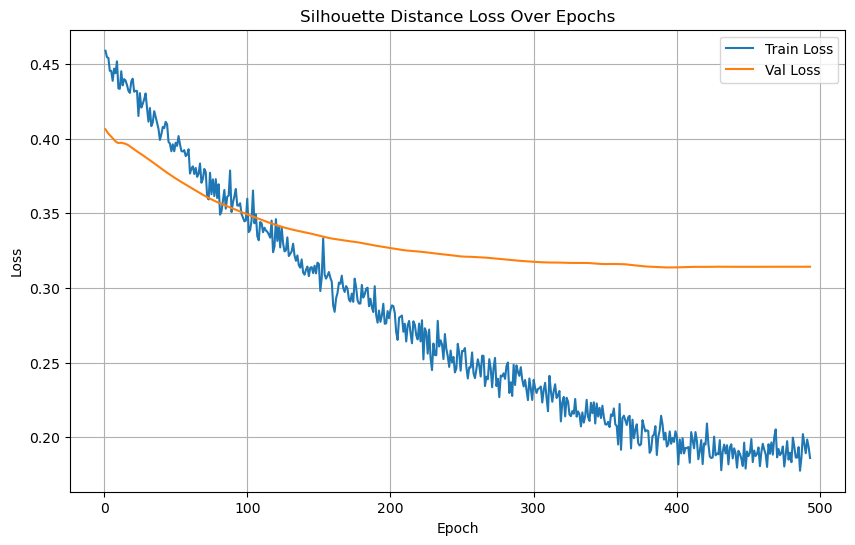

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/2314], Loss: 0.1124


Test Batch [20/2314], Loss: 0.2274
Test Batch [30/2314], Loss: 0.5000
Test Batch [40/2314], Loss: 0.2053
Test Batch [50/2314], Loss: 0.5000
Test Batch [60/2314], Loss: 0.5000


Test Batch [70/2314], Loss: 0.5000
Test Batch [80/2314], Loss: 0.2686


Test Batch [90/2314], Loss: 0.5000
Test Batch [100/2314], Loss: 0.0645
Test Batch [110/2314], Loss: 0.5000
Test Batch [120/2314], Loss: 0.2805
Test Batch [130/2314], Loss: 0.5000


Test Batch [140/2314], Loss: 0.5000


Test Batch [150/2314], Loss: 0.5000
Test Batch [160/2314], Loss: 0.2580
Test Batch [170/2314], Loss: 0.5000
Test Batch [180/2314], Loss: 0.5000
Test Batch [190/2314], Loss: 0.5000


Test Batch [200/2314], Loss: 0.2363
Test Batch [210/2314], Loss: 0.5000


Test Batch [220/2314], Loss: 0.5000
Test Batch [230/2314], Loss: 0.1394
Test Batch [240/2314], Loss: 0.0593
Test Batch [250/2314], Loss: 0.1984


Test Batch [260/2314], Loss: 0.5000
Test Batch [270/2314], Loss: 0.5000
Test Batch [280/2314], Loss: 0.5000


Test Batch [290/2314], Loss: 0.1842
Test Batch [300/2314], Loss: 0.1117
Test Batch [310/2314], Loss: 0.5000


Test Batch [320/2314], Loss: 0.1388
Test Batch [330/2314], Loss: 0.5000
Test Batch [340/2314], Loss: 0.5000
Test Batch [350/2314], Loss: 0.2153


Test Batch [360/2314], Loss: 0.1697
Test Batch [370/2314], Loss: 0.1977


Test Batch [380/2314], Loss: 0.1197
Test Batch [390/2314], Loss: 0.5000
Test Batch [400/2314], Loss: 0.5000
Test Batch [410/2314], Loss: 0.0517


Test Batch [420/2314], Loss: 0.0907
Test Batch [430/2314], Loss: 0.2032


Test Batch [440/2314], Loss: 0.5000
Test Batch [450/2314], Loss: 0.0760
Test Batch [460/2314], Loss: 0.5000


Test Batch [470/2314], Loss: 0.1971
Test Batch [480/2314], Loss: 0.5000


Test Batch [490/2314], Loss: 0.1317
Test Batch [500/2314], Loss: 0.0612
Test Batch [510/2314], Loss: 0.1350
Test Batch [520/2314], Loss: 0.0974
Test Batch [530/2314], Loss: 0.5000


Test Batch [540/2314], Loss: 0.0845
Test Batch [550/2314], Loss: 0.0828


Test Batch [560/2314], Loss: 0.5000
Test Batch [570/2314], Loss: 0.5000
Test Batch [580/2314], Loss: 0.1713


Test Batch [590/2314], Loss: 0.0529
Test Batch [600/2314], Loss: 0.5000


Test Batch [610/2314], Loss: 0.5000
Test Batch [620/2314], Loss: 0.1674
Test Batch [630/2314], Loss: 0.0330


Test Batch [640/2314], Loss: 0.1760
Test Batch [650/2314], Loss: 0.5000
Test Batch [660/2314], Loss: 0.0266


Test Batch [670/2314], Loss: 0.1964
Test Batch [680/2314], Loss: 0.5000
Test Batch [690/2314], Loss: 0.1096
Test Batch [700/2314], Loss: 0.2366


Test Batch [710/2314], Loss: 0.5000
Test Batch [720/2314], Loss: 0.5000


Test Batch [730/2314], Loss: 0.5000
Test Batch [740/2314], Loss: 0.0478
Test Batch [750/2314], Loss: 0.1935
Test Batch [760/2314], Loss: 0.0639


Test Batch [770/2314], Loss: 0.5000


Test Batch [780/2314], Loss: 0.0679
Test Batch [790/2314], Loss: 0.1833
Test Batch [800/2314], Loss: 0.1722
Test Batch [810/2314], Loss: 0.5000
Test Batch [820/2314], Loss: 0.2050


Test Batch [830/2314], Loss: 0.1011
Test Batch [840/2314], Loss: 0.5000
Test Batch [850/2314], Loss: 0.2587
Test Batch [860/2314], Loss: 0.5000
Test Batch [870/2314], Loss: 0.2259
Test Batch [880/2314], Loss: 0.1000
Test Batch [890/2314], Loss: 0.5000


Test Batch [900/2314], Loss: 0.5000
Test Batch [910/2314], Loss: 0.0630
Test Batch [920/2314], Loss: 0.5000
Test Batch [930/2314], Loss: 0.1805
Test Batch [940/2314], Loss: 0.1945
Test Batch [950/2314], Loss: 0.0700
Test Batch [960/2314], Loss: 0.0422


Test Batch [970/2314], Loss: 0.5000
Test Batch [980/2314], Loss: 0.5000
Test Batch [990/2314], Loss: 0.1835
Test Batch [1000/2314], Loss: 0.5000
Test Batch [1010/2314], Loss: 0.1754
Test Batch [1020/2314], Loss: 0.0604


Test Batch [1030/2314], Loss: 0.5000
Test Batch [1040/2314], Loss: 0.1986
Test Batch [1050/2314], Loss: 0.0638
Test Batch [1060/2314], Loss: 0.5000
Test Batch [1070/2314], Loss: 0.5000
Test Batch [1080/2314], Loss: 0.5000


Test Batch [1090/2314], Loss: 0.0427
Test Batch [1100/2314], Loss: 0.1350
Test Batch [1110/2314], Loss: 0.2099
Test Batch [1120/2314], Loss: 0.0404
Test Batch [1130/2314], Loss: 0.2183


Test Batch [1140/2314], Loss: 0.2025
Test Batch [1150/2314], Loss: 0.0351
Test Batch [1160/2314], Loss: 0.0453
Test Batch [1170/2314], Loss: 0.0267
Test Batch [1180/2314], Loss: 0.2047


Test Batch [1190/2314], Loss: 0.2907
Test Batch [1200/2314], Loss: 0.0430
Test Batch [1210/2314], Loss: 0.0859
Test Batch [1220/2314], Loss: 0.2251
Test Batch [1230/2314], Loss: 0.5000


Test Batch [1240/2314], Loss: 0.1510
Test Batch [1250/2314], Loss: 0.5000
Test Batch [1260/2314], Loss: 0.2229
Test Batch [1270/2314], Loss: 0.0924


Test Batch [1280/2314], Loss: 0.5000
Test Batch [1290/2314], Loss: 0.1033
Test Batch [1300/2314], Loss: 0.2216
Test Batch [1310/2314], Loss: 0.2697


Test Batch [1320/2314], Loss: 0.2760
Test Batch [1330/2314], Loss: 0.1332
Test Batch [1340/2314], Loss: 0.0437
Test Batch [1350/2314], Loss: 0.1622


Test Batch [1360/2314], Loss: 0.2113
Test Batch [1370/2314], Loss: 0.2350
Test Batch [1380/2314], Loss: 0.2174


Test Batch [1390/2314], Loss: 0.2078
Test Batch [1400/2314], Loss: 0.2412
Test Batch [1410/2314], Loss: 0.2079


Test Batch [1420/2314], Loss: 0.2305
Test Batch [1430/2314], Loss: 0.5000
Test Batch [1440/2314], Loss: 0.1561
Test Batch [1450/2314], Loss: 0.2304


Test Batch [1460/2314], Loss: 0.2496
Test Batch [1470/2314], Loss: 0.2071
Test Batch [1480/2314], Loss: 0.2263
Test Batch [1490/2314], Loss: 0.2545
Test Batch [1500/2314], Loss: 0.1946


Test Batch [1510/2314], Loss: 0.2103
Test Batch [1520/2314], Loss: 0.5000
Test Batch [1530/2314], Loss: 0.1896
Test Batch [1540/2314], Loss: 0.2034


Test Batch [1550/2314], Loss: 0.1623
Test Batch [1560/2314], Loss: 0.1546
Test Batch [1570/2314], Loss: 0.1886


Test Batch [1580/2314], Loss: 0.1081
Test Batch [1590/2314], Loss: 0.1727
Test Batch [1600/2314], Loss: 0.1325
Test Batch [1610/2314], Loss: 0.2134


Test Batch [1620/2314], Loss: 0.5000
Test Batch [1630/2314], Loss: 0.2481
Test Batch [1640/2314], Loss: 0.2983
Test Batch [1650/2314], Loss: 0.0842


Test Batch [1660/2314], Loss: 0.1798
Test Batch [1670/2314], Loss: 0.2514
Test Batch [1680/2314], Loss: 0.2704
Test Batch [1690/2314], Loss: 0.2262


Test Batch [1700/2314], Loss: 0.1704
Test Batch [1710/2314], Loss: 0.1643
Test Batch [1720/2314], Loss: 0.1324
Test Batch [1730/2314], Loss: 0.1595
Test Batch [1740/2314], Loss: 0.5000
Test Batch [1750/2314], Loss: 0.0839


Test Batch [1760/2314], Loss: 0.1629
Test Batch [1770/2314], Loss: 0.1837
Test Batch [1780/2314], Loss: 0.1731
Test Batch [1790/2314], Loss: 0.1760
Test Batch [1800/2314], Loss: 0.1660
Test Batch [1810/2314], Loss: 0.1789


Test Batch [1820/2314], Loss: 0.5000
Test Batch [1830/2314], Loss: 0.0305
Test Batch [1840/2314], Loss: 0.2206
Test Batch [1850/2314], Loss: 0.2003
Test Batch [1860/2314], Loss: 0.2091


Test Batch [1870/2314], Loss: 0.2777
Test Batch [1880/2314], Loss: 0.2020
Test Batch [1890/2314], Loss: 0.1782
Test Batch [1900/2314], Loss: 0.2165


Test Batch [1910/2314], Loss: 0.2687
Test Batch [1920/2314], Loss: 0.2572
Test Batch [1930/2314], Loss: 0.1643
Test Batch [1940/2314], Loss: 0.2189
Test Batch [1950/2314], Loss: 0.5000


Test Batch [1960/2314], Loss: 0.2187
Test Batch [1970/2314], Loss: 0.2126
Test Batch [1980/2314], Loss: 0.2321
Test Batch [1990/2314], Loss: 0.1848
Test Batch [2000/2314], Loss: 0.2113
Test Batch [2010/2314], Loss: 0.1506


Test Batch [2020/2314], Loss: 0.1854
Test Batch [2030/2314], Loss: 0.1771
Test Batch [2040/2314], Loss: 0.2027
Test Batch [2050/2314], Loss: 0.2540


Test Batch [2060/2314], Loss: 0.1647
Test Batch [2070/2314], Loss: 0.1553
Test Batch [2080/2314], Loss: 0.5000
Test Batch [2090/2314], Loss: 0.5000
Test Batch [2100/2314], Loss: 0.5000
Test Batch [2110/2314], Loss: 0.1683
Test Batch [2120/2314], Loss: 0.1505


Test Batch [2130/2314], Loss: 0.0989
Test Batch [2140/2314], Loss: 0.1451
Test Batch [2150/2314], Loss: 0.5000
Test Batch [2160/2314], Loss: 0.5000
Test Batch [2170/2314], Loss: 0.5000
Test Batch [2180/2314], Loss: 0.1447


Test Batch [2190/2314], Loss: 0.0433
Test Batch [2200/2314], Loss: 0.2392
Test Batch [2210/2314], Loss: 0.0341
Test Batch [2220/2314], Loss: 0.5000
Test Batch [2230/2314], Loss: 0.0249
Test Batch [2240/2314], Loss: 0.5000


Test Batch [2250/2314], Loss: 0.5000
Test Batch [2260/2314], Loss: 0.5000
Test Batch [2270/2314], Loss: 0.2891
Test Batch [2280/2314], Loss: 0.1739
Test Batch [2290/2314], Loss: 0.5000
Test Batch [2300/2314], Loss: 0.5000


Test Batch [2310/2314], Loss: 0.1551

Test Loss: 0.2634


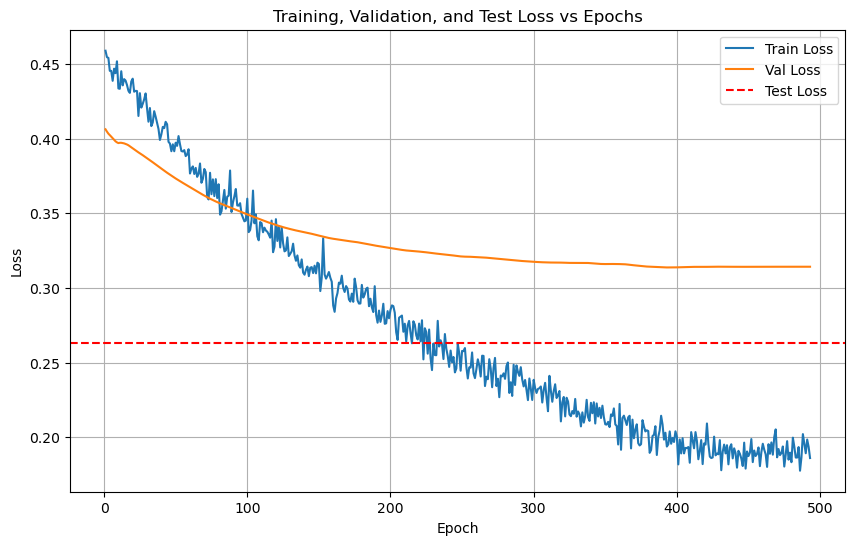

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/2314 for test dataset.


  Processed batch 20/2314 for test dataset.


  Processed batch 30/2314 for test dataset.
  Processed batch 40/2314 for test dataset.


  Processed batch 50/2314 for test dataset.


  Processed batch 60/2314 for test dataset.
  Processed batch 70/2314 for test dataset.
  Processed batch 80/2314 for test dataset.


  Processed batch 90/2314 for test dataset.
  Processed batch 100/2314 for test dataset.
  Processed batch 110/2314 for test dataset.
  Processed batch 120/2314 for test dataset.


  Processed batch 130/2314 for test dataset.
  Processed batch 140/2314 for test dataset.
  Processed batch 150/2314 for test dataset.
  Processed batch 160/2314 for test dataset.


  Processed batch 170/2314 for test dataset.
  Processed batch 180/2314 for test dataset.
  Processed batch 190/2314 for test dataset.
  Processed batch 200/2314 for test dataset.


  Processed batch 210/2314 for test dataset.
  Processed batch 220/2314 for test dataset.
  Processed batch 230/2314 for test dataset.


  Processed batch 240/2314 for test dataset.
  Processed batch 250/2314 for test dataset.
  Processed batch 260/2314 for test dataset.
  Processed batch 270/2314 for test dataset.


  Processed batch 280/2314 for test dataset.
  Processed batch 290/2314 for test dataset.
  Processed batch 300/2314 for test dataset.


  Processed batch 310/2314 for test dataset.
  Processed batch 320/2314 for test dataset.
  Processed batch 330/2314 for test dataset.


  Processed batch 340/2314 for test dataset.
  Processed batch 350/2314 for test dataset.
  Processed batch 360/2314 for test dataset.
  Processed batch 370/2314 for test dataset.


  Processed batch 380/2314 for test dataset.
  Processed batch 390/2314 for test dataset.
  Processed batch 400/2314 for test dataset.
  Processed batch 410/2314 for test dataset.


  Processed batch 420/2314 for test dataset.
  Processed batch 430/2314 for test dataset.
  Processed batch 440/2314 for test dataset.
  Processed batch 450/2314 for test dataset.


  Processed batch 460/2314 for test dataset.
  Processed batch 470/2314 for test dataset.
  Processed batch 480/2314 for test dataset.
  Processed batch 490/2314 for test dataset.


  Processed batch 500/2314 for test dataset.
  Processed batch 510/2314 for test dataset.
  Processed batch 520/2314 for test dataset.
  Processed batch 530/2314 for test dataset.


  Processed batch 540/2314 for test dataset.
  Processed batch 550/2314 for test dataset.
  Processed batch 560/2314 for test dataset.


  Processed batch 570/2314 for test dataset.
  Processed batch 580/2314 for test dataset.
  Processed batch 590/2314 for test dataset.
  Processed batch 600/2314 for test dataset.


  Processed batch 610/2314 for test dataset.
  Processed batch 620/2314 for test dataset.
  Processed batch 630/2314 for test dataset.
  Processed batch 640/2314 for test dataset.


  Processed batch 650/2314 for test dataset.
  Processed batch 660/2314 for test dataset.
  Processed batch 670/2314 for test dataset.
  Processed batch 680/2314 for test dataset.


  Processed batch 690/2314 for test dataset.
  Processed batch 700/2314 for test dataset.
  Processed batch 710/2314 for test dataset.
  Processed batch 720/2314 for test dataset.


  Processed batch 730/2314 for test dataset.
  Processed batch 740/2314 for test dataset.
  Processed batch 750/2314 for test dataset.
  Processed batch 760/2314 for test dataset.


  Processed batch 770/2314 for test dataset.
  Processed batch 780/2314 for test dataset.
  Processed batch 790/2314 for test dataset.


  Processed batch 800/2314 for test dataset.
  Processed batch 810/2314 for test dataset.
  Processed batch 820/2314 for test dataset.
  Processed batch 830/2314 for test dataset.


  Processed batch 840/2314 for test dataset.
  Processed batch 850/2314 for test dataset.
  Processed batch 860/2314 for test dataset.


  Processed batch 870/2314 for test dataset.
  Processed batch 880/2314 for test dataset.
  Processed batch 890/2314 for test dataset.


  Processed batch 900/2314 for test dataset.
  Processed batch 910/2314 for test dataset.
  Processed batch 920/2314 for test dataset.
  Processed batch 930/2314 for test dataset.


  Processed batch 940/2314 for test dataset.
  Processed batch 950/2314 for test dataset.
  Processed batch 960/2314 for test dataset.
  Processed batch 970/2314 for test dataset.


  Processed batch 980/2314 for test dataset.
  Processed batch 990/2314 for test dataset.
  Processed batch 1000/2314 for test dataset.
  Processed batch 1010/2314 for test dataset.


  Processed batch 1020/2314 for test dataset.
  Processed batch 1030/2314 for test dataset.
  Processed batch 1040/2314 for test dataset.


  Processed batch 1050/2314 for test dataset.
  Processed batch 1060/2314 for test dataset.
  Processed batch 1070/2314 for test dataset.


  Processed batch 1080/2314 for test dataset.
  Processed batch 1090/2314 for test dataset.
  Processed batch 1100/2314 for test dataset.
  Processed batch 1110/2314 for test dataset.


  Processed batch 1120/2314 for test dataset.
  Processed batch 1130/2314 for test dataset.
  Processed batch 1140/2314 for test dataset.


  Processed batch 1150/2314 for test dataset.
  Processed batch 1160/2314 for test dataset.
  Processed batch 1170/2314 for test dataset.


  Processed batch 1180/2314 for test dataset.
  Processed batch 1190/2314 for test dataset.
  Processed batch 1200/2314 for test dataset.
  Processed batch 1210/2314 for test dataset.


  Processed batch 1220/2314 for test dataset.
  Processed batch 1230/2314 for test dataset.
  Processed batch 1240/2314 for test dataset.
  Processed batch 1250/2314 for test dataset.


  Processed batch 1260/2314 for test dataset.
  Processed batch 1270/2314 for test dataset.
  Processed batch 1280/2314 for test dataset.
  Processed batch 1290/2314 for test dataset.


  Processed batch 1300/2314 for test dataset.
  Processed batch 1310/2314 for test dataset.
  Processed batch 1320/2314 for test dataset.


  Processed batch 1330/2314 for test dataset.
  Processed batch 1340/2314 for test dataset.
  Processed batch 1350/2314 for test dataset.


  Processed batch 1360/2314 for test dataset.
  Processed batch 1370/2314 for test dataset.
  Processed batch 1380/2314 for test dataset.


  Processed batch 1390/2314 for test dataset.
  Processed batch 1400/2314 for test dataset.
  Processed batch 1410/2314 for test dataset.


  Processed batch 1420/2314 for test dataset.
  Processed batch 1430/2314 for test dataset.
  Processed batch 1440/2314 for test dataset.


  Processed batch 1450/2314 for test dataset.
  Processed batch 1460/2314 for test dataset.
  Processed batch 1470/2314 for test dataset.
  Processed batch 1480/2314 for test dataset.


  Processed batch 1490/2314 for test dataset.
  Processed batch 1500/2314 for test dataset.
  Processed batch 1510/2314 for test dataset.
  Processed batch 1520/2314 for test dataset.


  Processed batch 1530/2314 for test dataset.
  Processed batch 1540/2314 for test dataset.
  Processed batch 1550/2314 for test dataset.
  Processed batch 1560/2314 for test dataset.


  Processed batch 1570/2314 for test dataset.
  Processed batch 1580/2314 for test dataset.
  Processed batch 1590/2314 for test dataset.
  Processed batch 1600/2314 for test dataset.


  Processed batch 1610/2314 for test dataset.
  Processed batch 1620/2314 for test dataset.
  Processed batch 1630/2314 for test dataset.


  Processed batch 1640/2314 for test dataset.
  Processed batch 1650/2314 for test dataset.
  Processed batch 1660/2314 for test dataset.


  Processed batch 1670/2314 for test dataset.
  Processed batch 1680/2314 for test dataset.
  Processed batch 1690/2314 for test dataset.


  Processed batch 1700/2314 for test dataset.
  Processed batch 1710/2314 for test dataset.
  Processed batch 1720/2314 for test dataset.
  Processed batch 1730/2314 for test dataset.


  Processed batch 1740/2314 for test dataset.
  Processed batch 1750/2314 for test dataset.
  Processed batch 1760/2314 for test dataset.
  Processed batch 1770/2314 for test dataset.


  Processed batch 1780/2314 for test dataset.
  Processed batch 1790/2314 for test dataset.
  Processed batch 1800/2314 for test dataset.


  Processed batch 1810/2314 for test dataset.
  Processed batch 1820/2314 for test dataset.
  Processed batch 1830/2314 for test dataset.
  Processed batch 1840/2314 for test dataset.


  Processed batch 1850/2314 for test dataset.
  Processed batch 1860/2314 for test dataset.
  Processed batch 1870/2314 for test dataset.


  Processed batch 1880/2314 for test dataset.
  Processed batch 1890/2314 for test dataset.
  Processed batch 1900/2314 for test dataset.


  Processed batch 1910/2314 for test dataset.
  Processed batch 1920/2314 for test dataset.
  Processed batch 1930/2314 for test dataset.
  Processed batch 1940/2314 for test dataset.


  Processed batch 1950/2314 for test dataset.
  Processed batch 1960/2314 for test dataset.
  Processed batch 1970/2314 for test dataset.


  Processed batch 1980/2314 for test dataset.
  Processed batch 1990/2314 for test dataset.
  Processed batch 2000/2314 for test dataset.
  Processed batch 2010/2314 for test dataset.


  Processed batch 2020/2314 for test dataset.
  Processed batch 2030/2314 for test dataset.
  Processed batch 2040/2314 for test dataset.
  Processed batch 2050/2314 for test dataset.


  Processed batch 2060/2314 for test dataset.
  Processed batch 2070/2314 for test dataset.
  Processed batch 2080/2314 for test dataset.
  Processed batch 2090/2314 for test dataset.


  Processed batch 2100/2314 for test dataset.
  Processed batch 2110/2314 for test dataset.
  Processed batch 2120/2314 for test dataset.
  Processed batch 2130/2314 for test dataset.


  Processed batch 2140/2314 for test dataset.
  Processed batch 2150/2314 for test dataset.
  Processed batch 2160/2314 for test dataset.
  Processed batch 2170/2314 for test dataset.


  Processed batch 2180/2314 for test dataset.
  Processed batch 2190/2314 for test dataset.
  Processed batch 2200/2314 for test dataset.


  Processed batch 2210/2314 for test dataset.
  Processed batch 2220/2314 for test dataset.
  Processed batch 2230/2314 for test dataset.


  Processed batch 2240/2314 for test dataset.
  Processed batch 2250/2314 for test dataset.
  Processed batch 2260/2314 for test dataset.
  Processed batch 2270/2314 for test dataset.


  Processed batch 2280/2314 for test dataset.
  Processed batch 2290/2314 for test dataset.
  Processed batch 2300/2314 for test dataset.
  Processed batch 2310/2314 for test dataset.


Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148062, 128)
Test labels shape: (148062,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 82.22%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.67      0.80      0.73         5
           2       0.67      0.40      0.50         5
           3       0.62      1.00      0.77         5
           4       0.75      0.60      0.67         5
           5       0.83      1.00      0.91         5
           6       1.00      1.00      1.00         5
           7       1.00      0.80      0.89         5
           8       1.00      0.80      0.89         5

    accuracy                           0.82        45
   macro avg       0.84      0.82      0.82        45
weighted avg       0.84      0.82      0.82        45


LOG: Evaluating on the test set...
Test Accuracy: 92.12%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     65961
           1       0.89      0.83      0.86      7588
           2       0.55      0.67      0.60      3080
           3       0.35      0.86      0.49      2675
           4       0.64      0.66      0.65      6574
           5       0.88      0.92      0.90      9238
           6       0.93      0.84      0.88      7277
           7       0.98      0.89      0.94     42816
           8       0.98      0.97      0.98      2853

    accuracy                           0.92    148062
   macro avg       0.80      0.85      0.81    148062
weighted avg       0.94      0.92      0.93    148062

Saved SCL_SDL+LRM predictions and true labels to model_predictions


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148062, 128)
Test labels shape: (148062,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.2454  |  Val Loss: 2.2192
Validation loss improved from inf to 2.2192.
[Epoch 2/1000] Train Loss: 2.2317  |  Val Loss: 2.2105
Validation loss improved from 2.2192 to 2.2105.
[Epoch 3/1000] Train Loss: 2.2180  |  Val Loss: 2.2019
Validation loss improved from 2.2105 to 2.2019.
[Epoch 4/1000] Train Loss: 2.2046  |  Val Loss: 2.1933
Validation loss improved from 2.2019 to 2.1933.
[Epoch 5/1000] Train Loss: 2.1914  |  Val Loss: 2.1849
Validation loss improved from 2.1933 to 2.1849.
[Epoch 6/1000] Train Loss: 2.1783  |  Val Loss: 2.1767
Validation loss improved from 2.1849 to 2.1767.
[Epoch 7/1000] Train Loss: 2.1653  |  Val Loss: 2.1684
Validation loss improved from 2.1767 to 2.1684.
[Epoch 8/1000] Train Loss: 2.1523  |  Val Loss: 2.1603
Validation loss improved from 2.1684 to 2.1603.
[Epoch 9/1000] Train Loss: 2.1394  |  Val Loss: 2.1524
Validation loss improved from 2.1603 to 2.1524.
[Epoch 10/1000] Train Loss: 2.1267  |  Val Loss: 2.1444
Validation loss impr

[Epoch 53/1000] Train Loss: 1.6814  |  Val Loss: 1.8498
Validation loss improved from 1.8560 to 1.8498.
[Epoch 54/1000] Train Loss: 1.6724  |  Val Loss: 1.8437
Validation loss improved from 1.8498 to 1.8437.
[Epoch 55/1000] Train Loss: 1.6633  |  Val Loss: 1.8376
Validation loss improved from 1.8437 to 1.8376.
[Epoch 56/1000] Train Loss: 1.6543  |  Val Loss: 1.8314
Validation loss improved from 1.8376 to 1.8314.
[Epoch 57/1000] Train Loss: 1.6453  |  Val Loss: 1.8253
Validation loss improved from 1.8314 to 1.8253.
[Epoch 58/1000] Train Loss: 1.6362  |  Val Loss: 1.8191
Validation loss improved from 1.8253 to 1.8191.
[Epoch 59/1000] Train Loss: 1.6271  |  Val Loss: 1.8128
Validation loss improved from 1.8191 to 1.8128.
[Epoch 60/1000] Train Loss: 1.6179  |  Val Loss: 1.8065
Validation loss improved from 1.8128 to 1.8065.
[Epoch 61/1000] Train Loss: 1.6087  |  Val Loss: 1.8001
Validation loss improved from 1.8065 to 1.8001.
[Epoch 62/1000] Train Loss: 1.5995  |  Val Loss: 1.7937
Validati

[Epoch 73/1000] Train Loss: 1.4987  |  Val Loss: 1.7246
Validation loss improved from 1.7309 to 1.7246.
[Epoch 74/1000] Train Loss: 1.4896  |  Val Loss: 1.7184
Validation loss improved from 1.7246 to 1.7184.
[Epoch 75/1000] Train Loss: 1.4806  |  Val Loss: 1.7122
Validation loss improved from 1.7184 to 1.7122.
[Epoch 76/1000] Train Loss: 1.4716  |  Val Loss: 1.7060
Validation loss improved from 1.7122 to 1.7060.
[Epoch 77/1000] Train Loss: 1.4627  |  Val Loss: 1.6998
Validation loss improved from 1.7060 to 1.6998.
[Epoch 78/1000] Train Loss: 1.4538  |  Val Loss: 1.6936
Validation loss improved from 1.6998 to 1.6936.
[Epoch 79/1000] Train Loss: 1.4449  |  Val Loss: 1.6875
Validation loss improved from 1.6936 to 1.6875.
[Epoch 80/1000] Train Loss: 1.4361  |  Val Loss: 1.6814
Validation loss improved from 1.6875 to 1.6814.
[Epoch 81/1000] Train Loss: 1.4272  |  Val Loss: 1.6754
Validation loss improved from 1.6814 to 1.6754.
[Epoch 82/1000] Train Loss: 1.4184  |  Val Loss: 1.6695
Validati

[Epoch 116/1000] Train Loss: 1.1254  |  Val Loss: 1.4762
Validation loss improved from 1.4817 to 1.4762.
[Epoch 117/1000] Train Loss: 1.1169  |  Val Loss: 1.4706
Validation loss improved from 1.4762 to 1.4706.
[Epoch 118/1000] Train Loss: 1.1084  |  Val Loss: 1.4650
Validation loss improved from 1.4706 to 1.4650.
[Epoch 119/1000] Train Loss: 1.0999  |  Val Loss: 1.4594
Validation loss improved from 1.4650 to 1.4594.
[Epoch 120/1000] Train Loss: 1.0914  |  Val Loss: 1.4539
Validation loss improved from 1.4594 to 1.4539.
[Epoch 121/1000] Train Loss: 1.0830  |  Val Loss: 1.4484
Validation loss improved from 1.4539 to 1.4484.
[Epoch 122/1000] Train Loss: 1.0745  |  Val Loss: 1.4429
Validation loss improved from 1.4484 to 1.4429.
[Epoch 123/1000] Train Loss: 1.0662  |  Val Loss: 1.4374
Validation loss improved from 1.4429 to 1.4374.
[Epoch 124/1000] Train Loss: 1.0578  |  Val Loss: 1.4320
Validation loss improved from 1.4374 to 1.4320.
[Epoch 125/1000] Train Loss: 1.0495  |  Val Loss: 1.426

[Epoch 143/1000] Train Loss: 0.9057  |  Val Loss: 1.3311
Validation loss improved from 1.3365 to 1.3311.
[Epoch 144/1000] Train Loss: 0.8979  |  Val Loss: 1.3257
Validation loss improved from 1.3311 to 1.3257.
[Epoch 145/1000] Train Loss: 0.8901  |  Val Loss: 1.3202
Validation loss improved from 1.3257 to 1.3202.
[Epoch 146/1000] Train Loss: 0.8823  |  Val Loss: 1.3148
Validation loss improved from 1.3202 to 1.3148.
[Epoch 147/1000] Train Loss: 0.8746  |  Val Loss: 1.3095
Validation loss improved from 1.3148 to 1.3095.
[Epoch 148/1000] Train Loss: 0.8670  |  Val Loss: 1.3041
Validation loss improved from 1.3095 to 1.3041.
[Epoch 149/1000] Train Loss: 0.8594  |  Val Loss: 1.2988
Validation loss improved from 1.3041 to 1.2988.
[Epoch 150/1000] Train Loss: 0.8518  |  Val Loss: 1.2936
Validation loss improved from 1.2988 to 1.2936.
[Epoch 151/1000] Train Loss: 0.8443  |  Val Loss: 1.2884
Validation loss improved from 1.2936 to 1.2884.
[Epoch 152/1000] Train Loss: 0.8368  |  Val Loss: 1.283

[Epoch 181/1000] Train Loss: 0.6351  |  Val Loss: 1.1485
Validation loss improved from 1.1526 to 1.1485.
[Epoch 182/1000] Train Loss: 0.6288  |  Val Loss: 1.1445
Validation loss improved from 1.1485 to 1.1445.
[Epoch 183/1000] Train Loss: 0.6226  |  Val Loss: 1.1405
Validation loss improved from 1.1445 to 1.1405.
[Epoch 184/1000] Train Loss: 0.6164  |  Val Loss: 1.1366
Validation loss improved from 1.1405 to 1.1366.
[Epoch 185/1000] Train Loss: 0.6102  |  Val Loss: 1.1328
Validation loss improved from 1.1366 to 1.1328.
[Epoch 186/1000] Train Loss: 0.6042  |  Val Loss: 1.1290
Validation loss improved from 1.1328 to 1.1290.
[Epoch 187/1000] Train Loss: 0.5981  |  Val Loss: 1.1252
Validation loss improved from 1.1290 to 1.1252.
[Epoch 188/1000] Train Loss: 0.5921  |  Val Loss: 1.1214
Validation loss improved from 1.1252 to 1.1214.
[Epoch 189/1000] Train Loss: 0.5862  |  Val Loss: 1.1176
Validation loss improved from 1.1214 to 1.1176.
[Epoch 190/1000] Train Loss: 0.5803  |  Val Loss: 1.113

[Epoch 211/1000] Train Loss: 0.4672  |  Val Loss: 1.0443
Validation loss improved from 1.0473 to 1.0443.
[Epoch 212/1000] Train Loss: 0.4622  |  Val Loss: 1.0413
Validation loss improved from 1.0443 to 1.0413.
[Epoch 213/1000] Train Loss: 0.4573  |  Val Loss: 1.0384
Validation loss improved from 1.0413 to 1.0384.
[Epoch 214/1000] Train Loss: 0.4525  |  Val Loss: 1.0356
Validation loss improved from 1.0384 to 1.0356.
[Epoch 215/1000] Train Loss: 0.4476  |  Val Loss: 1.0328
Validation loss improved from 1.0356 to 1.0328.
[Epoch 216/1000] Train Loss: 0.4428  |  Val Loss: 1.0300
Validation loss improved from 1.0328 to 1.0300.
[Epoch 217/1000] Train Loss: 0.4381  |  Val Loss: 1.0272
Validation loss improved from 1.0300 to 1.0272.
[Epoch 218/1000] Train Loss: 0.4334  |  Val Loss: 1.0245
Validation loss improved from 1.0272 to 1.0245.
[Epoch 219/1000] Train Loss: 0.4287  |  Val Loss: 1.0218
Validation loss improved from 1.0245 to 1.0218.
[Epoch 220/1000] Train Loss: 0.4240  |  Val Loss: 1.019

[Epoch 252/1000] Train Loss: 0.2981  |  Val Loss: 0.9502
Validation loss improved from 0.9518 to 0.9502.
[Epoch 253/1000] Train Loss: 0.2948  |  Val Loss: 0.9486
Validation loss improved from 0.9502 to 0.9486.
[Epoch 254/1000] Train Loss: 0.2916  |  Val Loss: 0.9471
Validation loss improved from 0.9486 to 0.9471.
[Epoch 255/1000] Train Loss: 0.2885  |  Val Loss: 0.9456
Validation loss improved from 0.9471 to 0.9456.
[Epoch 256/1000] Train Loss: 0.2853  |  Val Loss: 0.9442
Validation loss improved from 0.9456 to 0.9442.
[Epoch 257/1000] Train Loss: 0.2822  |  Val Loss: 0.9427
Validation loss improved from 0.9442 to 0.9427.
[Epoch 258/1000] Train Loss: 0.2792  |  Val Loss: 0.9414
Validation loss improved from 0.9427 to 0.9414.
[Epoch 259/1000] Train Loss: 0.2761  |  Val Loss: 0.9400
Validation loss improved from 0.9414 to 0.9400.
[Epoch 260/1000] Train Loss: 0.2731  |  Val Loss: 0.9387
Validation loss improved from 0.9400 to 0.9387.
[Epoch 261/1000] Train Loss: 0.2702  |  Val Loss: 0.937

[Epoch 281/1000] Train Loss: 0.2179  |  Val Loss: 0.9171
Validation loss improved from 0.9179 to 0.9171.
[Epoch 282/1000] Train Loss: 0.2156  |  Val Loss: 0.9164
Validation loss improved from 0.9171 to 0.9164.
[Epoch 283/1000] Train Loss: 0.2134  |  Val Loss: 0.9156
Validation loss improved from 0.9164 to 0.9156.
[Epoch 284/1000] Train Loss: 0.2111  |  Val Loss: 0.9149
Validation loss improved from 0.9156 to 0.9149.
[Epoch 285/1000] Train Loss: 0.2089  |  Val Loss: 0.9142
Validation loss improved from 0.9149 to 0.9142.
[Epoch 286/1000] Train Loss: 0.2068  |  Val Loss: 0.9135
Validation loss improved from 0.9142 to 0.9135.
[Epoch 287/1000] Train Loss: 0.2046  |  Val Loss: 0.9128
Validation loss improved from 0.9135 to 0.9128.
[Epoch 288/1000] Train Loss: 0.2025  |  Val Loss: 0.9121
Validation loss improved from 0.9128 to 0.9121.
[Epoch 289/1000] Train Loss: 0.2004  |  Val Loss: 0.9115
Validation loss improved from 0.9121 to 0.9115.
[Epoch 290/1000] Train Loss: 0.1984  |  Val Loss: 0.910

[Epoch 318/1000] Train Loss: 0.1499  |  Val Loss: 0.9005
Validation loss improved from 0.9006 to 0.9005.
[Epoch 319/1000] Train Loss: 0.1484  |  Val Loss: 0.9004
Validation loss improved from 0.9005 to 0.9004.
[Epoch 320/1000] Train Loss: 0.1470  |  Val Loss: 0.9002
Validation loss improved from 0.9004 to 0.9002.
[Epoch 321/1000] Train Loss: 0.1456  |  Val Loss: 0.9001
Validation loss improved from 0.9002 to 0.9001.
[Epoch 322/1000] Train Loss: 0.1442  |  Val Loss: 0.9000
Validation loss improved from 0.9001 to 0.9000.
[Epoch 323/1000] Train Loss: 0.1428  |  Val Loss: 0.8999
Validation loss improved from 0.9000 to 0.8999.
[Epoch 324/1000] Train Loss: 0.1415  |  Val Loss: 0.8999
Validation loss improved from 0.8999 to 0.8999.
[Epoch 325/1000] Train Loss: 0.1401  |  Val Loss: 0.8998
Validation loss improved from 0.8999 to 0.8998.
[Epoch 326/1000] Train Loss: 0.1388  |  Val Loss: 0.8998
Validation loss improved from 0.8998 to 0.8998.
[Epoch 327/1000] Train Loss: 0.1375  |  Val Loss: 0.899

[Epoch 351/1000] Train Loss: 0.1111  |  Val Loss: 0.9031
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 352/1000] Train Loss: 0.1101  |  Val Loss: 0.9034
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 353/1000] Train Loss: 0.1092  |  Val Loss: 0.9037
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 354/1000] Train Loss: 0.1083  |  Val Loss: 0.9039
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 355/1000] Train Loss: 0.1074  |  Val Loss: 0.9042
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 356/1000] Train Loss: 0.1065  |  Val Loss: 0.9045
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 357/1000] Train Loss: 0.1056  |  Val Loss: 0.9048
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 358/1000] Train Loss: 0.1047  |  Val Loss: 0.9051
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 359/1000] Train Loss: 0.1039  |  Val Loss: 0.9055
!! Validation loss did NOT improve !! Patience:

[Epoch 389/1000] Train Loss: 0.0821  |  Val Loss: 0.9161
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 390/1000] Train Loss: 0.0815  |  Val Loss: 0.9165
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 391/1000] Train Loss: 0.0809  |  Val Loss: 0.9169
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 392/1000] Train Loss: 0.0803  |  Val Loss: 0.9173
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 393/1000] Train Loss: 0.0797  |  Val Loss: 0.9177
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 394/1000] Train Loss: 0.0791  |  Val Loss: 0.9181
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 395/1000] Train Loss: 0.0785  |  Val Loss: 0.9185
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 396/1000] Train Loss: 0.0780  |  Val Loss: 0.9189
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 397/1000] Train Loss: 0.0774  |  Val Loss: 0.9193
!! Validation loss did NOT improve !! Patience:

[Epoch 418/1000] Train Loss: 0.0665  |  Val Loss: 0.9291
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 419/1000] Train Loss: 0.0661  |  Val Loss: 0.9296
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 420/1000] Train Loss: 0.0656  |  Val Loss: 0.9301
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 421/1000] Train Loss: 0.0652  |  Val Loss: 0.9306
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 422/1000] Train Loss: 0.0647  |  Val Loss: 0.9311
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 423/1000] Train Loss: 0.0643  |  Val Loss: 0.9316
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 424/1000] Train Loss: 0.0638  |  Val Loss: 0.9321
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 425/1000] Train Loss: 0.0634  |  Val Loss: 0.9327
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 426/1000] Train Loss: 0.0630  |  Val Loss: 0.9332
!! Validation loss did NOT improve !! Patience:

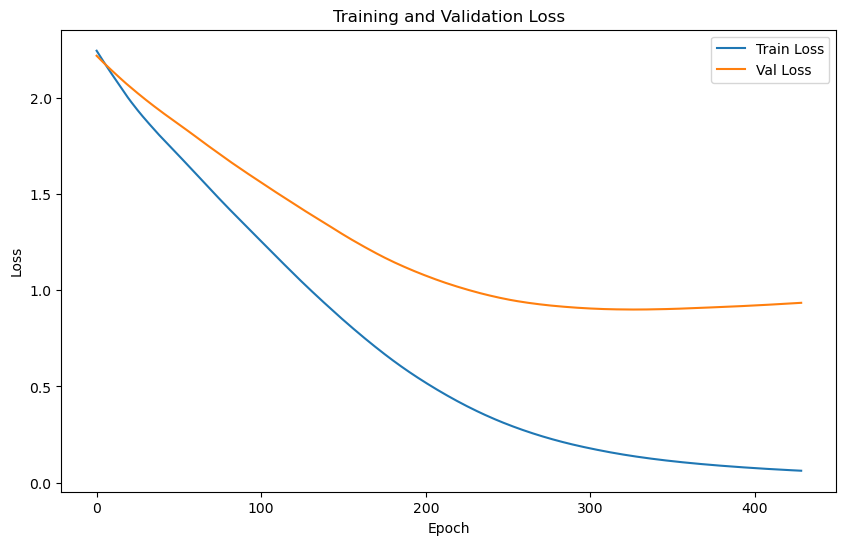

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.4901 | Test Accuracy: 87.21%


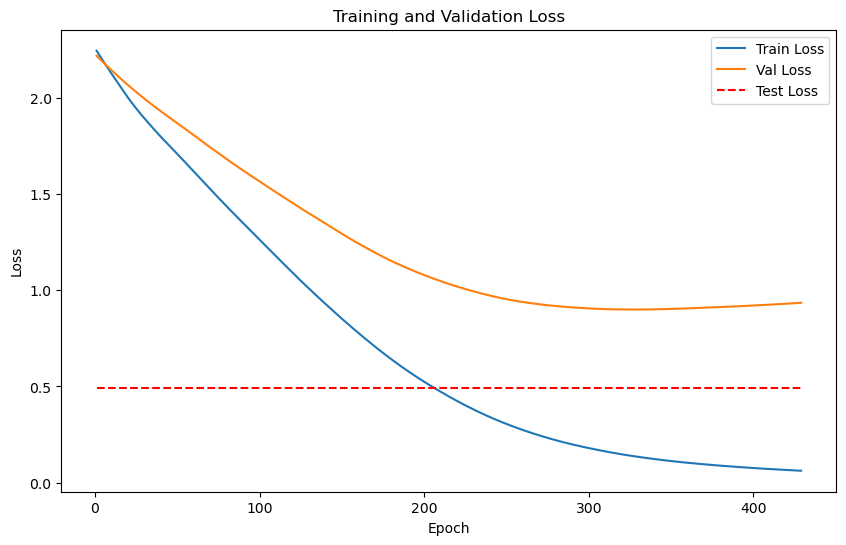

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


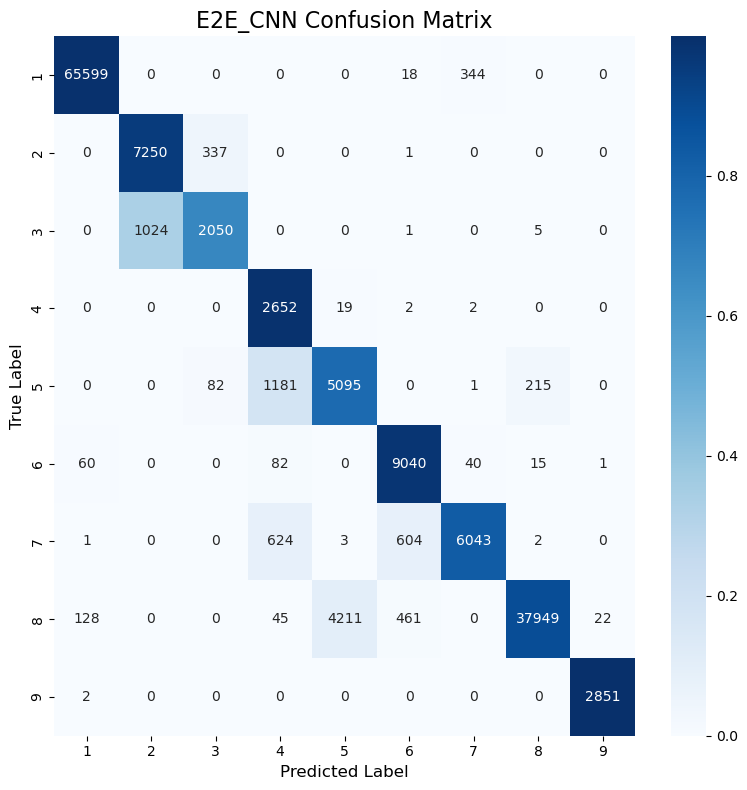

Classification Accuracy: 93.56%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


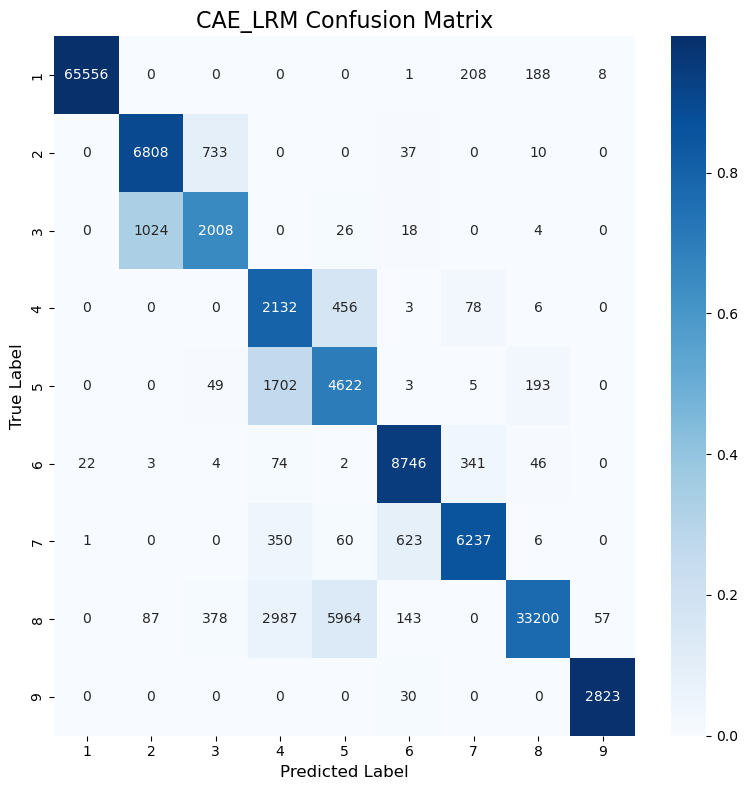

Classification Accuracy: 89.24%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


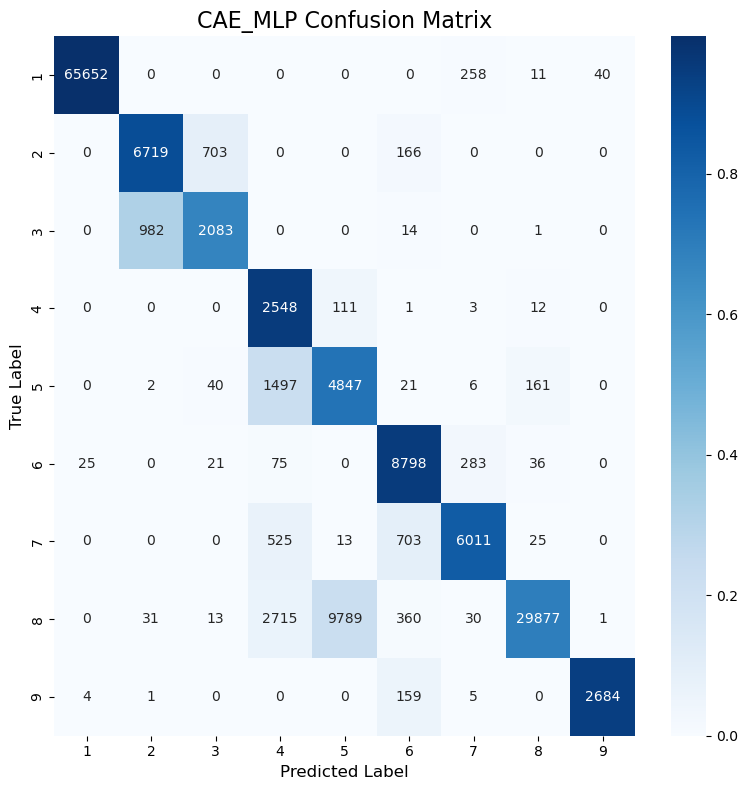

Classification Accuracy: 87.27%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


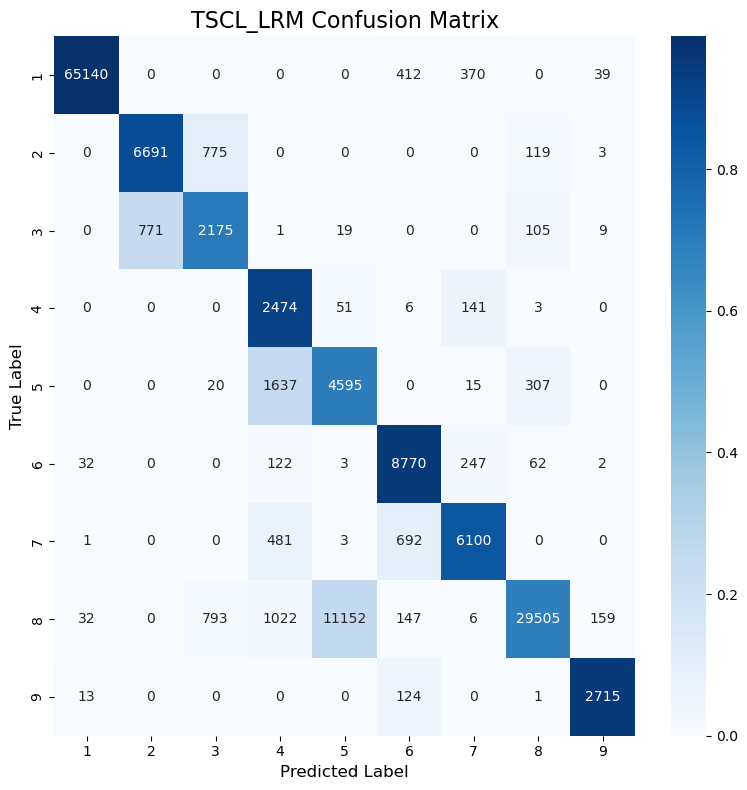

Classification Accuracy: 86.56%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


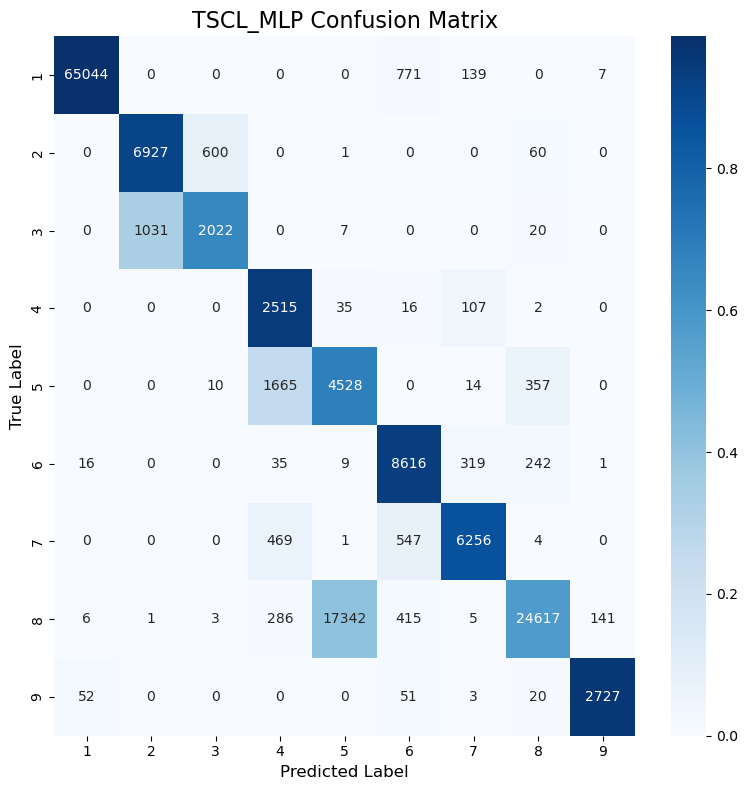

Classification Accuracy: 83.24%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


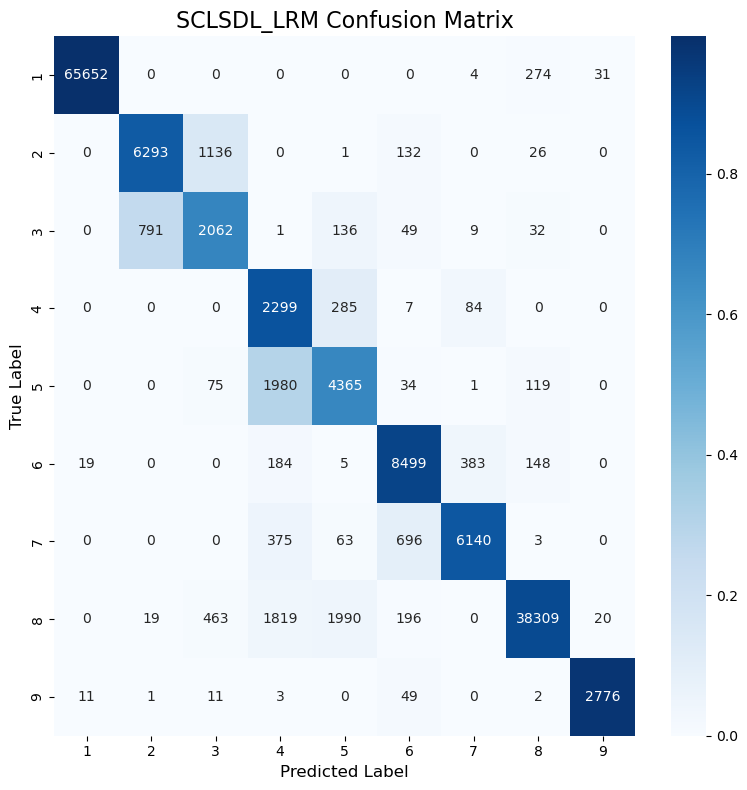

Classification Accuracy: 92.12%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


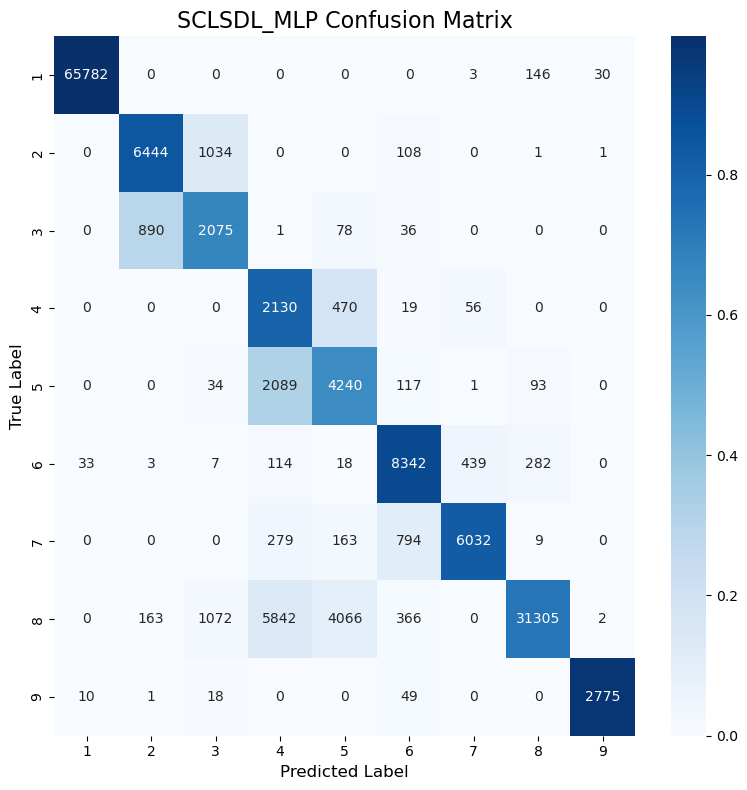

Classification Accuracy: 87.21%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          93.56
1    LRM (CAE)          89.24
2    MLP (CAE)          87.27
3     TSCL LRM          86.56
4     TSCL MLP          83.24
5  SCL_SDL LRM          92.12
6  SCL_SDL MLP          87.21

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          93.56
5  SCL_SDL LRM          92.12
1    LRM (CAE)          89.24
2    MLP (CAE)          87.27
6  SCL_SDL MLP          87.21
3     TSCL LRM          86.56
4     TSCL MLP          83.24
